### Introduction

### Training Process

#### Step 1: Look for faces from video frames

#### Step 2: Calculate the embedding vector for every face

    A face embedding is a vector that represents the features extracted from the face.
    For example, another vector that is close (by some measure) may be the same person,
    whereas another vector that is far (by some measure) may be a different person.

#### Step 3: Perform the clustering of the embedding vectors
     
    The goal of the clustering is to figure out which set of the embedding corresponds to the user.
    We use DBScan for clustering.

    We do not know how many people will appear on the images.
    As a result, we should not use “number_of_clusters” as an input to our clustering algorithm.
    
    For this reason, we used DBScan. Major challenge of using DBSCAN algorithm is to find right
    set hyper parameters(eps and min_samples values) to fit in to the algorithm for getting accurate result.    

### Importing the Libraries

In [1]:
from numpy import unique
from numpy import where
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from itertools import product 
from plot_utils import plot_clusters, plot_pca_variance
import time
from face_detection import FaceDetection
from action_recognition import ActionRecognition
import cv2
import seaborn as sns
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\tensorflow\pyth

### Collect Faces from video frames

In [2]:
action_recognition = ActionRecognition()
faceDetection = FaceDetection()
vs = cv2.VideoCapture("video.mp4")
faces = []


# Loop Video Stream
while True:

    (grabbed, frame) = vs.read()
    
    if frame is None:
        break
        
    # Step 2: Calculate the embedding vector for every face
    temp = faceDetection.detect_faces(frame, "video.mp4", 0.95)
    faces.extend(temp)
    
    frame = cv2.resize(frame, (300, 300))
    cv2.imshow('camera2',frame) 
    
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break
    
cv2.destroyAllWindows()

[2021-03-09 22:20:17,236] [TfPoseEstimator] [INFO] loading graph from C:\Users\Haliva\Data Science\Data Science Course - Final Project\libs\action_recognition\models\graph/mobilenet_thin/graph_opt.pb(default size=656x368)


mobilenet_thin
656x368
models/trained_classifier.pickle
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Feature Reduction - PCA - Principal Components Analysis

In [3]:
 def get_best_pca_dimensions(data, threshold_variance = 90):

    print("\n-------------------- get_best_pca_dimensions --------------------\n")

    n_components =  min(len(data), len(data[0]))
    sns.set_theme()

    pca = PCA(n_components=n_components)
    pca.fit(data)
    variance = pca.explained_variance_ratio_ 
    var=np.cumsum(np.round(variance, 3)*100)

    plot_pca_variance(var)

    best_pca_dimensions =  next(item[0] for item in enumerate(var) if item[1] > threshold_variance)
    print("best_pca_dimensions for", threshold_variance ,"% Variance is: ", best_pca_dimensions, "Features\n")
    return best_pca_dimensions

In [4]:
def create_pca(faces, face_encodings, n_components = 20):

    pca = PCA(n_components=n_components)
    pca.fit(face_encodings)

    pca_scale = pca.transform(face_encodings)
    pca_df = pd.DataFrame(pca_scale)

    pca_df_all_data = pd.DataFrame()
    pca_df_all_data['face_location'] = faces.face_location
    pca_df_all_data['image_path'] = faces.image_path
    # pca_df_all_data['face_encodings'] = pd.Series(pca_scale.tolist())
    pca_df_all_data['face_encodings'] = face_encodings

    return pca_df_all_data, pca_df


-------------------- get_best_pca_dimensions --------------------



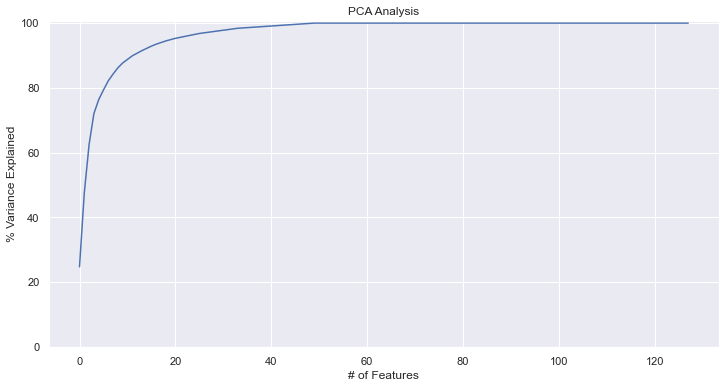

best_pca_dimensions for 90 % Variance is:  12 Features



In [5]:
clustring_algorithms_results = []
faces = pd.DataFrame(faces)
face_encodings = faces['face_encoding'].tolist()
best_pca_dimensions = get_best_pca_dimensions(face_encodings)
pca_df_all_data, pca_df = create_pca(faces, face_encodings, best_pca_dimensions)

In [6]:
faces

,face_encoding,face_location,image_path
0,"[-1.1912599, -0.8228302, -0.40031707, -1.63635...","[1222, 50, 1525, 432]",video.mp4
1,"[-1.2779435, -0.87038517, -0.37021828, -1.7669...","[1249, 52, 1546, 434]",video.mp4
2,"[-1.0201672, -0.60240805, -0.6928619, -1.40743...","[1250, 22, 1562, 430]",video.mp4
3,"[-1.1640614, -0.59016705, -0.5768476, -1.29468...","[1299, 11, 1629, 441]",video.mp4
4,"[-0.95789826, -0.18442962, -0.9021818, -1.3385...","[1324, 19, 1654, 440]",video.mp4
...,...,...,...
295,"[-1.4184235, -0.6505166, -0.9390658, -0.624670...","[1533, 452, 1830, 870]",video.mp4
296,"[-1.1496332, -0.26877365, -0.20659196, -0.3247...","[737, 590, 985, 918]",video.mp4
297,"[-1.4349687, -0.41537136, -1.2884346, -0.72868...","[1537, 469, 1833, 889]",video.mp4
298,"[-1.1718473, -0.62041783, -0.26983872, -0.1617...","[779, 621, 1003, 923]",video.mp4


In [7]:
pca_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,6.632051,5.462099,-5.114827,-0.721870,-0.420408,-0.581613,-1.126621,-0.311334,-1.596250,-1.181629,1.237681,-2.154640
1,7.063499,5.764046,-4.736115,-0.788277,0.005537,-0.777543,-1.780529,-0.315537,-1.299415,-1.275315,1.460270,-2.071229
2,7.209326,6.061231,-4.227365,-0.543843,-0.343146,-0.501081,-1.911965,-0.314760,-0.921060,-1.292680,1.264362,-1.965599
3,7.631540,5.803324,-4.597648,-0.728529,-0.956847,0.268161,-1.769117,-0.682694,-0.840343,-1.317338,1.162375,-1.268344
4,7.703223,5.364998,-4.360388,-1.022363,-0.997751,0.583872,-1.171742,-0.946971,-1.261848,-1.638705,0.530497,-1.634429
5,7.628506,4.863581,-3.849565,-1.537682,-0.855728,0.148452,-1.025853,-0.004170,-1.264347,-1.966710,0.326345,-1.691318
6,6.933752,5.416652,-4.739520,-0.321093,-0.706659,-0.550434,-1.240540,-0.712841,-0.991507,-2.131953,1.166796,-0.688864
7,3.956941,-3.253599,3.965481,1.705531,-1.897862,9.600417,1.613751,0.244367,1.317958,-0.053662,1.574837,-0.986045
8,3.534425,-3.273304,3.703535,1.947101,-1.347885,9.847428,1.660205,0.533434,0.843553,0.145402,1.386519,-1.017408
9,3.180732,-1.827404,2.871335,2.154563,-1.573911,10.384267,1.257343,0.042798,1.825613,0.592592,2.141253,-0.442133


In [8]:
pca_df_all_data.head(10)

,face_location,image_path,face_encodings
0,"[1222, 50, 1525, 432]",video.mp4,"[-1.1912599, -0.8228302, -0.40031707, -1.63635..."
1,"[1249, 52, 1546, 434]",video.mp4,"[-1.2779435, -0.87038517, -0.37021828, -1.7669..."
2,"[1250, 22, 1562, 430]",video.mp4,"[-1.0201672, -0.60240805, -0.6928619, -1.40743..."
3,"[1299, 11, 1629, 441]",video.mp4,"[-1.1640614, -0.59016705, -0.5768476, -1.29468..."
4,"[1324, 19, 1654, 440]",video.mp4,"[-0.95789826, -0.18442962, -0.9021818, -1.3385..."
5,"[1367, 30, 1675, 423]",video.mp4,"[-1.3983204, -0.581247, -0.74171174, -1.205270..."
6,"[1418, 32, 1747, 431]",video.mp4,"[-1.4254541, -0.5838759, -0.5488362, -1.090055..."
7,"[2957, 258, 3364, 777]",video.mp4,"[0.048062377, -0.5501151, -1.0377924, 0.110354..."
8,"[2996, 282, 3406, 810]",video.mp4,"[0.5444144, -0.22423716, -1.5393554, 0.1495253..."
9,"[3143, 328, 3552, 874]",video.mp4,"[0.010228589, -0.39886296, -1.2394885, 0.07075..."


## Perform the clustering of the embedding vectors

### K Means Algorithm

####       K Means Algorithm & Elbow Rule

K means is a quite simple unsupervised machine learning algorithm. It works as follows:

1. We define k, which is the number of clusters
2. The algorithm selects randomly k-points of the dataset and use them as initial centroids
3. The algorithm calculates the distance (we have to define a metric, a proximity measure) between the k centroids
   and all the other points of the dataset.
4. Each point is assigned to the cluster, in which it has the smallest distance from the controid
5. Reassignes the centroids.
6. The algorith stops when the centroids do not change any more.

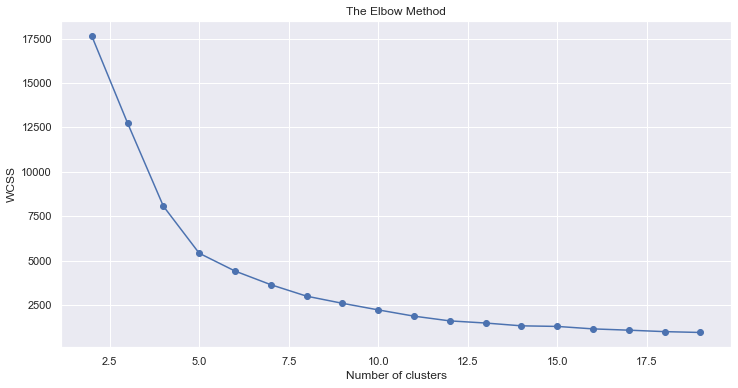

In [9]:
wcss = []
end_index =  20
for i in range(2, end_index):
    kmeans = KMeans(n_clusters = i, random_state = 10)
    kmeans.fit(pca_df.iloc[:,:-1])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12,6))
plt.plot(range(2, end_index), wcss, marker = 'o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

####  Using Silhouette analysis & Kmeans algorithm to find the ideal no. of clusters for the data

In [10]:
def get_best_num_of_clusters(data, start_index, end_index):

    print("\n-------------------- get_best_num_of_clusters --------------------\n")
    print(start_index,end_index)
    range_n_clusters = range(start_index,end_index)
    print(range_n_clusters)

    sil = []

    for num_of_clusters in range_n_clusters:

        clusterer = KMeans(n_clusters = num_of_clusters, random_state = 10)
        clusterer_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, clusterer_labels)
        if(silhouette_avg < 0.1):
            break
        sil.append(silhouette_avg)
        print("For n_clusters =", num_of_clusters, "The average silhouette_score :", silhouette_avg)

    ind = np.argmax(sil) + 2
    print("best_n_clusters: ", ind)   
    silhouette_max = np.amax(sil)

    return ind, silhouette_max

In [11]:
def cluster_faces_with_kmeans(pca_df_all_data, pca_df):
    
    best_n_clusters, silhouette_max = get_best_num_of_clusters(pca_df, 2, 30)
    clusterer = KMeans(n_clusters = best_n_clusters, random_state = 10)
    clusterer_labels = clusterer.fit_predict(pca_df)
    
    pca_df_all_data['cluster'] = clusterer_labels
    
    clustring_algorithms_results.append({"Name": "KMEANS", "silhouette_score": silhouette_max, "num_of_clusters": best_n_clusters})
    
    return pca_df_all_data, pca_df, silhouette_max
    

In [12]:
pca_df_all_data, pca_df, kmeans_sil_score = cluster_faces_with_kmeans(pca_df_all_data, pca_df)


-------------------- get_best_num_of_clusters --------------------

2 30
range(2, 30)
For n_clusters = 2 The average silhouette_score : 0.3223028792830674
For n_clusters = 3 The average silhouette_score : 0.3918840984147179
For n_clusters = 4 The average silhouette_score : 0.4989712613928893
For n_clusters = 5 The average silhouette_score : 0.5688438883271825
For n_clusters = 6 The average silhouette_score : 0.5469308538750911
For n_clusters = 7 The average silhouette_score : 0.5692125226472173
For n_clusters = 8 The average silhouette_score : 0.5462788000857761
For n_clusters = 9 The average silhouette_score : 0.5299158351939016
For n_clusters = 10 The average silhouette_score : 0.5434153292406267
For n_clusters = 11 The average silhouette_score : 0.5582339818637411
For n_clusters = 12 The average silhouette_score : 0.5764975365458453
For n_clusters = 13 The average silhouette_score : 0.5335035672772298
For n_clusters = 14 The average silhouette_score : 0.498136775839143
For n_cluste

In [13]:
pca_df_all_data.head()

,face_location,image_path,face_encodings,cluster
0,"[1222, 50, 1525, 432]",video.mp4,"[-1.1912599, -0.8228302, -0.40031707, -1.63635...",3
1,"[1249, 52, 1546, 434]",video.mp4,"[-1.2779435, -0.87038517, -0.37021828, -1.7669...",3
2,"[1250, 22, 1562, 430]",video.mp4,"[-1.0201672, -0.60240805, -0.6928619, -1.40743...",3
3,"[1299, 11, 1629, 441]",video.mp4,"[-1.1640614, -0.59016705, -0.5768476, -1.29468...",3
4,"[1324, 19, 1654, 440]",video.mp4,"[-0.95789826, -0.18442962, -0.9021818, -1.3385...",3


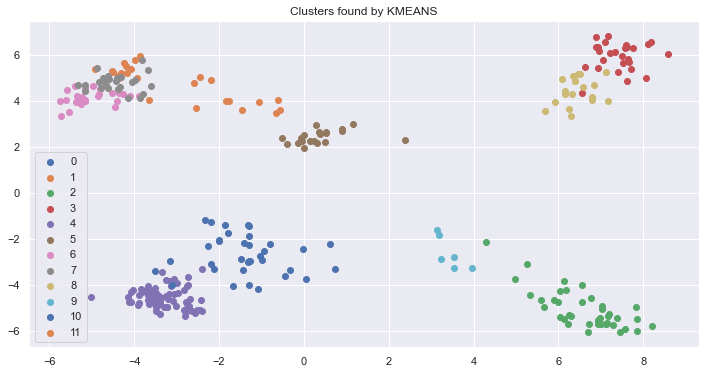

In [14]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "KMEANS")

### DBSCAN Algorithm

In order to understand how DBSCAN works, we have to define the following:

* **minPts**: minimun number of points (neighbors) that must exist within a circe of
  radius eps and center a specific point in order to classify it as core point.

* **eps**: defines the radius of neighborhood around a point x.

We classify all the points of a dataset as:

1. **core point**: if there are at least **MinPts** points within a circle of radius **eps**.
2. **border point**: if it contains at least 1 core point in its neighbor.
3. **noise point**: if it is neither a core point nor a border point.

##### DBSCAN Algorithm (simplified)
1. Scan the database.
2. Assign each point to one of the following categories: core point, border point or noise.
3. Reject all the noise points.
4. Connect all the core points within a distance ε and create a separate cluster.
5. Assign each border point to the cluster which is reachable from a core point.

#### Determine Optimal Epsilon And MinPts Values

**Approach #1 - Nearest Neighbors Approach - Using Euclidean distance method to find optimum epsilon distance(eps)**

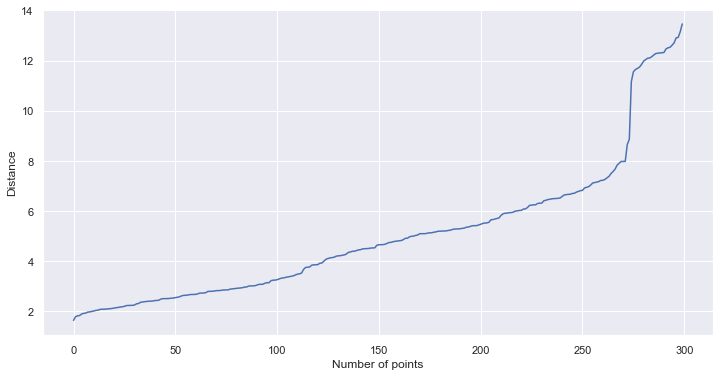

In [15]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=best_pca_dimensions * 2)
nbrs = neigh.fit(pca_df)
distances, indices = nbrs.kneighbors(pca_df)
distances = np.sort(distances[:,-1], axis = 0)
plt.figure(figsize=(12,6))
plt.plot(distances)
plt.xlabel('Number of points')
plt.ylabel('Distance')
plt.show()

**Approach #2 - Iteration Approach - Silhouette_score**

In [16]:
def plot_dbscan_parameters(all_dbscan_results_df):
    
    top = all_dbscan_results_df.nlargest(10, 'silhouette_score')
    
    fig, axs = plt.subplots(2, 2, figsize=(20,15))   
    
    x_data = ["({} , {})".format(eps,minPts) for eps,minPts in zip(top.minimum_points, top.epsilon_values)]
    axs[0,0].scatter(x_data, top.silhouette_score, color="#246EB9")
    axs[0,0].set_title("top 10 - (eps,minPts) vs silhouette_score")
    axs[0,0].set_ylim(0, 0.7)
    
    axs[0,1].bar(all_dbscan_results_df.minimum_points, all_dbscan_results_df.silhouette_score, color="#246EB9")
    axs[0,1].set_title("minimum_points vs silhouette_score")
    axs[0,1].set_ylim(0, 0.7)
    axs[0,1].set_xticks(np.arange(all_dbscan_results_df.minimum_points.min(), all_dbscan_results_df.minimum_points.max(), 1))
    
#     plt.xticks(np.arange(all_dbscan_results_df.minimum_points.min(), all_dbscan_results_df.minimum_points.max(), 1))
            
    axs[1,0].bar(all_dbscan_results_df.epsilon_values, all_dbscan_results_df.silhouette_score, color="#246EB9", width=0.3)
    axs[1,0].set_title("epsilon_values vs silhouette_score")
    axs[1,0].set_ylim(0, 0.7)
    axs[1,0].set_xticks(np.arange(all_dbscan_results_df.epsilon_values.min(), all_dbscan_results_df.epsilon_values.max(), 0.5))
    
      
    axs[1,1].bar(all_dbscan_results_df.no_of_clusters, all_dbscan_results_df.silhouette_score, color="#246EB9")
    axs[1,1].set_title("no_of_clusters vs silhouette_score")
    axs[1,1].set_ylim(0, 0.7)
    axs[1,1].set_xticks(np.arange(all_dbscan_results_df.no_of_clusters.min(), all_dbscan_results_df.no_of_clusters.max(), 1))

def get_optimal_parameters(data, eps_start_index, eps_end_index, eps_step, min_pts_start_index, min_pts_end_index):
      
    no_of_clusters = []
    sil_scores = []
    eps_values = []
    min_pts_values = []
    
    for eps in np.arange(eps_start_index,eps_end_index, eps_step):
        for min_pts in np.arange(min_pts_start_index, min_pts_end_index):
            
            labels, sil_score = start_dbscan(data,eps=eps, min_samples=min_pts)
                
            if sil_score is not None:
                eps_values.append(eps)
                min_pts_values.append(min_pts)
                no_of_clusters.append(len(np.unique(labels)))
                sil_scores.append(sil_score)
        
    all_dbscan_results = list(zip(no_of_clusters, sil_scores, eps_values, min_pts_values))
    all_dbscan_results_df = pd.DataFrame(all_dbscan_results, columns=['no_of_clusters', 'silhouette_score', 'epsilon_values', 'minimum_points'])
    
    plot_dbscan_parameters(all_dbscan_results_df)
    
    maxValueIndex = np.nanmax(all_dbscan_results_df.silhouette_score.astype("float").idxmax())
    
    best_parameters = all_dbscan_results_df.iloc[maxValueIndex]
    
    return best_parameters.epsilon_values, best_parameters.minimum_points

In [17]:
def start_dbscan(data, eps = 0.5, min_samples = 5):

    # print(eps, min_samples)

    # creating DBSCAN object for clustering the encodings with the metric "euclidean"
    dbscan_model = DBSCAN( eps = eps, min_samples = min_samples, n_jobs = 2, metric = "euclidean")

    # train the model
    dbscan_model.fit(data)

    labels = dbscan_model.labels_

    # determine the total number of unique faces found in the dataset
    # clt.labels_ contains the label ID for all faces in our dataset (i.e., which cluster each face belongs to).
    # To find the unique faces/unique label IDs, used NumPy’s unique function.
    # The result is a list of unique labelIDs
    label_ids = np.unique(dbscan_model.labels_)

    # we count the numUniqueFaces . There could potentially be a value of -1 in labelIDs — this value corresponds
    # to the “outlier” class where a 128-d embedding was too far away from any other clusters to be added to it.
    # “outliers” could either be worth examining or simply discarding based on the application of face clustering.
    num_unique_faces = len(np.where(label_ids > -1)[0])

    # print("[INFO] # unique faces: {}".format(num_unique_faces))

    n_noise_ = list(dbscan_model.labels_).count(-1)

    # print('Estimated number of noise points: %d' % n_noise_)

    if num_unique_faces > 1:
        sil_score = silhouette_score(data, labels)
        # print("Silhouette Coefficient: %0.3f" % sil_score)
        return labels, sil_score

    return labels , None

In [18]:
def cluster_faces_with_db_scan(pca_df_all_data, pca_df, best_pca_dimensions):
    
    eps_start_index = 1
    eps_end_index = 20
    eps_step = 0.5
    min_pts_start_index = 2
    min_pts_end_index = best_pca_dimensions * 2
    
    best_eps, best_min_samples = get_optimal_parameters(pca_df, eps_start_index, eps_end_index, eps_step, min_pts_start_index, min_pts_end_index)
    
    print("best_min_samples", best_min_samples, "best_eps", best_eps)
    
    # print("\n------------------------- start DBSCAN ------------------------------\n")

    labels, sil_score = start_dbscan(pca_df, eps = best_eps, min_samples = best_min_samples)
    pca_df_all_data['cluster'] = labels
    
    clustring_algorithms_results.append({"Name": "DBSCAN", "silhouette_score": sil_score, "num_of_clusters": len(np.unique(labels))})

    # print("\n------------------------- finish DBSCAN ------------------------------\n")

    return pca_df_all_data, pca_df,sil_score

best_min_samples 2.0 best_eps 6.0


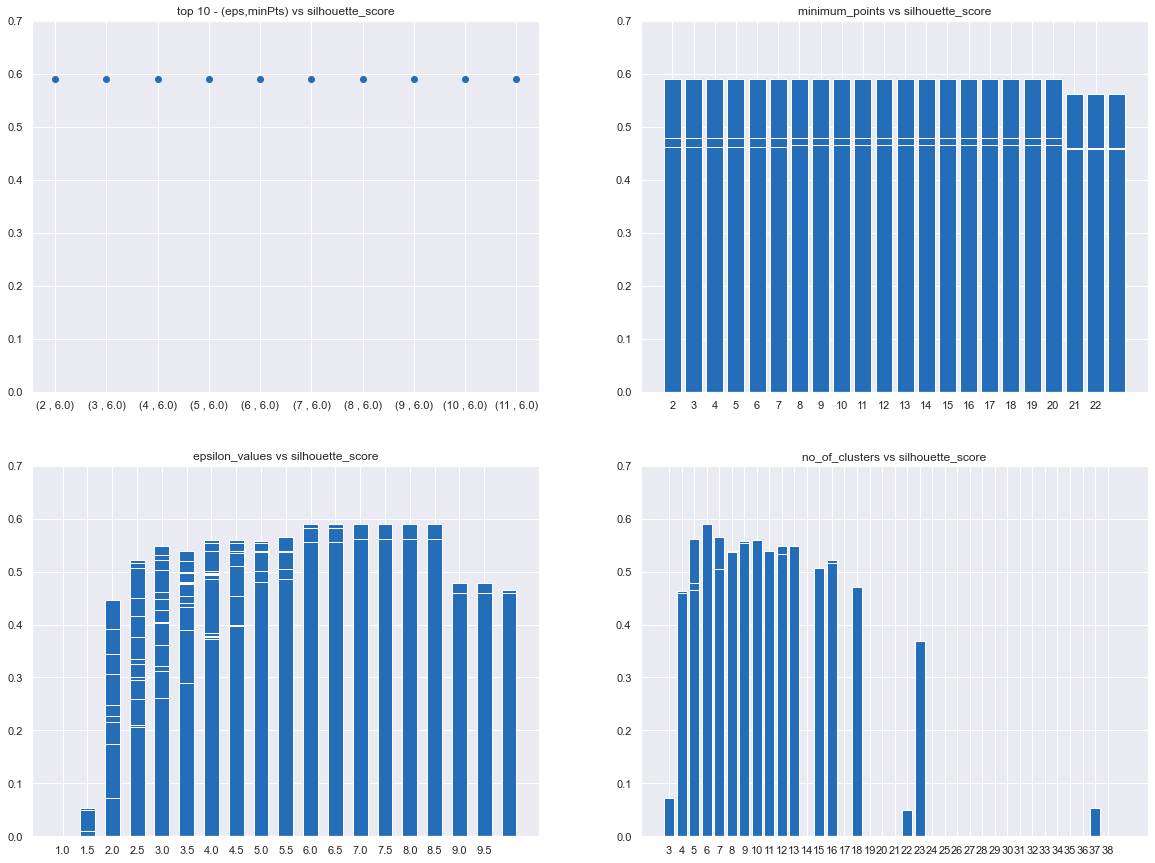

In [19]:
pca_df_all_data, pca_df, dbscan_sil_score = cluster_faces_with_db_scan(pca_df_all_data, pca_df, best_pca_dimensions)

In [20]:
pca_df_all_data

,face_location,image_path,face_encodings,cluster
0,"[1222, 50, 1525, 432]",video.mp4,"[-1.1912599, -0.8228302, -0.40031707, -1.63635...",0
1,"[1249, 52, 1546, 434]",video.mp4,"[-1.2779435, -0.87038517, -0.37021828, -1.7669...",0
2,"[1250, 22, 1562, 430]",video.mp4,"[-1.0201672, -0.60240805, -0.6928619, -1.40743...",0
3,"[1299, 11, 1629, 441]",video.mp4,"[-1.1640614, -0.59016705, -0.5768476, -1.29468...",0
4,"[1324, 19, 1654, 440]",video.mp4,"[-0.95789826, -0.18442962, -0.9021818, -1.3385...",0
...,...,...,...,...
295,"[1533, 452, 1830, 870]",video.mp4,"[-1.4184235, -0.6505166, -0.9390658, -0.624670...",0
296,"[737, 590, 985, 918]",video.mp4,"[-1.1496332, -0.26877365, -0.20659196, -0.3247...",5
297,"[1537, 469, 1833, 889]",video.mp4,"[-1.4349687, -0.41537136, -1.2884346, -0.72868...",0
298,"[779, 621, 1003, 923]",video.mp4,"[-1.1718473, -0.62041783, -0.26983872, -0.1617...",5


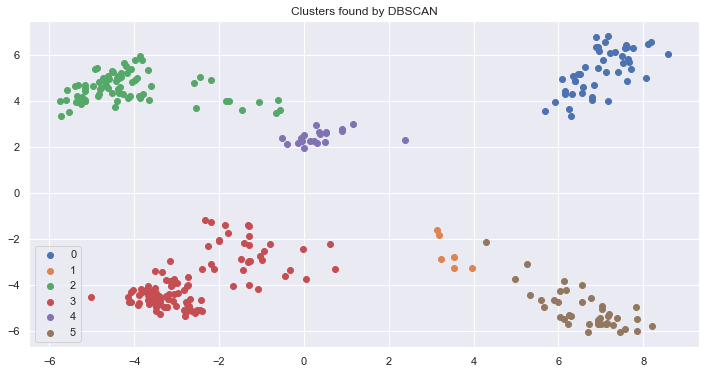

In [21]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "DBSCAN")

In [22]:
print("DBSCAN silhouette_score :", dbscan_sil_score)
print("KMEANS silhouette_score :", kmeans_sil_score)

DBSCAN silhouette_score : 0.5893593940763328
KMEANS silhouette_score : 0.5764975365458453


### MeanShift clustering

In [23]:
from sklearn.cluster import estimate_bandwidth
def cluster_faces_with_meanshift(pca_df_all_data, pca_df):
    
    est_bandwidth = estimate_bandwidth(pca_df,quantile=.15,n_samples=10000)
    meanShift = MeanShift(bandwidth= est_bandwidth, bin_seeding=True)
    clusterer_labels = meanShift.fit_predict(pca_df)
    pca_df_all_data['cluster'] = clusterer_labels
    
    labels_unique=np.unique(clusterer_labels)
    n_clusters_=len(labels_unique)
    
    silh_score = 0
    
    if n_clusters_ > 1:
         silh_score = silhouette_score(pca_df, clusterer_labels)

    print("Number of estimated clusters : %d" % n_clusters_)
    
    clustring_algorithms_results.append({"Name": "MEANSHIFT", "silhouette_score": silh_score, "num_of_clusters": n_clusters_})
    
    return pca_df_all_data, pca_df, silh_score

In [24]:
pca_df_all_data, pca_df, meanshift_sil_score = cluster_faces_with_meanshift(pca_df_all_data, pca_df)

Number of estimated clusters : 6


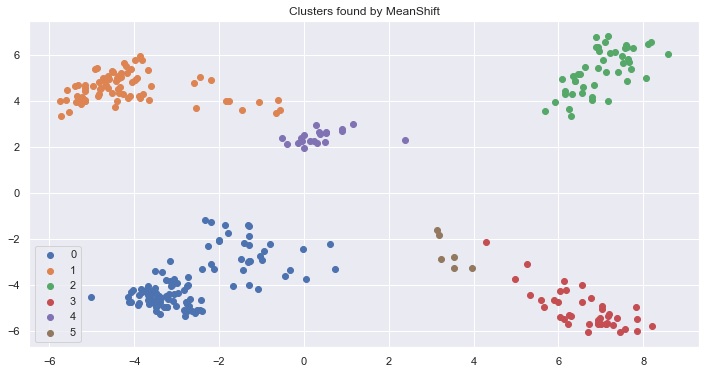

In [25]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "MeanShift")

In [26]:
print("DBSCAN silhouette_score :", dbscan_sil_score)
print("KMEANS silhouette_score :", kmeans_sil_score)
print("MEANSHIFT silhouette_score :", meanshift_sil_score)

DBSCAN silhouette_score : 0.5893593940763328
KMEANS silhouette_score : 0.5764975365458453
MEANSHIFT silhouette_score : 0.5893593940763328


### Hierarchical Clustering

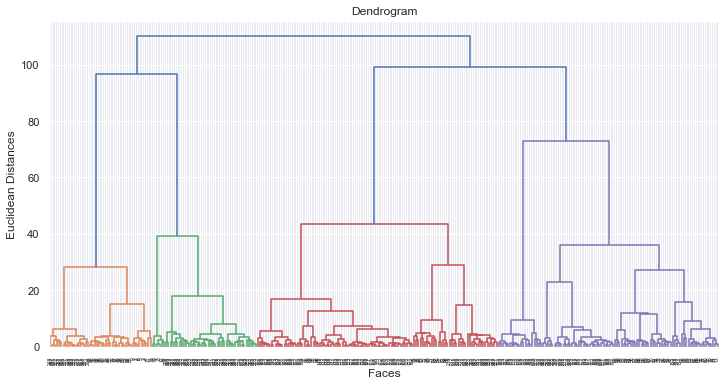

In [27]:
mergings = sch.linkage(pca_df, method = 'ward')
plt.figure(figsize=(12,6))
sch.dendrogram(mergings)
plt.title('Dendrogram')
plt.xlabel('Faces')
plt.ylabel('Euclidean Distances')
plt.show()

# By looking at this dendrogram, it can be seen that the optimal number of cluster is 5.
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
clusterer_labels = cluster.fit_predict(pca_df)
pca_df_all_data['cluster'] = clusterer_labels
hierarchical_sil_score = silhouette_score(pca_df, clusterer_labels, metric="euclidean")
clustring_algorithms_results.append({"Name": "HIERARCHICAL", "silhouette_score": hierarchical_sil_score, "num_of_clusters": 5})

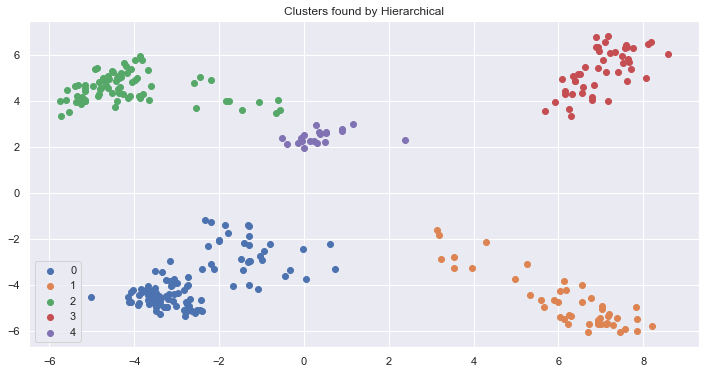

In [28]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "Hierarchical")

In [29]:
print("DBSCAN silhouette_score :", dbscan_sil_score)
print("KMEANS silhouette_score :", kmeans_sil_score)
print("MEANSHIFT silhouette_score :", meanshift_sil_score)
print("HIERARCHICAL silhouette_score :", hierarchical_sil_score)

DBSCAN silhouette_score : 0.5893593940763328
KMEANS silhouette_score : 0.5764975365458453
MEANSHIFT silhouette_score : 0.5893593940763328
HIERARCHICAL silhouette_score : 0.5688438883271825


### GMM Clustering

In [30]:
from sklearn.mixture import GaussianMixture

def get_best_k_paramerter(data, start_index, end_index):

    k_range = range(start_index, end_index) 

    pca_no_of_clusters = []
    pca_sil_score = []
    pca_k_values = []

    for k in k_range:
        
        # Apply your clustering algorithm of choice to the data
        clusterer = GaussianMixture(n_components=k, random_state=10)
        labels = clusterer.fit_predict(data)
        pca_k_values.append(k)
        pca_no_of_clusters.append(len(np.unique(labels)))
        pca_sil_score.append(silhouette_score(data,labels))

    pca_k_array = list(zip(pca_no_of_clusters, pca_sil_score, pca_k_values))
    pca_k_df = pd.DataFrame(pca_k_array, columns=['no_of_clusters', 'silhouette_score', 'k_values'])
    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=pca_k_df, x="k_values", y="silhouette_score")

    maxValueIndex = np.nanmax(pca_k_df.silhouette_score.idxmax())
    best_k = pca_k_df.iloc[maxValueIndex].k_values
    return int(best_k), pca_k_df.iloc[maxValueIndex].silhouette_score

def cluster_faces_with_GMM(pca_df_all_data, pca_df):
    
    k, silhouette_score_max = get_best_k_paramerter(pca_df, 2, best_pca_dimensions * 2)
    
    clusterer = GaussianMixture(n_components=k, random_state=10)
    clusterer_labels = clusterer.fit_predict(pca_df)
    
    pca_df_all_data['cluster'] = clusterer_labels
    
    print(silhouette_score_max, k)
    
    clustring_algorithms_results.append({"Name": "GMM", "silhouette_score": silhouette_score_max, "num_of_clusters": k})

    return pca_df_all_data, pca_df, silhouette_score_max

0.5688438883271825 5


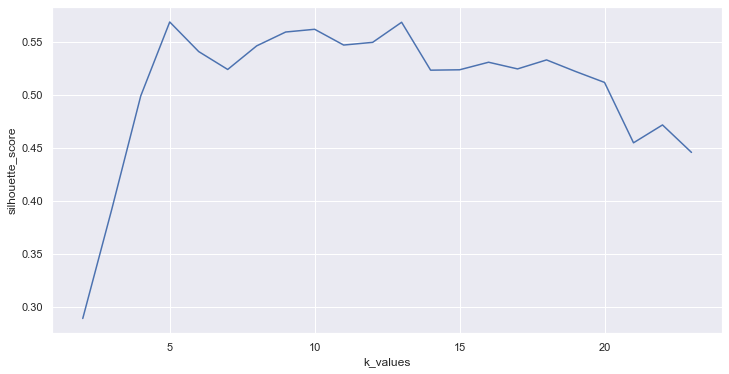

In [31]:
pca_df_all_data, pca_df, gmm_sil_score = cluster_faces_with_GMM(pca_df_all_data, pca_df)

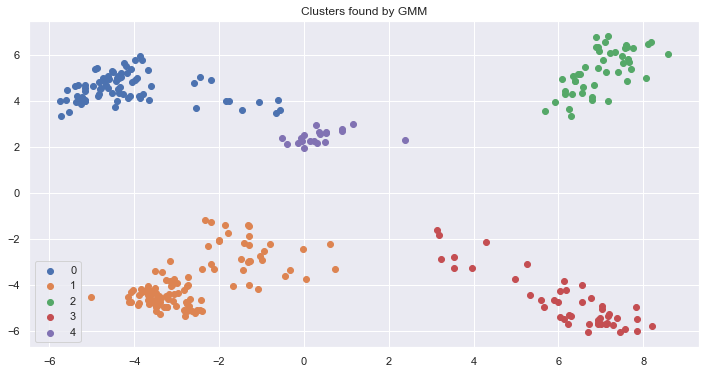

In [32]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "GMM")

### Comparision of Results

In [33]:
print("DBSCAN silhouette_score :", dbscan_sil_score)
print("KMEANS silhouette_score :", kmeans_sil_score)
print("MEANSHIFT silhouette_score :", meanshift_sil_score)
print("HIERARCHICAL silhouette_score :", hierarchical_sil_score)
print("GMM silhouette_score :", gmm_sil_score)

DBSCAN silhouette_score : 0.5893593940763328
KMEANS silhouette_score : 0.5764975365458453
MEANSHIFT silhouette_score : 0.5893593940763328
HIERARCHICAL silhouette_score : 0.5688438883271825
GMM silhouette_score : 0.5688438883271825


In [34]:
clustring_algorithms_results = pd.DataFrame(clustring_algorithms_results)

In [35]:
clustring_algorithms_results

,Name,silhouette_score,num_of_clusters
0,KMEANS,0.576498,12
1,DBSCAN,0.589359,6
2,MEANSHIFT,0.589359,6
3,HIERARCHICAL,0.568844,5
4,GMM,0.568844,5


### Realtime Process

In [50]:
from tensorflow_object_detection import DetectorAPI
from scipy.spatial import distance

object_threshold = 0.98
odapi = DetectorAPI()
vs = cv2.VideoCapture("video.mp4")
rec = []

def draw_faces(image, face):
    (x, y, x1, y1) = [ v for v in face["face_location"]]
    cv2.rectangle(image, (x, y), (x1, y1), (255, 0, 0), 9)
        
def get_person_id(face_encodings, unknown_face_encoding):
    
    face_distances = []
    
    for face_encoding in face_encodings:
        face_distances.append(np.linalg.norm(face_encoding-unknown_face_encoding))
    
    best_match_index = np.argmin(face_distances)
    best_match = pca_df_all_data.iloc[best_match_index]
    
    return best_match

def get_skeletons(image, image_w, image_h):
    skeletons, humans, scale_h = action_recognition.detect_skeletons(image)
    dict_id2skeleton = action_recognition.people_track(skeletons)
    dict_id2label = action_recognition.recognize_action(dict_id2skeleton)

    if(len(skeletons)==0):
        return None, None, None

    centers = []

    for i, human in enumerate(humans):

        allBodyPoints = []
        for i in range(0,18):

            if i not in human.body_parts:
                continue

            if human.body_parts[i].x > 0 and human.body_parts[i].y > 0 :
                pointX = int(human.body_parts[i].x * image_w)
                pointY = int(human.body_parts[i].y * image_h)
                # cv2.circle(frame, (pointX, pointY), radius=10, color=(255, i * 10, i * 5), thickness=15)
                allBodyPoints.append((pointX, pointY))

        center = np.mean(allBodyPoints, axis=0)
        center = (int(center[0]), int(center[1]))
        centers.append(center)
        
    return centers, dict_id2skeleton, dict_id2label

def get_human_action(frame, humanCenter, centers, dict_id2skeleton, dict_id2label):
        
        distances = []
        # cv2.circle(frame, humanCenter, radius=10, color=(0, 0, 255), thickness=15)
        
        for c in centers:
            dis = distance.euclidean(c, humanCenter)
        distances.append(dis)
        best_match_index = np.argmin(distances)
        best_match_skeleton = skeletons[best_match_index]
        
        id = -1
        for key, value in dict_id2skeleton.items():
            if (best_match_skeleton == value).all():
                id = key
                
        label = ''
        if id != -1:        
            label = dict_id2label[id]
                        
        return label

#Loop Video Stream   
while True:

    (grabbed, frame) = vs.read()

    if frame is None:
        break

    image = frame.copy()

    # Class 1 represents human
    persons = odapi.filter_detected_items(1, object_threshold, odapi, frame)
    
    # Visualization of the results of a detection.
    for person in persons:

        # Crop person from image
        y, x, y2, x2 = [ v for v in person["box"]]
        human = frame[y:y2, x:x2]

        # detect_faces
        faces = faceDetection.detect_faces(human, "video.mp4", 0.6)
        
        if(len(faces)==0):
            break
            
        face = faces[0]
        face_id = get_person_id(face_encodings, face["face_encoding"])
        image_w, image_h, _ = frame.shape
            
        centers, dict_id2skeleton, dict_id2label = get_skeletons(frame, image_w, image_h)
        
        if centers is None:
            continue
        
        py, px, py2, px2 = [ v for v in face["face_location"]]
        faceCenter = ( int((px + px2) / 2) , int((py + py2) / 2))
        
        label = get_human_action(frame, faceCenter, centers, dict_id2skeleton, dict_id2label)
            
        date = time.asctime(time.localtime(time.time()))
        
        rec.append({"time": date, "cluster": face_id.cluster, "label": label})
        
        tr = cv2.resize(frame, (300, 300))
        cv2.imshow('camera2',tr) 
        

    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break


cv2.destroyAllWindows()

[2021-03-09 22:49:58,130] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:49:58,130] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:49:58,879] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:49:58,879] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:49:58,891] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-03-09 22:49:58,891] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-03-09 22:49:58,894] [TfPoseEstimator] [INFO] inference image in 0.7640 seconds.
[2021-03-09 22:49:58,894] [TfPoseEstimator] [INFO] inference image in 0.7640 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 0
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3

Mean score:
 [3.44557358e-35 1.83254831e-09 4.84001304e-07 4.67242370e-12
 2.56217977e-06 1.89331667e-06 9.97205020e-01 2.79003906e-03
 3.52866019e-17]


[2021-03-09 22:49:59,349] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:49:59,349] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:49:59,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:49:59,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:49:59,978] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:49:59,978] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:49:59,981] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.
[2021-03-09 22:49:59,981] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 0
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3

Mean score:
 [8.21636429e-42 1.83255730e-09 5.60240666e-07 3.90466428e-14
 2.98237528e-10 2.43765824e-12 9.99999438e-01 1.13644237e-13
 7.56361724e-26]


[2021-03-09 22:50:01,254] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:01,254] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:02,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:02,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:02,081] [TfPoseEstimator] [DEBUG] estimate time=0.05520
[2021-03-09 22:50:02,081] [TfPoseEstimator] [DEBUG] estimate time=0.05520
[2021-03-09 22:50:02,097] [TfPoseEstimator] [INFO] inference image in 0.8431 seconds.
[2021-03-09 22:50:02,097] [TfPoseEstimator] [INFO] inference image in 0.8431 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 0
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [4.17023893e-40 1.23148615e-13 7.68009804e-08 3.95274808e-14
 1.59099113e-10 1.40653055e-11 9.99993368e-01 6.55458660e-06
 1.85411653e-17]


[2021-03-09 22:50:02,921] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:02,921] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:03,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:03,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:03,666] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-03-09 22:50:03,666] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-03-09 22:50:03,669] [TfPoseEstimator] [INFO] inference image in 0.7482 seconds.
[2021-03-09 22:50:03,669] [TfPoseEstimator] [INFO] inference image in 0.7482 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 0
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [7.32979180e-38 1.65237980e-13 5.13014946e-13 1.45416571e-12
 2.88790230e-11 1.05274570e-09 9.99972239e-01 2.77595775e-05
 2.75025843e-15]


[2021-03-09 22:50:04,972] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:04,972] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:06,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:06,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:06,198] [TfPoseEstimator] [DEBUG] estimate time=0.01596
[2021-03-09 22:50:06,198] [TfPoseEstimator] [DEBUG] estimate time=0.01596
[2021-03-09 22:50:06,204] [TfPoseEstimator] [INFO] inference image in 1.2321 seconds.
[2021-03-09 22:50:06,204] [TfPoseEstimator] [INFO] inference image in 1.2321 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 0
num_valid_joints 15 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 4 num_face_joints 0

Mean score:
 [7.79787392e-24 8.94944936e-10 9.82453744e-12 1.45186532e-12
 8.94556797e-11 1.04168676e-09 9.99978780e-01 2.12177431e-05
 6.82609953e-14]

Mean score:
 [1.86679722e-22 3.43707552e-02 2.98859497e-06 1.40372310e-03
 1.68163405e-13 5.09177970e-09 8.19944489e-01 1.44278019e-01
 2.05929154e-08]


[2021-03-09 22:50:07,749] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:07,749] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:08,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:08,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:08,403] [TfPoseEstimator] [DEBUG] estimate time=0.00899
[2021-03-09 22:50:08,403] [TfPoseEstimator] [DEBUG] estimate time=0.00899
[2021-03-09 22:50:08,406] [TfPoseEstimator] [INFO] inference image in 0.6573 seconds.
[2021-03-09 22:50:08,406] [TfPoseEstimator] [INFO] inference image in 0.6573 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [7.79787394e-24 9.01666045e-10 1.79952851e-11 2.06740087e-13
 7.15356162e-11 3.47829840e-11 9.99999974e-01 2.47412873e-08
 6.56531280e-14]

Mean score:
 [9.33398617e-23 1.71854104e-02 1.49586529e-06 7.19786118e-04
 8.54731776e-14 2.25438827e-08 4.59141841e-01 5.22951434e-01
 1.02999976e-08]


[2021-03-09 22:50:09,593] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:09,593] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:10,373] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:10,373] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:10,401] [TfPoseEstimator] [DEBUG] estimate time=0.01594
[2021-03-09 22:50:10,401] [TfPoseEstimator] [DEBUG] estimate time=0.01594
[2021-03-09 22:50:10,405] [TfPoseEstimator] [INFO] inference image in 0.8120 seconds.
[2021-03-09 22:50:10,405] [TfPoseEstimator] [INFO] inference image in 0.8120 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [1.07218256e-32 6.85944411e-12 8.66770524e-12 2.02989719e-13
 3.41506532e-12 3.42051379e-11 9.99999988e-01 1.19892777e-08
 1.23849908e-16]

Mean score:
 [8.02281787e-31 5.86511457e-08 5.83928699e-05 1.81009726e-05
 1.70131321e-12 3.04061620e-08 5.49110984e-01 4.50812434e-01
 3.53991240e-12]


[2021-03-09 22:50:11,545] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:11,545] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:12,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:12,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:12,134] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:12,134] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:12,136] [TfPoseEstimator] [INFO] inference image in 0.5914 seconds.
[2021-03-09 22:50:12,136] [TfPoseEstimator] [INFO] inference image in 0.5914 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [1.96778285e-57 1.71638716e-19 1.25654845e-17 5.80069897e-19
 1.68289877e-20 7.33490593e-18 1.00000000e+00 5.16879503e-15
 1.63031937e-25]

Mean score:
 [1.56415165e-30 4.13078948e-08 5.97526857e-05 3.47535504e-07
 2.33638986e-10 1.63017764e-08 9.99939215e-01 6.27291482e-07
 6.38986373e-15]


[2021-03-09 22:50:13,404] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:13,404] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:14,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:14,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:14,060] [TfPoseEstimator] [DEBUG] estimate time=0.00899
[2021-03-09 22:50:14,060] [TfPoseEstimator] [DEBUG] estimate time=0.00899
[2021-03-09 22:50:14,063] [TfPoseEstimator] [INFO] inference image in 0.6593 seconds.
[2021-03-09 22:50:14,063] [TfPoseEstimator] [INFO] inference image in 0.6593 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [2.59769830e-52 1.69531791e-19 7.12668559e-11 3.82769781e-17
 2.14626771e-14 4.59478991e-11 1.00000000e+00 5.98074849e-15
 1.67823951e-25]

Mean score:
 [4.93881585e-24 2.78853322e-06 5.90060880e-04 1.21882917e-06
 6.66501132e-05 2.69411333e-07 9.99338158e-01 8.53821261e-07
 1.72579366e-14]


[2021-03-09 22:50:15,262] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:15,262] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:16,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:16,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:16,043] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:16,043] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:16,046] [TfPoseEstimator] [INFO] inference image in 0.7844 seconds.
[2021-03-09 22:50:16,046] [TfPoseEstimator] [INFO] inference image in 0.7844 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [2.59767873e-52 1.26543210e-21 7.12668678e-11 3.82760971e-17
 2.14626647e-14 4.59479418e-11 1.00000000e+00 1.96168555e-15
 1.50939966e-24]

Mean score:
 [9.44645627e-24 2.80722573e-06 8.35034942e-04 1.13827015e-06
 1.83709431e-02 3.58156988e-05 9.80691971e-01 6.22894763e-05
 5.11564624e-14]


[2021-03-09 22:50:17,114] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:17,114] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:17,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:17,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:17,747] [TfPoseEstimator] [DEBUG] estimate time=0.00496
[2021-03-09 22:50:17,747] [TfPoseEstimator] [DEBUG] estimate time=0.00496
[2021-03-09 22:50:17,749] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.
[2021-03-09 22:50:17,749] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 2

Mean score:
 [1.12602724e-59 1.08321511e-21 2.18304621e-17 7.52176449e-20
 5.54322640e-21 5.00648616e-17 1.00000000e+00 1.14852739e-15
 1.50425257e-24]

Mean score:
 [4.50882389e-24 3.43293556e-08 1.23656427e-03 9.23425581e-08
 1.70182571e-01 4.69612974e-05 8.28471666e-01 6.21101606e-05
 4.02932687e-14]


[2021-03-09 22:50:23,315] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:23,315] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:23,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:23,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:23,892] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:23,892] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:23,895] [TfPoseEstimator] [INFO] inference image in 0.5805 seconds.
[2021-03-09 22:50:23,895] [TfPoseEstimator] [INFO] inference image in 0.5805 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.89686988e-51 2.28903509e-18 9.37313541e-14 5.90971287e-17
 1.01714372e-15 3.49002566e-14 1.00000000e+00 1.55108189e-14
 1.16430144e-26]

Mean score:
 [1.18190446e-27 5.71751264e-04 9.90375409e-04 3.74148959e-01
 1.51878278e-01 1.14095820e-05 4.68452213e-01 3.94701327e-03
 2.80529166e-11]


[2021-03-09 22:50:25,419] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:25,419] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:26,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:26,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:26,065] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:26,065] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:26,067] [TfPoseEstimator] [INFO] inference image in 0.6483 seconds.
[2021-03-09 22:50:26,067] [TfPoseEstimator] [INFO] inference image in 0.6483 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 9 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [3.29841257e-48 3.20872939e-17 9.37280882e-14 9.54255515e-17
 1.01732823e-15 3.51832676e-14 1.00000000e+00 3.91765772e-10
 2.29686835e-21]


[2021-03-09 22:50:27,110] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:27,110] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:27,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:27,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:27,995] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:27,995] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:27,997] [TfPoseEstimator] [INFO] inference image in 0.8878 seconds.
[2021-03-09 22:50:27,997] [TfPoseEstimator] [INFO] inference image in 0.8878 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [3.29652250e-48 3.45866251e-17 4.59635750e-17 1.58956324e-16
 2.14833916e-19 4.85049926e-15 9.99999999e-01 8.87175513e-10
 3.07079910e-21]

Mean score:
 [3.53876222e-09 9.99998035e-01 6.05374504e-07 5.66217309e-09
 1.01495683e-10 6.42091637e-14 1.34569574e-06 2.29271679e-09
 2.69420303e-09]


[2021-03-09 22:50:29,266] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:29,266] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:29,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:29,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:29,908] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:50:29,908] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:50:29,911] [TfPoseEstimator] [INFO] inference image in 0.6443 seconds.
[2021-03-09 22:50:29,911] [TfPoseEstimator] [INFO] inference image in 0.6443 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [6.80624795e-54 4.84285776e-18 1.51294618e-16 1.32246652e-16
 3.23234642e-20 6.81200097e-15 1.00000000e+00 4.96441647e-10
 7.74386941e-22]

Mean score:
 [4.35985504e-06 9.99992444e-01 1.78805845e-06 7.33857092e-09
 1.46085082e-08 1.01493164e-12 1.36616274e-06 9.81958543e-09
 1.04322145e-08]


[2021-03-09 22:50:31,079] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:31,079] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:31,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:31,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:31,666] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:31,666] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:31,668] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.
[2021-03-09 22:50:31,668] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 0
num_valid_joints 9 num_face_joints 3

Mean score:
 [4.94693799e-57 2.46136967e-19 3.35443943e-16 3.31410323e-16
 3.19846658e-19 1.08275599e-13 1.00000000e+00 3.60841164e-10
 3.66575049e-24]

Mean score:
 [3.15206529e-05 9.99965001e-01 2.31778370e-06 1.21474459e-08
 2.12255755e-08 2.30550808e-12 1.02867487e-06 4.79081079e-08
 5.04537410e-08]


[2021-03-09 22:50:32,938] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:32,938] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:33,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:33,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:33,523] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:50:33,523] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:50:33,524] [TfPoseEstimator] [INFO] inference image in 0.5874 seconds.
[2021-03-09 22:50:33,524] [TfPoseEstimator] [INFO] inference image in 0.5874 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [6.94392293e-57 3.07058720e-19 2.42168169e-16 3.69131384e-16
 3.34359369e-19 1.22630166e-13 9.99999999e-01 6.58410730e-10
 1.77357623e-23]

Mean score:
 [2.93344831e-05 9.99965625e-01 1.40361123e-06 2.06389235e-07
 9.29371144e-09 1.51018275e-11 9.81760661e-07 2.13040578e-06
 3.08637858e-07]


[2021-03-09 22:50:34,609] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:34,609] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:35,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:35,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:35,184] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:50:35,184] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:50:35,186] [TfPoseEstimator] [INFO] inference image in 0.5765 seconds.
[2021-03-09 22:50:35,186] [TfPoseEstimator] [INFO] inference image in 0.5765 seconds.
[2021-03-09 22:50:35,303] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:35,303] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [1.36484727e-56 3.16163139e-19 3.05879762e-17 2.87489546e-16
 6.03861781e-20 6.76356149e-14 9.99999995e-01 5.12888823e-09
 9.76866952e-23]

Mean score:
 [2.39141415e-06 9.99980252e-01 2.24667002e-06 2.06742782e-07
 1.33751202e-08 1.51720141e-11 1.25184798e-05 2.09515189e-06
 2.75850207e-07]


[2021-03-09 22:50:35,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:35,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:35,889] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:35,889] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:35,890] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.
[2021-03-09 22:50:35,890] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [1.26754000e-56 1.76547637e-18 2.02183501e-16 5.57768666e-16
 4.85621036e-20 5.36918489e-14 9.99999995e-01 4.84641862e-09
 8.40179905e-23]

Mean score:
 [2.19577518e-07 5.43535662e-01 6.44401925e-06 5.71374839e-05
 5.60882896e-08 6.26164486e-07 8.43235731e-02 3.71643049e-01
 4.33232447e-04]


[2021-03-09 22:50:36,939] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:36,939] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:37,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:37,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:37,515] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:37,515] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:37,517] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-09 22:50:37,517] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-09 22:50:37,630] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:37,630] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 6 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [2.93265854e-55 5.63650653e-18 1.04589819e-15 1.62752811e-15
 3.88604051e-19 6.27815248e-14 9.99999999e-01 5.08794666e-10
 3.11710908e-23]

Mean score:
 [8.22745196e-11 4.39506128e-02 4.79464765e-06 6.17481258e-05
 4.88509792e-08 6.72070103e-07 2.12307620e-01 7.40388800e-01
 3.28570342e-03]


[2021-03-09 22:50:38,212] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:38,212] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:38,218] [TfPoseEstimator] [DEBUG] estimate time=0.00504
[2021-03-09 22:50:38,218] [TfPoseEstimator] [DEBUG] estimate time=0.00504
[2021-03-09 22:50:38,221] [TfPoseEstimator] [INFO] inference image in 0.5904 seconds.
[2021-03-09 22:50:38,221] [TfPoseEstimator] [INFO] inference image in 0.5904 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 6 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [1.77993045e-54 7.41589415e-18 4.79782727e-15 6.70205152e-15
 7.68373654e-18 4.62163120e-13 9.99999998e-01 1.58255564e-09
 4.98754013e-23]

Mean score:
 [6.94664436e-12 1.06230030e-03 2.63113511e-07 5.13357333e-06
 1.76788365e-07 5.93085183e-07 2.36522692e-01 7.59468967e-01
 2.93987422e-03]


[2021-03-09 22:50:39,295] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:39,295] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:39,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:39,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:39,913] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:50:39,913] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:50:39,918] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.
[2021-03-09 22:50:39,918] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [3.08345640e-54 6.25414904e-18 7.45664906e-15 1.67887313e-14
 1.15289188e-17 6.42129977e-13 9.99999997e-01 2.54627822e-09
 3.37711370e-23]

Mean score:
 [4.66203673e-12 6.89229632e-04 2.56255753e-07 7.25895571e-07
 1.95903318e-07 8.76711558e-07 1.24528266e-01 8.74614112e-01
 1.66337640e-04]


[2021-03-09 22:50:41,220] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:41,220] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:41,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:41,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:41,806] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-09 22:50:41,806] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-09 22:50:41,808] [TfPoseEstimator] [INFO] inference image in 0.5874 seconds.
[2021-03-09 22:50:41,808] [TfPoseEstimator] [INFO] inference image in 0.5874 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 6 num_face_joints 2

Mean score:
 [1.66053089e-54 3.83518133e-18 4.50313934e-15 1.16233129e-14
 4.75243713e-18 2.71332354e-13 9.99999999e-01 1.49288470e-09
 1.68386209e-23]

Mean score:
 [1.40859949e-11 4.32670252e-04 1.22855292e-07 6.12250009e-07
 2.71975706e-07 7.44806084e-07 1.32874641e-01 8.66327984e-01
 3.62952599e-04]


[2021-03-09 22:50:42,940] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:42,940] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:43,513] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:43,513] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:43,518] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:43,518] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:43,520] [TfPoseEstimator] [INFO] inference image in 0.5804 seconds.
[2021-03-09 22:50:43,520] [TfPoseEstimator] [INFO] inference image in 0.5804 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 0
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 6 num_face_joints 2

Mean score:
 [6.48250232e-56 9.56502060e-19 1.01504125e-15 2.97702910e-16
 5.33731969e-19 4.23673047e-14 1.00000000e+00 1.83551137e-10
 4.51220691e-24]

Mean score:
 [2.68233078e-11 9.29980553e-04 6.40082737e-07 1.56872530e-06
 3.83613744e-07 1.83258504e-06 1.41611053e-01 8.57058901e-01
 3.95640372e-04]


[2021-03-09 22:50:44,586] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:44,586] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:45,211] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:45,211] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:45,218] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-09 22:50:45,218] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-09 22:50:45,220] [TfPoseEstimator] [INFO] inference image in 0.6333 seconds.
[2021-03-09 22:50:45,220] [TfPoseEstimator] [INFO] inference image in 0.6333 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 6 num_face_joints 2

Mean score:
 [4.59045800e-59 3.69276853e-20 3.47763511e-17 1.09953800e-16
 1.02563162e-20 1.75789865e-14 1.00000000e+00 2.41863054e-10
 2.63607237e-24]

Mean score:
 [7.13279702e-10 5.16559912e-03 1.93913436e-06 1.50534179e-06
 6.97664297e-05 4.53967830e-06 1.98766037e-01 7.95830574e-01
 1.60038493e-04]


[2021-03-09 22:50:46,356] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:46,356] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:46,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:46,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:46,954] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:50:46,954] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:50:46,956] [TfPoseEstimator] [INFO] inference image in 0.6004 seconds.
[2021-03-09 22:50:46,956] [TfPoseEstimator] [INFO] inference image in 0.6004 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 15 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [7.33746570e-59 6.96240729e-21 7.17318160e-18 3.90518645e-17
 1.12008809e-21 6.53312574e-15 1.00000000e+00 9.48535070e-11
 8.66651985e-25]

Mean score:
 [7.20467525e-10 6.74671738e-03 2.69763239e-06 6.96228106e-07
 4.54279088e-04 8.01108486e-06 5.00598463e-01 4.92135870e-01
 5.32651005e-05]


[2021-03-09 22:50:48,016] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:48,016] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:48,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:48,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:48,606] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:48,606] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:48,608] [TfPoseEstimator] [INFO] inference image in 0.5914 seconds.
[2021-03-09 22:50:48,608] [TfPoseEstimator] [INFO] inference image in 0.5914 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3

Mean score:
 [8.44795764e-52 8.90985038e-21 1.25281582e-16 8.12715057e-20
 9.57896337e-17 1.86745752e-13 1.00000000e+00 9.66958688e-12
 1.55096371e-22]

Mean score:
 [2.06848466e-11 2.11111612e-03 1.29543910e-06 5.20435046e-07
 3.84654464e-04 4.93297564e-06 5.54057675e-01 4.43434750e-01
 5.05641781e-06]


[2021-03-09 22:50:49,722] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:49,722] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:50,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:50,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:50,353] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:50,353] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:50,356] [TfPoseEstimator] [INFO] inference image in 0.6343 seconds.
[2021-03-09 22:50:50,356] [TfPoseEstimator] [INFO] inference image in 0.6343 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [8.44795691e-52 4.78189022e-20 1.23083312e-16 4.69874251e-17
 9.57894337e-17 1.86665772e-13 1.00000000e+00 1.25358591e-11
 1.55037054e-22]

Mean score:
 [2.14055559e-19 4.66455477e-06 4.94148592e-10 2.41426297e-07
 7.55884978e-09 5.05903700e-08 6.37462202e-01 3.62532614e-01
 2.19470031e-07]


[2021-03-09 22:50:51,413] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:51,413] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:52,217] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:52,217] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:52,222] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:52,222] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:52,224] [TfPoseEstimator] [INFO] inference image in 0.8109 seconds.
[2021-03-09 22:50:52,224] [TfPoseEstimator] [INFO] inference image in 0.8109 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 5 num_face_joints 1

Mean score:
 [7.93014176e-64 4.02427304e-20 1.52337555e-18 4.69827146e-17
 6.99105239e-24 2.15610917e-18 1.00000000e+00 2.92405764e-12
 6.58198444e-26]

Mean score:
 [3.14831885e-24 1.11413381e-06 1.95624301e-10 4.30311749e-06
 1.86900676e-11 6.97069961e-09 8.60883899e-01 1.39110655e-01
 2.19496759e-08]


[2021-03-09 22:50:53,275] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:53,275] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:53,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:53,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:53,919] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:53,919] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:53,921] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.
[2021-03-09 22:50:53,921] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.
[2021-03-09 22:50:54,061] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:54,061] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 9 num_face_joints 0
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.84397060e-68 7.26097109e-23 1.99113584e-18 6.38311625e-20
 2.02111579e-22 1.69994337e-17 1.00000000e+00 3.34475563e-15
 1.88369069e-30]

Mean score:
 [7.03773175e-28 1.08264594e-06 2.02035633e-10 4.29167596e-06
 2.58214562e-15 7.64908429e-10 9.49073648e-01 5.09209750e-02
 1.53629302e-09]


[2021-03-09 22:50:54,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:54,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:54,683] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:54,683] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:54,685] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.
[2021-03-09 22:50:54,685] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.


len humans 3
len skeletons 3
num_valid_joints 9 num_face_joints 0
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.19187825e-67 6.74570883e-24 1.56006767e-18 6.38716472e-20
 4.32746128e-22 1.88863884e-17 1.00000000e+00 3.34615604e-15
 3.32192763e-30]

Mean score:
 [1.12743704e-27 7.43891843e-07 4.89684952e-10 8.46626931e-08
 1.53234656e-13 4.38353060e-10 9.97610289e-01 2.38888149e-03
 2.77989041e-11]


[2021-03-09 22:50:55,826] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:55,826] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:56,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:56,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:56,438] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:56,438] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:50:56,440] [TfPoseEstimator] [INFO] inference image in 0.6144 seconds.
[2021-03-09 22:50:56,440] [TfPoseEstimator] [INFO] inference image in 0.6144 seconds.


len humans 3
len skeletons 3
num_valid_joints 9 num_face_joints 0
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.33987460e-67 2.28361770e-24 1.06240481e-18 4.13859080e-23
 2.37247696e-22 1.89428616e-18 1.00000000e+00 1.46593664e-18
 2.41603028e-28]


[2021-03-09 22:50:57,552] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:57,552] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:58,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:58,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:58,218] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-03-09 22:50:58,218] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-03-09 22:50:58,219] [TfPoseEstimator] [INFO] inference image in 0.6672 seconds.
[2021-03-09 22:50:58,219] [TfPoseEstimator] [INFO] inference image in 0.6672 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.93377001e-60 8.78684499e-25 2.16563116e-18 5.11864217e-25
 5.04749119e-26 7.71115240e-21 1.00000000e+00 8.39452141e-20
 9.90478300e-23]


[2021-03-09 22:50:59,326] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:59,326] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:50:59,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:59,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:50:59,929] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-03-09 22:50:59,929] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-03-09 22:50:59,931] [TfPoseEstimator] [INFO] inference image in 0.6044 seconds.
[2021-03-09 22:50:59,931] [TfPoseEstimator] [INFO] inference image in 0.6044 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [9.42610936e-58 3.05746788e-19 1.39103232e-17 6.18548718e-19
 1.67943657e-26 9.81218672e-22 1.00000000e+00 1.71998958e-18
 6.17630607e-22]


[2021-03-09 22:51:01,954] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:01,954] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:02,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:02,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:02,730] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:51:02,730] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:51:02,732] [TfPoseEstimator] [INFO] inference image in 0.7779 seconds.
[2021-03-09 22:51:02,732] [TfPoseEstimator] [INFO] inference image in 0.7779 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 4 num_face_joints 1


[2021-03-09 22:51:03,972] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:03,972] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:04,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:04,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:04,822] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:51:04,822] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:51:04,824] [TfPoseEstimator] [INFO] inference image in 0.8526 seconds.
[2021-03-09 22:51:04,824] [TfPoseEstimator] [INFO] inference image in 0.8526 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 4 num_face_joints 1


[2021-03-09 22:51:05,981] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:05,981] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:06,592] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:06,592] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:06,597] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:51:06,597] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:51:06,599] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.
[2021-03-09 22:51:06,599] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 4 num_face_joints 1


[2021-03-09 22:51:07,701] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:07,701] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:08,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:08,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:08,285] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:51:08,285] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:51:08,287] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.
[2021-03-09 22:51:08,287] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 4 num_face_joints 1


[2021-03-09 22:51:09,385] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:09,385] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:09,971] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:09,971] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:09,976] [TfPoseEstimator] [DEBUG] estimate time=0.00402
[2021-03-09 22:51:09,976] [TfPoseEstimator] [DEBUG] estimate time=0.00402
[2021-03-09 22:51:09,978] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.
[2021-03-09 22:51:09,978] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 1
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 5 num_face_joints 2


[2021-03-09 22:51:11,087] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:11,087] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:11,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:11,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:11,682] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:51:11,682] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:51:11,685] [TfPoseEstimator] [INFO] inference image in 0.5984 seconds.
[2021-03-09 22:51:11,685] [TfPoseEstimator] [INFO] inference image in 0.5984 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 2

Mean score:
 [8.68944887e-34 1.96636711e-11 2.93028453e-12 3.33710875e-11
 9.36084139e-13 3.77834978e-10 9.99932503e-01 6.74962502e-05
 3.03693793e-14]


[2021-03-09 22:51:12,802] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:12,802] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:13,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:13,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:13,414] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:51:13,414] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:51:13,416] [TfPoseEstimator] [INFO] inference image in 0.6134 seconds.
[2021-03-09 22:51:13,416] [TfPoseEstimator] [INFO] inference image in 0.6134 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [8.68945025e-34 1.97499188e-11 2.95269540e-12 4.81523187e-11
 9.37553712e-13 3.92710230e-10 9.99334867e-01 6.65132453e-04
 3.04873769e-14]


[2021-03-09 22:51:15,486] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:15,486] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:16,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:16,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:16,069] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:51:16,069] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:51:16,071] [TfPoseEstimator] [INFO] inference image in 0.5844 seconds.
[2021-03-09 22:51:16,071] [TfPoseEstimator] [INFO] inference image in 0.5844 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [8.03858407e-33 1.05828855e-10 7.86279435e-13 2.09173245e-09
 6.16186387e-13 7.68594264e-11 9.93867107e-01 6.13289061e-03
 1.44895337e-13]


[2021-03-09 22:51:18,267] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:18,267] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:18,847] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:18,847] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:18,853] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:51:18,853] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:51:18,857] [TfPoseEstimator] [INFO] inference image in 0.5904 seconds.
[2021-03-09 22:51:18,857] [TfPoseEstimator] [INFO] inference image in 0.5904 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [9.22612985e-33 1.21478959e-09 1.01397947e-12 6.14865139e-07
 6.14839193e-13 8.76175927e-11 6.80803299e-01 3.19196085e-01
 1.57999513e-12]


[2021-03-09 22:51:23,843] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:23,843] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:24,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:24,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:24,523] [TfPoseEstimator] [DEBUG] estimate time=0.00701
[2021-03-09 22:51:24,523] [TfPoseEstimator] [DEBUG] estimate time=0.00701
[2021-03-09 22:51:24,525] [TfPoseEstimator] [INFO] inference image in 0.6822 seconds.
[2021-03-09 22:51:24,525] [TfPoseEstimator] [INFO] inference image in 0.6822 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.18756032e-33 1.11002603e-09 8.16948551e-13 6.24386141e-07
 7.77748329e-15 5.06275626e-11 6.85135291e-01 3.14864083e-01
 1.43540673e-12]


[2021-03-09 22:51:25,684] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:25,684] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:26,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:26,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:26,359] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:51:26,359] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:51:26,361] [TfPoseEstimator] [INFO] inference image in 0.6762 seconds.
[2021-03-09 22:51:26,361] [TfPoseEstimator] [INFO] inference image in 0.6762 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.84010921e-33 6.71886040e-08 3.69346932e-12 1.73565566e-08
 8.23565531e-15 2.77018579e-11 9.98341093e-01 1.65882206e-03
 5.95433499e-13]


[2021-03-09 22:51:30,549] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:30,549] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:31,163] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:31,163] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:31,168] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:51:31,168] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:51:31,170] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.
[2021-03-09 22:51:31,170] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.84009480e-33 6.71876274e-08 3.12774271e-12 5.87380753e-09
 5.98396941e-16 2.84705570e-12 9.99398084e-01 6.01843036e-04
 5.95244803e-13]


[2021-03-09 22:51:32,308] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:32,308] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:32,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:32,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:32,938] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:51:32,938] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:51:32,940] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.
[2021-03-09 22:51:32,940] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.
[2021-03-09 22:51:33,086] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:33,086] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.29353492e-32 5.63220831e-13 3.88378444e-12 1.15578251e-10
 7.74164455e-12 7.75048636e-09 4.99905133e-01 5.00094859e-01
 7.45219366e-15]


[2021-03-09 22:51:33,718] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:33,718] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:33,724] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:51:33,724] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:51:33,726] [TfPoseEstimator] [INFO] inference image in 0.6408 seconds.
[2021-03-09 22:51:33,726] [TfPoseEstimator] [INFO] inference image in 0.6408 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.29498513e-32 5.64759171e-13 5.62667735e-12 4.70572501e-13
 3.25623251e-09 3.31164009e-07 1.79091245e-02 9.82090541e-01
 9.03250280e-15]

Mean score:
 [1.06673139e-25 2.23192675e-09 1.13081381e-09 8.15578563e-08
 1.63404474e-07 1.20602573e-06 2.14928834e-01 7.85069712e-01
 1.68072668e-11]


[2021-03-09 22:51:34,902] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:34,902] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:35,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:35,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:35,488] [TfPoseEstimator] [DEBUG] estimate time=0.00402
[2021-03-09 22:51:35,488] [TfPoseEstimator] [DEBUG] estimate time=0.00402
[2021-03-09 22:51:35,490] [TfPoseEstimator] [INFO] inference image in 0.5874 seconds.
[2021-03-09 22:51:35,490] [TfPoseEstimator] [INFO] inference image in 0.5874 seconds.
[2021-03-09 22:51:35,606] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:35,606] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.45110863e-35 2.37888610e-14 1.74452731e-12 6.30392688e-12
 3.24870001e-09 3.23425909e-07 4.78967332e-01 5.21032341e-01
 5.51299201e-15]

Mean score:
 [6.53448730e-26 1.12427310e-09 8.02608660e-10 4.10004969e-08
 8.71167922e-08 7.31425871e-07 1.07639054e-01 8.92360084e-01
 8.43929649e-12]


[2021-03-09 22:51:36,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:36,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:36,186] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:51:36,186] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:51:36,188] [TfPoseEstimator] [INFO] inference image in 0.5814 seconds.
[2021-03-09 22:51:36,188] [TfPoseEstimator] [INFO] inference image in 0.5814 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.40352065e-29 5.76228741e-14 2.87483236e-14 6.30475871e-12
 3.98116655e-10 4.59505293e-09 4.64912948e-01 5.35087047e-01
 4.17554024e-14]

Mean score:
 [2.30019696e-26 8.41208566e-12 2.44047827e-10 5.35209415e-09
 5.43661136e-09 1.41437291e-07 1.74685201e-04 9.99825162e-01
 3.90992713e-14]


[2021-03-09 22:51:37,279] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:37,279] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:37,866] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:37,866] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:37,872] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:51:37,872] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:51:37,874] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.
[2021-03-09 22:51:37,874] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.
[2021-03-09 22:51:37,989] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:37,989] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [5.56358573e-27 4.79077858e-14 2.82189288e-14 5.27119240e-12
 3.97907535e-10 4.58347316e-09 3.80333642e-03 9.96196659e-01
 6.89530130e-13]

Mean score:
 [1.43293714e-26 3.54127866e-13 1.52530278e-11 7.57682416e-09
 1.07915129e-10 2.60549250e-08 1.36569842e-06 9.99998601e-01
 7.99558293e-15]


[2021-03-09 22:51:38,570] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:38,570] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:38,576] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:51:38,576] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:51:38,578] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.
[2021-03-09 22:51:38,578] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [5.52979006e-27 1.03650489e-14 8.60872244e-18 1.31284458e-11
 8.25442099e-17 4.78358580e-12 1.82836864e-07 9.99999817e-01
 6.80246715e-13]

Mean score:
 [2.20076772e-25 1.89448732e-12 8.00236468e-11 6.41282281e-09
 1.50723233e-09 9.25105926e-08 3.09448278e-06 9.99996805e-01
 2.29027766e-14]


[2021-03-09 22:51:39,628] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:39,628] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:40,204] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:40,204] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:40,209] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:51:40,209] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:51:40,211] [TfPoseEstimator] [INFO] inference image in 0.5824 seconds.
[2021-03-09 22:51:40,211] [TfPoseEstimator] [INFO] inference image in 0.5824 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [4.27299232e-26 7.27171929e-13 1.12884488e-15 1.34847562e-10
 1.02135073e-15 2.40342024e-11 5.78557682e-07 9.99999421e-01
 1.92677805e-12]

Mean score:
 [2.18619388e-25 1.67616833e-12 7.16436000e-11 4.56910556e-09
 1.42145112e-09 7.97278537e-08 1.79325226e-06 9.99998121e-01
 2.38631734e-14]


[2021-03-09 22:51:43,200] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:43,200] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:43,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:43,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:43,784] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-09 22:51:43,784] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-09 22:51:43,787] [TfPoseEstimator] [INFO] inference image in 0.5874 seconds.
[2021-03-09 22:51:43,787] [TfPoseEstimator] [INFO] inference image in 0.5874 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 0
num_valid_joints 9 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [5.19784859e-26 3.21390923e-12 1.54385960e-12 2.43014573e-10
 2.47837409e-09 4.90216700e-09 5.13193497e-04 9.99486799e-01
 1.95747681e-12]

Mean score:
 [5.15651173e-24 1.30791391e-10 6.07472278e-12 1.13377708e-08
 1.04961708e-11 3.30684389e-09 8.20093237e-04 9.99179892e-01
 2.64603292e-13]


[2021-03-09 22:51:44,993] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:44,993] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:45,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:45,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:45,864] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:51:45,864] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:51:45,868] [TfPoseEstimator] [INFO] inference image in 0.8747 seconds.
[2021-03-09 22:51:45,868] [TfPoseEstimator] [INFO] inference image in 0.8747 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 9 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [9.35274407e-22 1.59998587e-08 4.61656624e-10 7.49708088e-10
 9.87946487e-07 7.90771049e-08 7.57937277e-02 9.24205188e-01
 4.30766483e-11]

Mean score:
 [5.16476482e-24 1.45057520e-10 8.69001008e-10 1.14529137e-08
 3.47827559e-10 8.66010143e-06 5.58855909e-02 9.44105736e-01
 4.75031746e-13]


[2021-03-09 22:51:47,293] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:47,293] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:47,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:47,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:47,911] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:51:47,911] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:51:47,913] [TfPoseEstimator] [INFO] inference image in 0.6199 seconds.
[2021-03-09 22:51:47,913] [TfPoseEstimator] [INFO] inference image in 0.6199 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 9 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [1.01314080e-26 1.43287531e-11 9.86488855e-10 7.29593891e-10
 6.02571456e-09 1.15104466e-05 5.40322627e-01 4.59665854e-01
 2.16164895e-13]


[2021-03-09 22:51:49,089] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:49,089] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:49,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:49,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:49,831] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:51:49,831] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:51:49,834] [TfPoseEstimator] [INFO] inference image in 0.7451 seconds.
[2021-03-09 22:51:49,834] [TfPoseEstimator] [INFO] inference image in 0.7451 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 9 num_face_joints 3

Mean score:
 [3.53157905e-35 1.16429932e-13 6.85138238e-10 1.65363200e-11
 2.56772139e-06 4.74672080e-06 9.82462618e-01 1.75300666e-02
 2.51941263e-16]


[2021-03-09 22:51:53,953] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:53,953] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:54,606] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:54,606] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:54,611] [TfPoseEstimator] [DEBUG] estimate time=0.00453
[2021-03-09 22:51:54,611] [TfPoseEstimator] [DEBUG] estimate time=0.00453
[2021-03-09 22:51:54,613] [TfPoseEstimator] [INFO] inference image in 0.6605 seconds.
[2021-03-09 22:51:54,613] [TfPoseEstimator] [INFO] inference image in 0.6605 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [5.36269562e-31 1.20449663e-13 2.72086923e-09 5.41412434e-12
 2.33022038e-05 8.30922920e-06 9.96867034e-01 3.10135134e-03
 5.17156711e-17]


[2021-03-09 22:51:55,821] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:55,821] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:51:56,525] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:56,525] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:51:56,531] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-03-09 22:51:56,531] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-03-09 22:51:56,534] [TfPoseEstimator] [INFO] inference image in 0.7130 seconds.
[2021-03-09 22:51:56,534] [TfPoseEstimator] [INFO] inference image in 0.7130 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [2.12473643e-30 4.85555405e-13 2.08460136e-08 3.22377853e-12
 2.86715330e-05 1.94704669e-05 9.99578904e-01 3.72932917e-04
 4.16666474e-17]


[2021-03-09 22:52:04,195] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:04,195] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:05,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:05,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:05,127] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:52:05,127] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:52:05,130] [TfPoseEstimator] [INFO] inference image in 0.9343 seconds.
[2021-03-09 22:52:05,130] [TfPoseEstimator] [INFO] inference image in 0.9343 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [1.74728317e-30 1.18095767e-12 1.87728574e-08 9.54894603e-12
 7.94667874e-06 1.30960005e-05 9.99818671e-01 1.60267438e-04
 2.52020203e-16]


[2021-03-09 22:52:06,374] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:06,374] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:07,064] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:07,064] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:07,070] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:52:07,070] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:52:07,073] [TfPoseEstimator] [INFO] inference image in 0.6984 seconds.
[2021-03-09 22:52:07,073] [TfPoseEstimator] [INFO] inference image in 0.6984 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [1.80567116e-31 5.04179314e-12 6.89019232e-09 3.62055314e-11
 1.17756538e-07 1.97542053e-06 9.99743827e-01 2.54072454e-04
 3.79785336e-16]


[2021-03-09 22:52:08,279] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:08,279] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:08,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:08,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:08,896] [TfPoseEstimator] [DEBUG] estimate time=0.00502
[2021-03-09 22:52:08,896] [TfPoseEstimator] [DEBUG] estimate time=0.00502
[2021-03-09 22:52:08,898] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.
[2021-03-09 22:52:08,898] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [2.17858060e-32 4.40010349e-12 7.53909513e-09 3.15283701e-11
 1.05797945e-07 2.26275310e-06 9.99763526e-01 2.34097778e-04
 1.55336978e-16]


[2021-03-09 22:52:09,991] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:09,991] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:10,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:10,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:10,601] [TfPoseEstimator] [DEBUG] estimate time=0.00401
[2021-03-09 22:52:10,601] [TfPoseEstimator] [DEBUG] estimate time=0.00401
[2021-03-09 22:52:10,603] [TfPoseEstimator] [INFO] inference image in 0.6124 seconds.
[2021-03-09 22:52:10,603] [TfPoseEstimator] [INFO] inference image in 0.6124 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [4.56535107e-34 1.08214892e-13 1.65044163e-09 2.40842759e-12
 3.75088447e-06 7.23019495e-07 9.99916231e-01 7.92930028e-05
 3.49199585e-18]


[2021-03-09 22:52:11,704] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:11,704] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:12,310] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:12,310] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:12,316] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:12,316] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:12,318] [TfPoseEstimator] [INFO] inference image in 0.6144 seconds.
[2021-03-09 22:52:12,318] [TfPoseEstimator] [INFO] inference image in 0.6144 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [1.05687523e-33 2.32423273e-14 3.19141719e-08 7.37178695e-13
 1.48827692e-04 2.60938012e-05 9.99803035e-01 2.20116750e-05
 1.27111773e-18]


[2021-03-09 22:52:13,408] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:13,408] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:14,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:14,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:14,014] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-09 22:52:14,014] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-09 22:52:14,016] [TfPoseEstimator] [INFO] inference image in 0.6074 seconds.
[2021-03-09 22:52:14,016] [TfPoseEstimator] [INFO] inference image in 0.6074 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 6 num_face_joints 1

Mean score:
 [1.08011963e-33 5.01272431e-15 4.36840757e-08 1.32411818e-12
 1.54467866e-04 5.11731891e-05 9.99730076e-01 6.42393969e-05
 3.94407009e-19]


[2021-03-09 22:52:15,104] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:15,104] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:15,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:15,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:15,709] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:15,709] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:15,711] [TfPoseEstimator] [INFO] inference image in 0.6074 seconds.
[2021-03-09 22:52:15,711] [TfPoseEstimator] [INFO] inference image in 0.6074 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 5 num_face_joints 1

Mean score:
 [4.37959348e-32 2.55562661e-14 1.38574764e-08 5.05883939e-12
 1.09765576e-05 2.79255670e-05 9.99775392e-01 1.85691994e-04
 7.49467228e-18]


[2021-03-09 22:52:16,793] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:16,793] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:17,400] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:17,400] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:17,409] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:52:17,409] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:52:17,411] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.
[2021-03-09 22:52:17,411] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.
[2021-03-09 22:52:17,552] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:17,552] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 5 num_face_joints 1

Mean score:
 [5.15583651e-32 5.48862189e-14 1.85081226e-08 5.34891465e-12
 8.03541035e-06 5.29094208e-06 9.99836820e-01 1.49834836e-04
 7.38605527e-18]


[2021-03-09 22:52:18,165] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:18,165] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:18,173] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:52:18,173] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:52:18,175] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.
[2021-03-09 22:52:18,175] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 5 num_face_joints 1

Mean score:
 [8.24987465e-33 3.45912418e-14 1.86528872e-08 1.45477772e-12
 6.76197093e-06 4.63734747e-06 9.99936945e-01 5.16368842e-05
 3.80550736e-19]


[2021-03-09 22:52:19,253] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:19,253] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:19,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:19,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:19,863] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:19,863] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:19,865] [TfPoseEstimator] [INFO] inference image in 0.6124 seconds.
[2021-03-09 22:52:19,865] [TfPoseEstimator] [INFO] inference image in 0.6124 seconds.
[2021-03-09 22:52:19,995] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:19,995] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 6 num_face_joints 1

Mean score:
 [6.07018793e-34 8.23509511e-15 9.83641091e-09 1.75809580e-11
 6.87263919e-06 7.24441506e-06 9.99835653e-01 1.50219887e-04
 9.14312748e-19]


[2021-03-09 22:52:20,616] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:20,616] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:20,625] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:52:20,625] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:52:20,627] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.
[2021-03-09 22:52:20,627] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 6 num_face_joints 1

Mean score:
 [7.74884567e-34 7.61054616e-15 1.91200590e-08 1.96459969e-11
 1.53742294e-05 1.72040943e-05 9.99815052e-01 1.52350918e-04
 8.72407151e-19]


[2021-03-09 22:52:21,795] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:21,795] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:22,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:22,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:22,445] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:52:22,445] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:52:22,448] [TfPoseEstimator] [INFO] inference image in 0.6533 seconds.
[2021-03-09 22:52:22,448] [TfPoseEstimator] [INFO] inference image in 0.6533 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 7 num_face_joints 1

Mean score:
 [2.09907402e-34 2.16866157e-15 1.26122167e-08 4.07338798e-12
 1.25830189e-05 1.72198398e-05 9.99865631e-01 1.04553834e-04
 3.18813195e-19]


[2021-03-09 22:52:23,599] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:23,599] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:24,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:24,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:24,216] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:52:24,216] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:52:24,218] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.
[2021-03-09 22:52:24,218] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.
[2021-03-09 22:52:24,350] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:24,350] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 1
num_valid_joints 9 num_face_joints 3

Mean score:
 [9.21458121e-34 4.68984267e-15 1.41144029e-08 6.24388136e-12
 1.43421876e-05 3.09163487e-05 9.99615010e-01 3.39717168e-04
 9.60131109e-19]


[2021-03-09 22:52:24,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:24,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:24,976] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:24,976] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:24,978] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.
[2021-03-09 22:52:24,978] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 1
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.92532758e-27 4.01876771e-01 8.18113128e-06 1.67942165e-08
 1.52829445e-13 3.10514025e-10 5.97561447e-01 5.53583852e-04
 2.71046624e-11]

Mean score:
 [9.76082452e-34 6.11729485e-15 2.84185345e-08 1.99919372e-11
 1.40658968e-05 8.72048924e-05 9.98230033e-01 1.66866755e-03
 1.49135308e-18]


[2021-03-09 22:52:26,063] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:26,063] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:26,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:26,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:26,672] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:26,672] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:26,674] [TfPoseEstimator] [INFO] inference image in 0.6114 seconds.
[2021-03-09 22:52:26,674] [TfPoseEstimator] [INFO] inference image in 0.6114 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 7 num_face_joints 3
num_valid_joints 5 num_face_joints 1

Mean score:
 [1.31366094e-32 3.09732562e-14 2.19907181e-08 2.59346462e-11
 5.25541659e-06 7.45752264e-05 9.97433351e-01 2.48679645e-03
 6.73719977e-18]


[2021-03-09 22:52:28,705] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:28,705] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:29,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:29,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:29,325] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:29,325] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:29,329] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.
[2021-03-09 22:52:29,329] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.


len humans 3
len skeletons 3
num_valid_joints 15 num_face_joints 4
num_valid_joints 7 num_face_joints 1
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.12422361e-31 4.61051347e-13 6.57450335e-09 1.35145211e-10
 1.78774623e-06 1.32849197e-05 9.97797808e-01 2.18711304e-03
 6.39593449e-17]


[2021-03-09 22:52:30,404] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:30,404] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:30,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:30,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:31,005] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:52:31,005] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:52:31,007] [TfPoseEstimator] [INFO] inference image in 0.6024 seconds.
[2021-03-09 22:52:31,007] [TfPoseEstimator] [INFO] inference image in 0.6024 seconds.


len humans 3
len skeletons 3
num_valid_joints 15 num_face_joints 4
num_valid_joints 7 num_face_joints 1
num_valid_joints 7 num_face_joints 3

Mean score:
 [1.99952071e-31 6.68817694e-13 5.06982907e-08 1.07502785e-09
 8.93119758e-08 2.69266353e-06 9.98396232e-01 1.60093475e-03
 5.90802449e-17]


[2021-03-09 22:52:32,071] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:32,071] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:32,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:32,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:32,677] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:32,677] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:52:32,679] [TfPoseEstimator] [INFO] inference image in 0.6084 seconds.
[2021-03-09 22:52:32,679] [TfPoseEstimator] [INFO] inference image in 0.6084 seconds.


len humans 4
len skeletons 4
num_valid_joints 15 num_face_joints 4
num_valid_joints 7 num_face_joints 1
num_valid_joints 5 num_face_joints 0
num_valid_joints 7 num_face_joints 3

Mean score:
 [1.77618972e-33 5.09385354e-13 1.25115818e-07 1.15012788e-09
 6.45668549e-07 1.82765726e-05 9.96720295e-01 3.26065694e-03
 8.25934690e-18]


[2021-03-09 22:52:33,764] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:33,764] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:34,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:34,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:34,366] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:52:34,366] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:52:34,368] [TfPoseEstimator] [INFO] inference image in 0.6034 seconds.
[2021-03-09 22:52:34,368] [TfPoseEstimator] [INFO] inference image in 0.6034 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 1
num_valid_joints 6 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [4.59072132e-32 4.03498669e-13 1.13199409e-07 9.90068096e-10
 2.45876838e-05 9.98009954e-05 9.62799506e-01 3.70759915e-02
 1.16430240e-16]


[2021-03-09 22:52:35,445] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:35,445] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:36,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:36,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:36,054] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:52:36,054] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:52:36,056] [TfPoseEstimator] [INFO] inference image in 0.6114 seconds.
[2021-03-09 22:52:36,056] [TfPoseEstimator] [INFO] inference image in 0.6114 seconds.
[2021-03-09 22:52:36,191] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:36,191] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 1
num_valid_joints 7 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [6.15027152e-32 2.15429631e-13 5.32737316e-08 1.08243481e-09
 2.56024889e-05 9.92448595e-05 9.62264324e-01 3.76107741e-02
 1.27053055e-16]


[2021-03-09 22:52:36,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:36,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:36,822] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:52:36,822] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:52:36,825] [TfPoseEstimator] [INFO] inference image in 0.6343 seconds.
[2021-03-09 22:52:36,825] [TfPoseEstimator] [INFO] inference image in 0.6343 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 1
num_valid_joints 7 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [1.75516365e-32 1.00122290e-13 2.94310101e-08 3.50113483e-10
 2.19584748e-06 3.39925001e-05 9.94413953e-01 5.54982903e-03
 2.05305760e-17]


[2021-03-09 22:52:41,435] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:41,435] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:42,069] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:42,069] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:42,078] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:52:42,078] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:52:42,080] [TfPoseEstimator] [INFO] inference image in 0.6443 seconds.
[2021-03-09 22:52:42,080] [TfPoseEstimator] [INFO] inference image in 0.6443 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 0
num_valid_joints 6 num_face_joints 0
num_valid_joints 5 num_face_joints 2

Mean score:
 [3.42639008e-32 6.70252294e-13 4.62286773e-08 1.11694446e-09
 6.81606041e-07 1.98139449e-05 9.97526470e-01 2.45298727e-03
 7.92777260e-18]


[2021-03-09 22:52:43,449] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:43,449] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:44,628] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:44,628] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:44,636] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:52:44,636] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:52:44,639] [TfPoseEstimator] [INFO] inference image in 1.1885 seconds.
[2021-03-09 22:52:44,639] [TfPoseEstimator] [INFO] inference image in 1.1885 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 9 num_face_joints 0
num_valid_joints 5 num_face_joints 2

Mean score:
 [3.49955150e-32 7.56401567e-13 1.58190538e-07 2.26339595e-09
 1.42910731e-06 4.97905722e-05 9.94895898e-01 5.05272209e-03
 1.00659818e-17]


[2021-03-09 22:52:45,707] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:45,707] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:46,291] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:46,291] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:46,297] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:52:46,297] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:52:46,299] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.
[2021-03-09 22:52:46,299] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.
[2021-03-09 22:52:46,413] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:46,413] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 6 num_face_joints 2
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.52183325e-33 1.25167915e-13 2.32773173e-07 1.95970830e-09
 2.51903466e-06 1.18567944e-04 9.89232728e-01 1.06459499e-02
 6.83756219e-18]


[2021-03-09 22:52:47,007] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:47,007] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:47,016] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:52:47,016] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:52:47,019] [TfPoseEstimator] [INFO] inference image in 0.6054 seconds.
[2021-03-09 22:52:47,019] [TfPoseEstimator] [INFO] inference image in 0.6054 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 6 num_face_joints 2
num_valid_joints 9 num_face_joints 0

Mean score:
 [6.20992916e-34 3.57157930e-14 2.88699655e-07 8.93171172e-10
 2.71687870e-05 1.74447626e-04 9.93220404e-01 6.57768962e-03
 2.69407793e-18]


[2021-03-09 22:52:48,333] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:48,333] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:48,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:48,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:48,954] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:52:48,954] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:52:48,956] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.
[2021-03-09 22:52:48,956] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 5 num_face_joints 1
num_valid_joints 8 num_face_joints 0

Mean score:
 [9.57333948e-33 5.15076252e-14 1.94758622e-07 2.13957730e-10
 2.63304842e-05 1.07431366e-04 9.98847781e-01 1.01826260e-03
 2.21002502e-18]


[2021-03-09 22:52:50,015] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:50,015] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:50,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:50,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:50,631] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:52:50,631] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:52:50,633] [TfPoseEstimator] [INFO] inference image in 0.6174 seconds.
[2021-03-09 22:52:50,633] [TfPoseEstimator] [INFO] inference image in 0.6174 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 6 num_face_joints 1
num_valid_joints 8 num_face_joints 0

Mean score:
 [9.09355102e-33 4.53279112e-14 1.54351311e-08 1.44521327e-10
 4.12387129e-07 4.36588448e-06 9.99503912e-01 4.91294005e-04
 1.91432828e-18]


[2021-03-09 22:52:51,683] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:51,683] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:52,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:52,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:52,277] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:52:52,277] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:52:52,279] [TfPoseEstimator] [INFO] inference image in 0.5964 seconds.
[2021-03-09 22:52:52,279] [TfPoseEstimator] [INFO] inference image in 0.5964 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 7 num_face_joints 0
num_valid_joints 6 num_face_joints 2

Mean score:
 [1.09159856e-34 7.87775771e-15 1.31693287e-07 2.52762987e-10
 6.01219389e-07 3.89659560e-06 9.99717832e-01 2.77538681e-04
 5.24779014e-19]


[2021-03-09 22:52:53,422] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:53,422] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:54,165] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:54,165] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:54,192] [TfPoseEstimator] [DEBUG] estimate time=0.01363
[2021-03-09 22:52:54,192] [TfPoseEstimator] [DEBUG] estimate time=0.01363
[2021-03-09 22:52:54,195] [TfPoseEstimator] [INFO] inference image in 0.7731 seconds.
[2021-03-09 22:52:54,195] [TfPoseEstimator] [INFO] inference image in 0.7731 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 8 num_face_joints 0

Mean score:
 [2.00358524e-36 4.10803609e-15 1.87728994e-07 6.60804667e-10
 1.57814892e-06 2.71054143e-05 9.99000077e-01 9.71051231e-04
 1.15908173e-19]


[2021-03-09 22:52:56,927] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:56,927] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:52:57,641] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:57,641] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:52:57,649] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:52:57,649] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:52:57,652] [TfPoseEstimator] [INFO] inference image in 0.7251 seconds.
[2021-03-09 22:52:57,652] [TfPoseEstimator] [INFO] inference image in 0.7251 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.68834455e-36 2.35494546e-15 7.61611536e-08 7.00081988e-10
 2.95991420e-06 7.78798930e-05 9.98502039e-01 1.41704439e-03
 1.63794862e-19]


[2021-03-09 22:53:03,379] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:03,379] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:04,027] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:04,027] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:04,035] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:53:04,035] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:53:04,038] [TfPoseEstimator] [INFO] inference image in 0.6592 seconds.
[2021-03-09 22:53:04,038] [TfPoseEstimator] [INFO] inference image in 0.6592 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 7 num_face_joints 0

Mean score:
 [6.54605976e-38 3.32938797e-16 2.14518034e-08 2.98903042e-09
 1.90603583e-06 5.96765865e-05 9.99134685e-01 8.03707734e-04
 1.03014626e-19]


[2021-03-09 22:53:05,248] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:05,248] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:06,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:06,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:06,099] [TfPoseEstimator] [DEBUG] estimate time=0.00402
[2021-03-09 22:53:06,099] [TfPoseEstimator] [DEBUG] estimate time=0.00402
[2021-03-09 22:53:06,102] [TfPoseEstimator] [INFO] inference image in 0.8537 seconds.
[2021-03-09 22:53:06,102] [TfPoseEstimator] [INFO] inference image in 0.8537 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 0
num_valid_joints 9 num_face_joints 0

Mean score:
 [2.63906127e-39 1.11482727e-15 6.48996305e-09 3.00561878e-09
 4.91882077e-09 6.78445045e-06 9.99590975e-01 4.02226334e-04
 6.75199846e-20]


[2021-03-09 22:53:07,189] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:07,189] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:07,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:07,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:07,784] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:07,784] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:07,786] [TfPoseEstimator] [INFO] inference image in 0.5974 seconds.
[2021-03-09 22:53:07,786] [TfPoseEstimator] [INFO] inference image in 0.5974 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0
num_valid_joints 7 num_face_joints 0

Mean score:
 [1.93300298e-39 1.75129096e-15 1.78387769e-08 2.64225094e-10
 1.51004822e-09 6.20671749e-06 9.99898656e-01 9.51176251e-05
 3.17883410e-20]


[2021-03-09 22:53:08,891] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:08,891] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:09,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:09,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:09,568] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:53:09,568] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:53:09,570] [TfPoseEstimator] [INFO] inference image in 0.6782 seconds.
[2021-03-09 22:53:09,570] [TfPoseEstimator] [INFO] inference image in 0.6782 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 0
num_valid_joints 10 num_face_joints 0

Mean score:
 [2.87677404e-39 9.51180459e-16 3.78720985e-08 6.51933454e-11
 1.05883100e-07 1.01480755e-05 9.99938075e-01 5.16327238e-05
 1.72662975e-20]


[2021-03-09 22:53:10,733] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:10,733] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:11,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:11,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:11,360] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-09 22:53:11,360] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-09 22:53:11,363] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.
[2021-03-09 22:53:11,363] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 0
num_valid_joints 8 num_face_joints 0

Mean score:
 [2.81797413e-37 5.02103093e-16 5.89498989e-08 6.18615588e-11
 5.06865253e-07 7.62148646e-06 9.99979515e-01 1.22974940e-05
 2.62452768e-21]


[2021-03-09 22:53:12,621] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:12,621] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:13,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:13,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:13,214] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:13,214] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:13,216] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.
[2021-03-09 22:53:13,216] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0
num_valid_joints 9 num_face_joints 0

Mean score:
 [3.24133306e-37 5.16775805e-16 3.70232192e-08 2.12491330e-11
 4.36645404e-07 3.20827535e-06 9.99989743e-01 6.57532361e-06
 1.95912488e-21]


[2021-03-09 22:53:14,311] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:14,311] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:14,892] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:14,892] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:14,898] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:14,898] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:14,900] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.
[2021-03-09 22:53:14,900] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 9 num_face_joints 0

Mean score:
 [4.04138271e-35 2.61213195e-16 5.36469609e-08 8.29643758e-13
 6.63526505e-05 4.71393486e-07 9.99933047e-01 7.50629027e-08
 4.34105504e-22]


[2021-03-09 22:53:16,001] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:16,001] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:16,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:16,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:16,606] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:16,606] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:16,608] [TfPoseEstimator] [INFO] inference image in 0.6074 seconds.
[2021-03-09 22:53:16,608] [TfPoseEstimator] [INFO] inference image in 0.6074 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 8 num_face_joints 0

Mean score:
 [4.04952755e-35 2.12960640e-16 5.35591270e-08 1.37168232e-11
 6.65479624e-05 1.26097035e-06 9.99889618e-01 4.25198782e-05
 1.59276778e-20]


[2021-03-09 22:53:17,707] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:17,707] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:18,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:18,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:18,304] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:18,304] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:18,305] [TfPoseEstimator] [INFO] inference image in 0.5984 seconds.
[2021-03-09 22:53:18,305] [TfPoseEstimator] [INFO] inference image in 0.5984 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0
num_valid_joints 10 num_face_joints 0

Mean score:
 [1.25932817e-37 6.29934370e-17 3.24797349e-09 3.91122888e-11
 3.03830883e-07 1.35098460e-06 9.99954987e-01 4.33552881e-05
 1.65283285e-20]


[2021-03-09 22:53:19,412] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:19,412] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:19,999] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:19,999] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:20,004] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:20,004] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:20,006] [TfPoseEstimator] [INFO] inference image in 0.5944 seconds.
[2021-03-09 22:53:20,006] [TfPoseEstimator] [INFO] inference image in 0.5944 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 10 num_face_joints 0

Mean score:
 [1.61641750e-39 3.24485806e-17 9.51653328e-09 2.60819880e-11
 1.47395656e-07 6.07875190e-07 9.99998378e-01 8.57146619e-07
 8.11044050e-22]


[2021-03-09 22:53:21,076] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:21,076] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:21,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:21,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:21,657] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:21,657] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:21,659] [TfPoseEstimator] [INFO] inference image in 0.5824 seconds.
[2021-03-09 22:53:21,659] [TfPoseEstimator] [INFO] inference image in 0.5824 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.04431396e-38 4.38051773e-17 1.13214029e-08 1.41752344e-13
 1.73729860e-07 6.09520614e-08 9.99999750e-01 4.30385942e-09
 1.10922629e-23]


[2021-03-09 22:53:22,747] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:22,747] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:23,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:23,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:23,329] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-09 22:53:23,329] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-09 22:53:23,331] [TfPoseEstimator] [INFO] inference image in 0.5835 seconds.
[2021-03-09 22:53:23,331] [TfPoseEstimator] [INFO] inference image in 0.5835 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0

Mean score:
 [2.39538951e-35 3.25977772e-16 1.97031205e-08 1.56845254e-12
 2.08449717e-06 3.98066358e-08 9.99997845e-01 1.05389688e-08
 1.09092406e-22]


[2021-03-09 22:53:24,437] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:24,437] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:25,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:25,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:25,096] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:25,096] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:25,098] [TfPoseEstimator] [INFO] inference image in 0.6612 seconds.
[2021-03-09 22:53:25,098] [TfPoseEstimator] [INFO] inference image in 0.6612 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 1

Mean score:
 [5.83742413e-35 8.74030597e-16 1.62166690e-08 4.54121669e-12
 2.13932226e-06 5.60438307e-08 9.99997618e-01 1.70448057e-07
 2.02002808e-21]


[2021-03-09 22:53:26,211] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:26,211] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:26,837] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:26,837] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:26,843] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:26,843] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:26,845] [TfPoseEstimator] [INFO] inference image in 0.6333 seconds.
[2021-03-09 22:53:26,845] [TfPoseEstimator] [INFO] inference image in 0.6333 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0

Mean score:
 [3.48242904e-35 7.64181757e-16 6.51382494e-09 4.58955217e-12
 3.58312296e-07 6.19724284e-08 9.99999387e-01 1.86226989e-07
 2.21989504e-21]


[2021-03-09 22:53:27,940] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:27,940] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:28,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:28,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:28,547] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:28,547] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:28,550] [TfPoseEstimator] [INFO] inference image in 0.6104 seconds.
[2021-03-09 22:53:28,550] [TfPoseEstimator] [INFO] inference image in 0.6104 seconds.


len humans 3
len skeletons 3
num_valid_joints 9 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 0

Mean score:
 [3.95130897e-37 2.20283522e-16 5.72478877e-09 2.60618998e-12
 2.04390520e-07 1.14099529e-07 9.99998691e-01 9.84928371e-07
 1.96703608e-21]


[2021-03-09 22:53:29,628] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:29,628] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:30,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:30,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:30,284] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-09 22:53:30,284] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-09 22:53:30,287] [TfPoseEstimator] [INFO] inference image in 0.6592 seconds.
[2021-03-09 22:53:30,287] [TfPoseEstimator] [INFO] inference image in 0.6592 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.41744568e-39 3.11227198e-17 4.01425201e-10 1.21631734e-12
 9.34957554e-08 8.01650983e-08 9.99998861e-01 9.64588631e-07
 1.67951884e-21]


[2021-03-09 22:53:31,431] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:31,431] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:32,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:32,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:32,027] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:32,027] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:32,029] [TfPoseEstimator] [INFO] inference image in 0.5974 seconds.
[2021-03-09 22:53:32,029] [TfPoseEstimator] [INFO] inference image in 0.5974 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 0

Mean score:
 [9.16163677e-36 4.15474774e-17 4.76806720e-08 2.23851680e-13
 2.23279329e-05 3.06789217e-07 9.99977311e-01 6.96841151e-09
 3.21770852e-23]


[2021-03-09 22:53:33,120] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:33,120] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:33,747] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:33,747] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:33,753] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:33,753] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:33,755] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.
[2021-03-09 22:53:33,755] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 9 num_face_joints 0

Mean score:
 [4.37452675e-35 3.41288243e-16 4.75007574e-08 9.57451022e-14
 2.22498485e-05 3.02478634e-07 9.99976926e-01 4.73956739e-07
 7.64005871e-21]


[2021-03-09 22:53:34,903] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:34,903] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:35,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:35,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:35,523] [TfPoseEstimator] [DEBUG] estimate time=0.00553
[2021-03-09 22:53:35,523] [TfPoseEstimator] [DEBUG] estimate time=0.00553
[2021-03-09 22:53:35,529] [TfPoseEstimator] [INFO] inference image in 0.6259 seconds.
[2021-03-09 22:53:35,529] [TfPoseEstimator] [INFO] inference image in 0.6259 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0

Mean score:
 [7.55299009e-34 6.25290172e-16 1.09446340e-09 9.50796903e-13
 4.65432801e-07 5.20559919e-08 9.99998848e-01 6.33454534e-07
 1.25602427e-20]


[2021-03-09 22:53:36,684] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:36,684] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:37,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:37,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:37,291] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:37,291] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:37,293] [TfPoseEstimator] [INFO] inference image in 0.6094 seconds.
[2021-03-09 22:53:37,293] [TfPoseEstimator] [INFO] inference image in 0.6094 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [7.52200025e-34 1.81091459e-15 6.44263376e-08 3.45128314e-12
 1.23874884e-06 2.10725687e-07 9.99998270e-01 2.16502188e-07
 5.42782115e-21]


[2021-03-09 22:53:38,382] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:38,382] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:38,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:38,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:38,968] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:38,968] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:38,969] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.
[2021-03-09 22:53:38,969] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0

Mean score:
 [5.06376083e-34 3.36726380e-15 6.81745096e-08 9.81389408e-12
 1.52704148e-06 1.16484168e-06 9.99969386e-01 2.78534720e-05
 1.00069641e-19]


[2021-03-09 22:53:40,059] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:40,059] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:40,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:40,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:40,660] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:53:40,660] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:53:40,662] [TfPoseEstimator] [INFO] inference image in 0.6034 seconds.
[2021-03-09 22:53:40,662] [TfPoseEstimator] [INFO] inference image in 0.6034 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 8 num_face_joints 0
num_valid_joints 13 num_face_joints 3

Mean score:
 [4.76583853e-34 1.89415405e-15 5.13275757e-09 7.51091497e-12
 1.72217844e-06 1.79220952e-06 9.99964576e-01 3.19047735e-05
 1.08100867e-19]


[2021-03-09 22:53:41,820] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:41,820] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:42,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:42,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:42,462] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-09 22:53:42,462] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-09 22:53:42,464] [TfPoseEstimator] [INFO] inference image in 0.6433 seconds.
[2021-03-09 22:53:42,464] [TfPoseEstimator] [INFO] inference image in 0.6433 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [6.83991522e-36 1.99132199e-17 1.19919186e-09 4.14981167e-13
 6.40451601e-06 9.57659007e-07 9.99988454e-01 4.18245621e-06
 8.81693514e-21]


[2021-03-09 22:53:43,589] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:43,589] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:44,180] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:44,180] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:44,186] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:44,186] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:44,188] [TfPoseEstimator] [INFO] inference image in 0.5994 seconds.
[2021-03-09 22:53:44,188] [TfPoseEstimator] [INFO] inference image in 0.5994 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [9.20148582e-35 1.20832174e-16 6.00838725e-09 2.15718960e-13
 7.02989437e-06 2.26077616e-07 9.99992651e-01 8.73433882e-08
 4.54902600e-22]


[2021-03-09 22:53:45,311] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:45,311] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:45,897] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:45,897] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:45,902] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-09 22:53:45,902] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-09 22:53:45,905] [TfPoseEstimator] [INFO] inference image in 0.5944 seconds.
[2021-03-09 22:53:45,905] [TfPoseEstimator] [INFO] inference image in 0.5944 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [2.19106065e-34 1.23024469e-15 5.31649274e-09 1.04492388e-12
 1.64448517e-06 1.13123756e-07 9.99986127e-01 1.21100844e-05
 2.91952779e-20]


[2021-03-09 22:53:46,992] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:46,992] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:47,573] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:47,573] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:47,578] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:47,578] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:47,580] [TfPoseEstimator] [INFO] inference image in 0.5884 seconds.
[2021-03-09 22:53:47,580] [TfPoseEstimator] [INFO] inference image in 0.5884 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.38673906e-34 1.18639533e-15 3.93019614e-10 1.75734307e-12
 1.61009920e-07 1.00668356e-07 9.99985943e-01 1.37946478e-05
 3.17017481e-20]


[2021-03-09 22:53:48,664] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:48,664] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:49,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:49,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:49,283] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:49,283] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:49,285] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.
[2021-03-09 22:53:49,285] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.04280269e-34 6.26356607e-16 2.60596418e-08 5.63623509e-12
 1.90575840e-06 1.47511673e-06 9.99992792e-01 3.80111528e-06
 9.09085555e-21]


[2021-03-09 22:53:50,344] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:50,344] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:50,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:50,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:50,937] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:50,937] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:50,940] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.
[2021-03-09 22:53:50,940] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [1.05628171e-34 6.52423066e-16 2.60555785e-08 5.98944749e-12
 1.96761345e-06 1.76660312e-06 9.99899181e-01 9.70591982e-05
 5.18612817e-20]


[2021-03-09 22:53:52,002] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:52,002] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:52,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:52,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:52,620] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-03-09 22:53:52,620] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-03-09 22:53:52,623] [TfPoseEstimator] [INFO] inference image in 0.6203 seconds.
[2021-03-09 22:53:52,623] [TfPoseEstimator] [INFO] inference image in 0.6203 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.33653787e-35 1.20985623e-16 2.83558553e-09 3.27406670e-12
 4.07399087e-06 3.63568386e-06 9.99890609e-01 1.01678498e-04
 5.02370250e-20]


[2021-03-09 22:53:53,766] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:53,766] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:54,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:54,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:54,381] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:54,381] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:54,383] [TfPoseEstimator] [INFO] inference image in 0.6164 seconds.
[2021-03-09 22:53:54,383] [TfPoseEstimator] [INFO] inference image in 0.6164 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.09317043e-35 7.35270772e-17 3.18891427e-09 2.31238101e-12
 4.49677198e-06 3.60752868e-06 9.99982136e-01 9.75638162e-06
 7.67378782e-21]


[2021-03-09 22:53:55,461] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:55,461] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:56,045] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:56,045] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:56,050] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:56,050] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:56,053] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.
[2021-03-09 22:53:56,053] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [8.70775943e-36 8.28559569e-17 1.21779874e-09 2.46320594e-13
 1.10282356e-06 4.37226538e-07 9.99995040e-01 3.41890342e-06
 3.38345138e-21]


[2021-03-09 22:53:57,262] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:57,262] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:57,908] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:57,908] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:57,914] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:57,914] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:53:57,917] [TfPoseEstimator] [INFO] inference image in 0.6553 seconds.
[2021-03-09 22:53:57,917] [TfPoseEstimator] [INFO] inference image in 0.6553 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [5.10046854e-36 1.38469855e-16 1.11553780e-09 4.33175905e-13
 5.50694644e-07 1.62578866e-07 9.99998315e-01 9.70993403e-07
 1.18478691e-21]


[2021-03-09 22:53:59,048] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:59,048] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:53:59,627] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:59,627] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:53:59,633] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:59,633] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:53:59,635] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.
[2021-03-09 22:53:59,635] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [3.17825007e-35 3.63416427e-16 9.35245485e-10 7.07734306e-13
 1.45582736e-07 5.92721709e-08 9.99998903e-01 8.91198311e-07
 3.18433222e-21]


[2021-03-09 22:54:00,875] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:00,875] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:01,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:01,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:01,604] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:54:01,604] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:54:01,607] [TfPoseEstimator] [INFO] inference image in 0.7319 seconds.
[2021-03-09 22:54:01,607] [TfPoseEstimator] [INFO] inference image in 0.7319 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [8.45483712e-35 3.70179555e-16 1.83903542e-09 1.72174649e-12
 2.14473928e-06 2.75635947e-07 9.99993005e-01 4.57282563e-06
 7.29381739e-21]


[2021-03-09 22:54:03,465] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:03,465] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:04,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:04,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:04,136] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:54:04,136] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:54:04,138] [TfPoseEstimator] [INFO] inference image in 0.6732 seconds.
[2021-03-09 22:54:04,138] [TfPoseEstimator] [INFO] inference image in 0.6732 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [5.49462828e-35 1.22477068e-16 3.78923067e-09 2.60877289e-12
 5.64549943e-06 1.78789585e-06 9.99982420e-01 1.01428952e-05
 5.64286533e-21]


[2021-03-09 22:54:05,329] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:05,329] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:05,942] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:05,942] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:05,949] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:54:05,949] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:54:05,951] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.
[2021-03-09 22:54:05,951] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [5.10795480e-36 5.56756402e-17 3.39294570e-09 8.02088144e-12
 4.45364610e-06 3.07377582e-06 9.99894012e-01 9.84568559e-05
 2.06148646e-20]


[2021-03-09 22:54:07,029] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:07,029] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:07,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:07,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:07,626] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-09 22:54:07,626] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-09 22:54:07,628] [TfPoseEstimator] [INFO] inference image in 0.5994 seconds.
[2021-03-09 22:54:07,628] [TfPoseEstimator] [INFO] inference image in 0.5994 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [6.22673843e-36 5.89381426e-17 1.26487587e-09 6.98437794e-12
 1.30031934e-06 1.88067423e-06 9.99900081e-01 9.67364133e-05
 2.14601236e-20]


[2021-03-09 22:54:08,716] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:08,716] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:09,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:09,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:09,338] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:54:09,338] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:54:09,340] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.
[2021-03-09 22:54:09,340] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 9 num_face_joints 0

Mean score:
 [2.05633680e-36 5.45591899e-17 1.05324845e-08 4.16381202e-12
 8.23332010e-07 2.80686553e-06 9.99987937e-01 8.42210476e-06
 3.17236770e-21]


[2021-03-09 22:54:10,436] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:10,436] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:11,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:11,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:11,038] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-09 22:54:11,038] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-09 22:54:11,040] [TfPoseEstimator] [INFO] inference image in 0.6044 seconds.
[2021-03-09 22:54:11,040] [TfPoseEstimator] [INFO] inference image in 0.6044 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [2.01675463e-36 2.70703401e-16 1.04012398e-08 5.37104902e-12
 3.93471446e-07 2.54534703e-06 9.99975902e-01 2.11491336e-05
 1.22724761e-20]


[2021-03-09 22:54:12,120] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:12,120] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:12,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:12,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:12,807] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:54:12,807] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:54:12,811] [TfPoseEstimator] [INFO] inference image in 0.6922 seconds.
[2021-03-09 22:54:12,811] [TfPoseEstimator] [INFO] inference image in 0.6922 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [5.95682431e-36 2.50204646e-16 6.87638213e-10 2.83351915e-12
 8.68351846e-07 5.29477931e-07 9.99972793e-01 2.58082511e-05
 1.56938221e-20]


[2021-03-09 22:54:14,022] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:14,022] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:14,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:14,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:14,657] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:54:14,657] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:54:14,665] [TfPoseEstimator] [INFO] inference image in 0.6423 seconds.
[2021-03-09 22:54:14,665] [TfPoseEstimator] [INFO] inference image in 0.6423 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [6.12601962e-36 5.33105946e-17 2.27863674e-08 1.61708905e-11
 3.04127571e-06 1.96310759e-05 9.99906765e-01 7.05402772e-05
 1.25974128e-20]


[2021-03-09 22:54:15,795] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:15,795] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:16,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:16,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:16,421] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:54:16,421] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:54:16,423] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.
[2021-03-09 22:54:16,423] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 9 num_face_joints 0

Mean score:
 [2.62527981e-36 8.02110164e-17 2.27767690e-08 1.94443872e-11
 2.38257894e-06 2.03675644e-05 9.99727852e-01 2.49374881e-04
 2.99248048e-20]


[2021-03-09 22:54:17,727] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:17,727] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:18,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:18,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:18,378] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:54:18,378] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:54:18,381] [TfPoseEstimator] [INFO] inference image in 0.6533 seconds.
[2021-03-09 22:54:18,381] [TfPoseEstimator] [INFO] inference image in 0.6533 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 8 num_face_joints 0

Mean score:
 [9.97894409e-37 4.90482149e-17 8.32996615e-10 4.77956402e-12
 2.12520964e-06 1.46219941e-06 9.99808132e-01 1.88279636e-04
 2.23281742e-20]


[2021-03-09 22:54:19,559] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:19,559] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:20,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:20,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:20,193] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-03-09 22:54:20,193] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-03-09 22:54:20,195] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.
[2021-03-09 22:54:20,195] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1

Mean score:
 [8.95654154e-38 4.31276470e-18 2.02421451e-08 5.72173041e-13
 6.74173061e-06 1.79475836e-06 9.99990786e-01 6.57381968e-07
 1.25137219e-22]


[2021-03-09 22:54:21,325] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:21,325] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:21,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:21,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:21,999] [TfPoseEstimator] [DEBUG] estimate time=0.02794
[2021-03-09 22:54:21,999] [TfPoseEstimator] [DEBUG] estimate time=0.02794
[2021-03-09 22:54:22,004] [TfPoseEstimator] [INFO] inference image in 0.6792 seconds.
[2021-03-09 22:54:22,004] [TfPoseEstimator] [INFO] inference image in 0.6792 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 11 num_face_joints 1

Mean score:
 [5.43700763e-38 2.13551444e-17 2.03862119e-08 1.15353771e-12
 4.85791350e-06 1.62189742e-06 9.99990376e-01 3.12425656e-06
 3.28220783e-22]


[2021-03-09 22:54:23,255] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:23,255] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:23,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:23,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:23,907] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:54:23,907] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:54:23,909] [TfPoseEstimator] [INFO] inference image in 0.6541 seconds.
[2021-03-09 22:54:23,909] [TfPoseEstimator] [INFO] inference image in 0.6541 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.00995826e-35 1.02616627e-16 2.17567790e-09 1.12331594e-11
 2.45458036e-07 1.01150325e-06 9.99978581e-01 2.01601699e-05
 1.47968201e-20]


[2021-03-09 22:54:24,973] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:24,973] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:25,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:25,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:25,596] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:54:25,596] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:54:25,598] [TfPoseEstimator] [INFO] inference image in 0.6253 seconds.
[2021-03-09 22:54:25,598] [TfPoseEstimator] [INFO] inference image in 0.6253 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.08861388e-35 1.13351131e-16 2.31270258e-09 1.30891988e-11
 4.87836237e-07 1.52438295e-06 9.99956384e-01 4.16009624e-05
 1.86280723e-20]


[2021-03-09 22:54:26,646] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:26,646] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:27,311] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:27,311] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:27,318] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:54:27,318] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:54:27,321] [TfPoseEstimator] [INFO] inference image in 0.6748 seconds.
[2021-03-09 22:54:27,321] [TfPoseEstimator] [INFO] inference image in 0.6748 seconds.


len humans 3
len skeletons 3
num_valid_joints 12 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0

Mean score:
 [8.16778092e-37 3.51887964e-17 6.48646217e-09 1.25628028e-11
 5.56925090e-07 3.30392758e-06 9.99958193e-01 3.79394022e-05
 4.67730515e-21]


[2021-03-09 22:54:28,472] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:28,472] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:29,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:29,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:29,126] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-03-09 22:54:29,126] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-03-09 22:54:29,129] [TfPoseEstimator] [INFO] inference image in 0.6573 seconds.
[2021-03-09 22:54:29,129] [TfPoseEstimator] [INFO] inference image in 0.6573 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 1
num_valid_joints 11 num_face_joints 1

Mean score:
 [7.87805297e-39 7.50203199e-18 6.64248772e-09 1.10165157e-11
 8.86503396e-07 4.23840607e-06 9.99966511e-01 2.83569533e-05
 7.83329181e-22]


[2021-03-09 22:54:30,546] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:30,546] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:31,704] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:31,704] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:31,725] [TfPoseEstimator] [DEBUG] estimate time=0.01896
[2021-03-09 22:54:31,725] [TfPoseEstimator] [DEBUG] estimate time=0.01896
[2021-03-09 22:54:31,728] [TfPoseEstimator] [INFO] inference image in 1.1814 seconds.
[2021-03-09 22:54:31,728] [TfPoseEstimator] [INFO] inference image in 1.1814 seconds.


len humans 3
len skeletons 3
num_valid_joints 12 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [8.81090390e-39 2.55055015e-18 1.05524384e-09 1.07985398e-12
 8.54137972e-07 1.85925460e-06 9.99981201e-01 1.60849359e-05
 4.19163633e-22]


[2021-03-09 22:54:33,123] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:33,123] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:34,180] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:34,180] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:34,188] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:54:34,188] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:54:34,191] [TfPoseEstimator] [INFO] inference image in 1.0671 seconds.
[2021-03-09 22:54:34,191] [TfPoseEstimator] [INFO] inference image in 1.0671 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 2
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0

Mean score:
 [3.27953530e-37 7.52601557e-18 2.82183132e-09 5.24031618e-13
 1.56009293e-06 1.43743344e-06 9.99994129e-01 2.87108923e-06
 3.61731177e-22]


[2021-03-09 22:54:35,799] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:35,799] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:36,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:36,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:36,654] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-09 22:54:36,654] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-09 22:54:36,659] [TfPoseEstimator] [INFO] inference image in 0.8607 seconds.
[2021-03-09 22:54:36,659] [TfPoseEstimator] [INFO] inference image in 0.8607 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 2
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [3.31251411e-37 2.32286954e-17 2.95627405e-09 2.13485424e-12
 1.33503104e-06 1.27287189e-06 9.99990895e-01 6.49366539e-06
 5.25993958e-22]


[2021-03-09 22:54:38,107] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:38,107] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:39,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:39,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:39,248] [TfPoseEstimator] [DEBUG] estimate time=0.03157
[2021-03-09 22:54:39,248] [TfPoseEstimator] [DEBUG] estimate time=0.03157
[2021-03-09 22:54:39,260] [TfPoseEstimator] [INFO] inference image in 1.1519 seconds.
[2021-03-09 22:54:39,260] [TfPoseEstimator] [INFO] inference image in 1.1519 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 2
num_valid_joints 11 num_face_joints 1

Mean score:
 [2.91002864e-38 2.28996200e-17 6.51079395e-10 2.13557667e-12
 4.60417813e-08 1.87222650e-07 9.99994445e-01 5.32151456e-06
 5.61817703e-22]


[2021-03-09 22:54:40,813] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:40,813] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:41,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:41,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:41,462] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:54:41,462] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:54:41,465] [TfPoseEstimator] [INFO] inference image in 0.6523 seconds.
[2021-03-09 22:54:41,465] [TfPoseEstimator] [INFO] inference image in 0.6523 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.46428170e-36 2.36695870e-17 2.34148894e-09 1.48787147e-12
 8.71466653e-07 6.28747319e-07 9.99995056e-01 3.44135478e-06
 1.48623952e-21]


[2021-03-09 22:54:42,605] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:42,605] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:43,307] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:43,307] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:43,313] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:54:43,313] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:54:43,315] [TfPoseEstimator] [INFO] inference image in 0.7091 seconds.
[2021-03-09 22:54:43,315] [TfPoseEstimator] [INFO] inference image in 0.7091 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 1

Mean score:
 [1.44767767e-36 1.82303306e-17 2.26346950e-09 1.39701741e-12
 1.10140074e-06 7.67864985e-07 9.99991937e-01 6.19159698e-06
 1.43299800e-21]

Mean score:
 [1.77428154e-22 2.30871037e-14 1.46904712e-05 1.19119352e-11
 5.37706532e-01 3.16980974e-04 4.61961780e-01 1.69323542e-08
 2.21884406e-17]


[2021-03-09 22:54:44,574] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:44,574] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:45,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:45,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:45,341] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:54:45,341] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:54:45,344] [TfPoseEstimator] [INFO] inference image in 0.7695 seconds.
[2021-03-09 22:54:45,344] [TfPoseEstimator] [INFO] inference image in 0.7695 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1

Mean score:
 [3.46219987e-39 1.78264731e-18 1.69617264e-09 3.64662031e-12
 7.44373531e-07 2.85863599e-06 9.99975128e-01 2.12669479e-05
 8.47042660e-22]

Mean score:
 [1.19581210e-17 1.90611447e-13 1.10853155e-05 1.23362384e-11
 6.75709719e-01 6.48737403e-04 3.23623190e-01 7.26839540e-06
 9.64172369e-15]


[2021-03-09 22:54:46,506] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:46,506] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:47,211] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:47,211] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:47,219] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:54:47,219] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:54:47,221] [TfPoseEstimator] [INFO] inference image in 0.7151 seconds.
[2021-03-09 22:54:47,221] [TfPoseEstimator] [INFO] inference image in 0.7151 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 2
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1

Mean score:
 [2.18492148e-38 2.89690990e-18 1.58126438e-09 3.34091902e-12
 6.03499880e-07 2.79410521e-06 9.99975526e-01 2.10750702e-05
 1.23285826e-21]

Mean score:
 [1.19580347e-17 1.90008434e-13 4.06506358e-06 6.97223959e-12
 4.35330659e-01 4.95513328e-04 5.64162501e-01 7.26160349e-06
 9.63263115e-15]


[2021-03-09 22:54:48,376] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:48,376] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:49,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:49,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:49,204] [TfPoseEstimator] [DEBUG] estimate time=0.02693
[2021-03-09 22:54:49,204] [TfPoseEstimator] [DEBUG] estimate time=0.02693
[2021-03-09 22:54:49,211] [TfPoseEstimator] [INFO] inference image in 0.8348 seconds.
[2021-03-09 22:54:49,211] [TfPoseEstimator] [INFO] inference image in 0.8348 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0
num_valid_joints 7 num_face_joints 2

Mean score:
 [4.02075221e-38 2.60401547e-18 1.95874462e-10 4.64347169e-14
 4.83913566e-07 2.00315394e-07 9.99996217e-01 3.09905428e-06
 6.19250601e-22]


[2021-03-09 22:54:50,563] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:50,563] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:51,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:51,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:51,426] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:54:51,426] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:54:51,428] [TfPoseEstimator] [INFO] inference image in 0.8646 seconds.
[2021-03-09 22:54:51,428] [TfPoseEstimator] [INFO] inference image in 0.8646 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 12 num_face_joints 1
num_valid_joints 6 num_face_joints 2

Mean score:
 [4.02438278e-37 7.29858646e-17 1.10355080e-09 2.59089792e-13
 4.36730723e-07 1.39295635e-07 9.99998624e-01 7.98556715e-07
 1.98615262e-22]


[2021-03-09 22:54:52,708] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:52,708] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:53,632] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:53,632] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:53,642] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:54:53,642] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:54:53,649] [TfPoseEstimator] [INFO] inference image in 0.9411 seconds.
[2021-03-09 22:54:53,649] [TfPoseEstimator] [INFO] inference image in 0.9411 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0
num_valid_joints 7 num_face_joints 2

Mean score:
 [4.15855966e-37 9.82266546e-17 1.21949077e-09 5.13891632e-13
 1.13550243e-07 9.46483764e-08 9.99997971e-01 1.81968977e-06
 3.19392438e-22]


[2021-03-09 22:54:53,934] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:53,934] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:54,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:54,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:54,638] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:54:54,638] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:54:54,640] [TfPoseEstimator] [INFO] inference image in 0.7061 seconds.
[2021-03-09 22:54:54,640] [TfPoseEstimator] [INFO] inference image in 0.7061 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0
num_valid_joints 7 num_face_joints 2

Mean score:
 [8.86859728e-38 3.99548127e-17 4.02728779e-10 1.27747208e-12
 1.17968260e-07 8.58835762e-08 9.99994101e-01 5.69444196e-06
 9.18804937e-22]


[2021-03-09 22:54:58,365] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:58,365] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:54:59,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:59,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:54:59,193] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-03-09 22:54:59,193] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-03-09 22:54:59,197] [TfPoseEstimator] [INFO] inference image in 0.8318 seconds.
[2021-03-09 22:54:59,197] [TfPoseEstimator] [INFO] inference image in 0.8318 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 1
num_valid_joints 10 num_face_joints 1
num_valid_joints 8 num_face_joints 3

Mean score:
 [7.44831976e-38 1.62128752e-17 9.20114035e-10 3.60255662e-12
 1.70273464e-06 3.47330416e-06 9.99889396e-01 1.05427228e-04
 1.95395357e-21]


[2021-03-09 22:55:03,274] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:03,274] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:04,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:04,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:04,156] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:55:04,156] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:55:04,158] [TfPoseEstimator] [INFO] inference image in 0.8836 seconds.
[2021-03-09 22:55:04,158] [TfPoseEstimator] [INFO] inference image in 0.8836 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 6 num_face_joints 3

Mean score:
 [3.38087192e-37 3.88504035e-17 3.37687913e-09 5.04398729e-11
 2.21579713e-06 1.37569974e-05 9.99069626e-01 9.14397444e-04
 2.00721109e-20]


[2021-03-09 22:55:06,064] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:06,064] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:06,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:06,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:07,006] [TfPoseEstimator] [DEBUG] estimate time=0.02594
[2021-03-09 22:55:07,006] [TfPoseEstimator] [DEBUG] estimate time=0.02594
[2021-03-09 22:55:07,014] [TfPoseEstimator] [INFO] inference image in 0.9498 seconds.
[2021-03-09 22:55:07,014] [TfPoseEstimator] [INFO] inference image in 0.9498 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 1
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 7 num_face_joints 3

Mean score:
 [3.18884143e-37 4.28932989e-17 1.73043100e-08 5.90748458e-11
 3.08934339e-06 2.07745652e-05 9.99091226e-01 8.84892482e-04
 1.95820467e-20]


[2021-03-09 22:55:09,538] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:09,538] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:10,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:10,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:10,758] [TfPoseEstimator] [DEBUG] estimate time=0.02493
[2021-03-09 22:55:10,758] [TfPoseEstimator] [DEBUG] estimate time=0.02493
[2021-03-09 22:55:10,765] [TfPoseEstimator] [INFO] inference image in 1.2256 seconds.
[2021-03-09 22:55:10,765] [TfPoseEstimator] [INFO] inference image in 1.2256 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 1
num_valid_joints 11 num_face_joints 1
num_valid_joints 8 num_face_joints 3

Mean score:
 [7.18533651e-41 6.34100201e-18 1.52581649e-07 1.78746741e-11
 2.93904070e-06 1.09608010e-05 9.99914601e-01 7.13466057e-05
 7.27378682e-22]


[2021-03-09 22:55:13,866] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:13,866] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:15,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:15,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:15,446] [TfPoseEstimator] [DEBUG] estimate time=0.02192
[2021-03-09 22:55:15,446] [TfPoseEstimator] [DEBUG] estimate time=0.02192
[2021-03-09 22:55:15,449] [TfPoseEstimator] [INFO] inference image in 1.5826 seconds.
[2021-03-09 22:55:15,449] [TfPoseEstimator] [INFO] inference image in 1.5826 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 1
num_valid_joints 11 num_face_joints 1
num_valid_joints 8 num_face_joints 3

Mean score:
 [2.55249744e-42 2.72671939e-19 1.42026320e-07 6.95323316e-12
 3.14307022e-06 6.01004882e-07 9.99996052e-01 6.22892263e-08
 2.05214734e-25]


[2021-03-09 22:55:17,100] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:17,100] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:18,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:18,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:18,658] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 22:55:18,658] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 22:55:18,662] [TfPoseEstimator] [INFO] inference image in 1.5614 seconds.
[2021-03-09 22:55:18,662] [TfPoseEstimator] [INFO] inference image in 1.5614 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 1
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 8 num_face_joints 3

Mean score:
 [2.56902492e-42 1.07687038e-19 5.18745182e-09 3.71377182e-13
 5.61108915e-06 1.56873402e-07 9.99994178e-01 4.86993982e-08
 1.57882171e-25]


[2021-03-09 22:55:21,361] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:21,361] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:22,138] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:22,138] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:22,145] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-03-09 22:55:22,145] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-03-09 22:55:22,147] [TfPoseEstimator] [INFO] inference image in 0.7861 seconds.
[2021-03-09 22:55:22,147] [TfPoseEstimator] [INFO] inference image in 0.7861 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 1
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 6 num_face_joints 3

Mean score:
 [2.13134284e-44 1.62670148e-21 1.98859641e-08 6.77781440e-14
 1.08623650e-05 2.29760601e-06 9.99986817e-01 2.73399740e-09
 1.13679767e-26]


[2021-03-09 22:55:25,429] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:25,429] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:26,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:26,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:26,332] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:55:26,332] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:55:26,335] [TfPoseEstimator] [INFO] inference image in 0.9064 seconds.
[2021-03-09 22:55:26,335] [TfPoseEstimator] [INFO] inference image in 0.9064 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 1
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 5 num_face_joints 2

Mean score:
 [1.17253954e-47 2.21175635e-22 2.26372864e-08 2.82254385e-14
 9.97652465e-06 2.59548802e-06 9.99987405e-01 2.96615355e-10
 2.98388206e-28]


[2021-03-09 22:55:27,519] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:27,519] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:28,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:28,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:28,116] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:55:28,116] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:55:28,123] [TfPoseEstimator] [INFO] inference image in 0.6049 seconds.
[2021-03-09 22:55:28,123] [TfPoseEstimator] [INFO] inference image in 0.6049 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 1
num_valid_joints 14 num_face_joints 3
num_valid_joints 12 num_face_joints 2
num_valid_joints 6 num_face_joints 2

Mean score:
 [1.84194202e-47 2.16717602e-22 4.58383195e-09 4.61000787e-15
 4.65350561e-06 3.96308748e-07 9.99994946e-01 8.75752562e-11
 1.90274285e-28]


[2021-03-09 22:55:30,514] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:30,514] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:31,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:31,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:31,121] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:55:31,121] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:55:31,124] [TfPoseEstimator] [INFO] inference image in 0.6107 seconds.
[2021-03-09 22:55:31,124] [TfPoseEstimator] [INFO] inference image in 0.6107 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [6.95420229e-48 8.25052351e-23 9.40444757e-09 2.94136748e-16
 2.67665162e-05 1.52358955e-07 9.99973072e-01 2.19377868e-12
 1.85798886e-29]


[2021-03-09 22:55:32,976] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:32,976] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:34,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:34,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:34,214] [TfPoseEstimator] [DEBUG] estimate time=0.01695
[2021-03-09 22:55:34,214] [TfPoseEstimator] [DEBUG] estimate time=0.01695
[2021-03-09 22:55:34,226] [TfPoseEstimator] [INFO] inference image in 1.2494 seconds.
[2021-03-09 22:55:34,226] [TfPoseEstimator] [INFO] inference image in 1.2494 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [1.49447273e-46 6.19318266e-23 5.45550613e-08 1.70001948e-15
 1.31393905e-02 3.39701383e-05 9.86826585e-01 2.53975855e-10
 3.30321206e-28]


[2021-03-09 22:55:36,057] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:36,057] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:36,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:36,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:36,974] [TfPoseEstimator] [DEBUG] estimate time=0.01396
[2021-03-09 22:55:36,974] [TfPoseEstimator] [DEBUG] estimate time=0.01396
[2021-03-09 22:55:36,976] [TfPoseEstimator] [INFO] inference image in 0.9187 seconds.
[2021-03-09 22:55:36,976] [TfPoseEstimator] [INFO] inference image in 0.9187 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [1.41161213e-44 8.89108397e-23 5.75156958e-08 8.64419212e-15
 2.58018652e-02 3.88628413e-05 9.74159214e-01 3.33409699e-10
 1.02862734e-27]


[2021-03-09 22:55:37,176] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:37,176] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:38,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:38,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:38,229] [TfPoseEstimator] [DEBUG] estimate time=0.01994
[2021-03-09 22:55:38,229] [TfPoseEstimator] [DEBUG] estimate time=0.01994
[2021-03-09 22:55:38,239] [TfPoseEstimator] [INFO] inference image in 1.0633 seconds.
[2021-03-09 22:55:38,239] [TfPoseEstimator] [INFO] inference image in 1.0633 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [6.10243731e-44 1.49262113e-22 1.61556040e-08 7.23150746e-15
 1.43335801e-02 5.90486880e-06 9.85660499e-01 8.83506751e-11
 9.74378207e-28]

Mean score:
 [1.67096021e-28 5.41482366e-16 2.59437937e-04 4.83321829e-14
 9.99733499e-01 4.89975763e-10 7.06221239e-06 5.56261570e-19
 1.71844576e-25]


[2021-03-09 22:55:39,900] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:39,900] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:40,715] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:40,715] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:40,725] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:55:40,725] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:55:40,728] [TfPoseEstimator] [INFO] inference image in 0.8278 seconds.
[2021-03-09 22:55:40,728] [TfPoseEstimator] [INFO] inference image in 0.8278 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [6.97657871e-44 2.28704914e-21 5.32522062e-09 2.74278799e-15
 1.65512703e-03 1.46836775e-06 9.98343398e-01 8.81045071e-10
 3.35171460e-26]

Mean score:
 [8.35877772e-29 8.59425048e-14 3.57401659e-01 4.53440601e-10
 6.42552511e-01 2.57507734e-09 4.58262749e-05 2.76709249e-17
 1.18991041e-25]

Mean score:
 [1.00755095e-16 1.11861258e-11 3.58029995e-06 8.39259685e-15
 3.98660532e-01 1.05653735e-08 6.01335878e-01 4.03753415e-13
 5.43416488e-18]


[2021-03-09 22:55:42,572] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:42,572] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:43,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:43,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:43,509] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-03-09 22:55:43,509] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-03-09 22:55:43,513] [TfPoseEstimator] [INFO] inference image in 0.9405 seconds.
[2021-03-09 22:55:43,513] [TfPoseEstimator] [INFO] inference image in 0.9405 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [2.30301665e-44 3.27877072e-21 1.20005016e-09 9.36771587e-15
 9.64080714e-06 6.53820276e-07 9.99989703e-01 9.69111337e-10
 3.75361111e-26]

Mean score:
 [9.28586123e-31 6.48985485e-13 3.58182220e-01 6.17658888e-09
 1.42739146e-01 2.97174225e-08 4.99078599e-01 7.26666656e-15
 4.29056296e-21]


[2021-03-09 22:55:48,609] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:48,609] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:49,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:49,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:49,484] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:55:49,484] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:55:49,487] [TfPoseEstimator] [INFO] inference image in 0.8783 seconds.
[2021-03-09 22:55:49,487] [TfPoseEstimator] [INFO] inference image in 0.8783 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [3.28967171e-46 1.36778656e-21 1.21284962e-07 1.08755481e-14
 2.15008626e-04 2.28397772e-06 9.99782586e-01 1.03201927e-10
 4.32986678e-27]

Mean score:
 [1.75721204e-27 5.66022631e-13 2.87401756e-03 5.72317698e-09
 6.02841239e-05 2.74085845e-08 9.97065665e-01 7.23928171e-15
 4.33902055e-21]


[2021-03-09 22:55:49,742] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:49,742] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:50,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:50,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:50,676] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:55:50,676] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:55:50,692] [TfPoseEstimator] [INFO] inference image in 0.9485 seconds.
[2021-03-09 22:55:50,692] [TfPoseEstimator] [INFO] inference image in 0.9485 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [4.23053092e-46 1.09685710e-21 1.26478347e-07 7.56507070e-15
 2.55166066e-04 7.00946318e-06 9.99737696e-01 1.67584050e-09
 9.60656493e-27]

Mean score:
 [2.16336873e-27 3.12022424e-09 2.07299155e-03 4.91119174e-10
 6.90055655e-06 3.38823827e-11 9.97920104e-01 1.28682739e-15
 2.74772959e-16]


[2021-03-09 22:55:52,628] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:52,628] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:53,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:53,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:53,533] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:55:53,533] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:55:53,535] [TfPoseEstimator] [INFO] inference image in 0.9084 seconds.
[2021-03-09 22:55:53,535] [TfPoseEstimator] [INFO] inference image in 0.9084 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [8.16247941e-44 1.05465392e-21 1.08619470e-08 1.33679214e-14
 4.03083590e-03 7.71890373e-06 9.95961433e-01 1.75687398e-09
 1.46614892e-26]

Mean score:
 [9.54340585e-26 6.05121060e-08 1.00714070e-03 7.46642758e-09
 2.74260663e-05 7.50463109e-11 9.98965365e-01 9.61639477e-15
 2.76051285e-16]


[2021-03-09 22:55:54,821] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:54,821] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:55,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:55,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:55,427] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:55:55,427] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:55:55,429] [TfPoseEstimator] [INFO] inference image in 0.6084 seconds.
[2021-03-09 22:55:55,429] [TfPoseEstimator] [INFO] inference image in 0.6084 seconds.
[2021-03-09 22:55:55,543] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:55,543] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [8.82314944e-44 4.00188531e-22 6.71358709e-08 1.09235560e-14
 1.03344305e-02 9.59970345e-06 9.89655903e-01 9.89633671e-11
 5.22320058e-27]

Mean score:
 [3.54850892e-19 5.77739043e-08 8.97888011e-04 6.97531294e-09
 8.46982677e-04 6.50941319e-11 9.98255064e-01 1.00715770e-14
 1.31320900e-18]


[2021-03-09 22:55:56,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:56,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:56,281] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:55:56,281] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:55:56,283] [TfPoseEstimator] [INFO] inference image in 0.7400 seconds.
[2021-03-09 22:55:56,283] [TfPoseEstimator] [INFO] inference image in 0.7400 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.26047179e-44 1.61243441e-21 8.75778156e-08 2.05871064e-14
 6.65800649e-03 1.89946919e-05 9.93322909e-01 1.99032758e-09
 1.02116611e-26]

Mean score:
 [2.32775653e-14 6.16704878e-07 4.15334975e-09 2.31601963e-16
 3.10722987e-03 3.21394085e-12 9.96892149e-01 8.04123033e-14
 9.41581601e-17]

Mean score:
 [3.46324874e-15 6.68202096e-11 6.38719398e-06 3.66330598e-14
 5.65370329e-01 3.74999974e-08 4.34623246e-01 8.96688188e-13
 2.44900877e-16]


[2021-03-09 22:55:57,396] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:57,396] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:57,985] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:57,985] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:57,991] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:55:57,991] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:55:57,994] [TfPoseEstimator] [INFO] inference image in 0.5964 seconds.
[2021-03-09 22:55:57,994] [TfPoseEstimator] [INFO] inference image in 0.5964 seconds.
[2021-03-09 22:55:58,188] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [4.51467767e-44 2.71515578e-21 3.25447942e-08 2.59647285e-14
 6.70712722e-04 1.47658879e-05 9.99314487e-01 2.25188769e-09
 1.79054107e-26]


[2021-03-09 22:55:58,188] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:58,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:58,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:55:58,782] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-03-09 22:55:58,782] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-03-09 22:55:58,784] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.
[2021-03-09 22:55:58,784] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [4.31100342e-44 2.34795255e-21 2.29847761e-08 8.80264138e-15
 5.14315379e-04 3.28630174e-06 9.99482375e-01 2.91784842e-10
 8.47635500e-27]


[2021-03-09 22:55:59,838] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:55:59,838] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:00,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:00,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:00,769] [TfPoseEstimator] [DEBUG] estimate time=0.02493
[2021-03-09 22:56:00,769] [TfPoseEstimator] [DEBUG] estimate time=0.02493
[2021-03-09 22:56:00,775] [TfPoseEstimator] [INFO] inference image in 0.9372 seconds.
[2021-03-09 22:56:00,775] [TfPoseEstimator] [INFO] inference image in 0.9372 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 6 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [4.22268367e-45 1.32093655e-21 1.61417296e-08 2.49074574e-15
 1.56678591e-04 8.51692758e-07 9.99842454e-01 2.77697009e-11
 1.62435738e-27]


[2021-03-09 22:56:03,257] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:03,257] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:03,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:03,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:03,989] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:56:03,989] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:56:03,992] [TfPoseEstimator] [INFO] inference image in 0.7350 seconds.
[2021-03-09 22:56:03,992] [TfPoseEstimator] [INFO] inference image in 0.7350 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [8.47948210e-46 3.99868231e-22 7.19918805e-11 1.98288153e-16
 4.48592580e-07 1.13629138e-08 9.99999540e-01 8.81398974e-12
 1.02989030e-27]


[2021-03-09 22:56:04,219] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:04,219] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:04,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:04,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:04,901] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:56:04,901] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:56:04,904] [TfPoseEstimator] [INFO] inference image in 0.6852 seconds.
[2021-03-09 22:56:04,904] [TfPoseEstimator] [INFO] inference image in 0.6852 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [1.74945124e-46 4.16136066e-22 3.85870729e-11 1.70201334e-17
 3.84652723e-07 2.01773565e-09 9.99999613e-01 3.71173388e-13
 1.77445088e-28]


[2021-03-09 22:56:06,259] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:06,259] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:07,167] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:07,167] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:07,175] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:56:07,175] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:56:07,177] [TfPoseEstimator] [INFO] inference image in 0.9185 seconds.
[2021-03-09 22:56:07,177] [TfPoseEstimator] [INFO] inference image in 0.9185 seconds.
[2021-03-09 22:56:07,375] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160

len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 2
num_valid_joints 7 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [4.56312596e-48 4.44891108e-22 2.95557175e-10 8.26059182e-17
 1.08010516e-06 8.81395389e-08 9.99998831e-01 1.40268610e-11
 5.10999141e-28]



[2021-03-09 22:56:07,375] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:07,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:07,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:07,973] [TfPoseEstimator] [DEBUG] estimate time=0.01895
[2021-03-09 22:56:07,973] [TfPoseEstimator] [DEBUG] estimate time=0.01895
[2021-03-09 22:56:07,976] [TfPoseEstimator] [INFO] inference image in 0.6014 seconds.
[2021-03-09 22:56:07,976] [TfPoseEstimator] [INFO] inference image in 0.6014 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 2
num_valid_joints 7 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [1.61657818e-48 2.03969916e-22 3.84266652e-10 2.00242703e-16
 1.90139269e-06 2.46465425e-07 9.99997852e-01 3.71964917e-11
 1.77131018e-27]


[2021-03-09 22:56:09,314] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:09,314] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:09,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:09,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:09,890] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:56:09,890] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:56:09,893] [TfPoseEstimator] [INFO] inference image in 0.5785 seconds.
[2021-03-09 22:56:09,893] [TfPoseEstimator] [INFO] inference image in 0.5785 seconds.
[2021-03-09 22:56:10,094] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [7.28353689e-48 2.31480004e-23 3.90304068e-10 1.31818630e-16
 9.44542647e-06 2.23333639e-07 9.99990331e-01 2.40983722e-11
 1.44605113e-27]


[2021-03-09 22:56:10,094] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:10,914] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:10,914] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:10,919] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:56:10,919] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:56:10,921] [TfPoseEstimator] [INFO] inference image in 0.8268 seconds.
[2021-03-09 22:56:10,921] [TfPoseEstimator] [INFO] inference image in 0.8268 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [2.68370861e-46 2.86732573e-23 4.38536121e-10 5.61535295e-18
 4.99242702e-05 1.21561644e-07 9.99949954e-01 1.71142287e-12
 1.54677888e-28]


[2021-03-09 22:56:12,684] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:12,684] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:13,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:13,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:13,524] [TfPoseEstimator] [DEBUG] estimate time=0.02493
[2021-03-09 22:56:13,524] [TfPoseEstimator] [DEBUG] estimate time=0.02493
[2021-03-09 22:56:13,526] [TfPoseEstimator] [INFO] inference image in 0.8417 seconds.
[2021-03-09 22:56:13,526] [TfPoseEstimator] [INFO] inference image in 0.8417 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 6 num_face_joints 1
num_valid_joints 7 num_face_joints 3

Mean score:
 [3.89338870e-46 2.31625106e-23 3.95602909e-10 6.85028321e-18
 1.83366394e-03 1.13558578e-07 9.98166222e-01 1.44323514e-12
 9.75372773e-29]


[2021-03-09 22:56:13,874] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:13,874] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:14,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:14,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:14,568] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-09 22:56:14,568] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-09 22:56:14,571] [TfPoseEstimator] [INFO] inference image in 0.6976 seconds.
[2021-03-09 22:56:14,571] [TfPoseEstimator] [INFO] inference image in 0.6976 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 6 num_face_joints 1
num_valid_joints 7 num_face_joints 3

Mean score:
 [2.29898565e-46 7.17061234e-24 5.41011798e-09 6.09018786e-17
 2.58422303e-03 1.58166731e-06 9.97414190e-01 2.63493143e-12
 4.51380520e-29]


[2021-03-09 22:56:18,254] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:18,254] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:19,203] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:19,203] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:19,215] [TfPoseEstimator] [DEBUG] estimate time=0.00761
[2021-03-09 22:56:19,215] [TfPoseEstimator] [DEBUG] estimate time=0.00761
[2021-03-09 22:56:19,232] [TfPoseEstimator] [INFO] inference image in 0.9777 seconds.
[2021-03-09 22:56:19,232] [TfPoseEstimator] [INFO] inference image in 0.9777 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 4 num_face_joints 0
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.83989854e-46 1.19153458e-23 5.24656908e-09 6.92148870e-17
 8.81604259e-04 1.60457477e-06 9.99116786e-01 1.20078636e-11
 1.59928061e-28]


[2021-03-09 22:56:19,596] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:19,596] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:20,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:20,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:20,340] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:56:20,340] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:56:20,342] [TfPoseEstimator] [INFO] inference image in 0.7464 seconds.
[2021-03-09 22:56:20,342] [TfPoseEstimator] [INFO] inference image in 0.7464 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 4 num_face_joints 0
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.42582992e-45 1.11700036e-23 3.44371441e-09 2.38658265e-17
 3.87419766e-03 1.56274524e-06 9.96124236e-01 1.02560835e-11
 1.59946214e-28]


[2021-03-09 22:56:21,641] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:21,641] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:22,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:22,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:22,256] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:56:22,256] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:56:22,258] [TfPoseEstimator] [INFO] inference image in 0.6169 seconds.
[2021-03-09 22:56:22,258] [TfPoseEstimator] [INFO] inference image in 0.6169 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [2.26794681e-45 8.88122393e-24 3.43755621e-09 4.29887174e-17
 3.80802591e-03 1.56256043e-06 9.96190408e-01 1.05898870e-11
 1.38477039e-28]


[2021-03-09 22:56:26,309] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:26,309] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:26,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:26,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:26,911] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:56:26,911] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:56:26,913] [TfPoseEstimator] [INFO] inference image in 0.6034 seconds.
[2021-03-09 22:56:26,913] [TfPoseEstimator] [INFO] inference image in 0.6034 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [9.28934568e-47 7.26036334e-24 1.40704530e-09 3.62051191e-17
 1.39637260e-03 1.34323925e-06 9.98602283e-01 1.10507127e-11
 1.23375767e-28]


[2021-03-09 22:56:32,179] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:32,179] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:33,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:33,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:33,061] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:56:33,061] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:56:33,064] [TfPoseEstimator] [INFO] inference image in 0.8858 seconds.
[2021-03-09 22:56:33,064] [TfPoseEstimator] [INFO] inference image in 0.8858 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [7.02980974e-47 2.24382620e-24 1.34799369e-09 3.46526088e-18
 1.38482687e-03 1.27241476e-06 9.98613899e-01 1.40581378e-12
 2.98945497e-29]


[2021-03-09 22:56:38,811] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:38,811] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:39,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:39,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:39,543] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:56:39,543] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:56:39,547] [TfPoseEstimator] [INFO] inference image in 0.7368 seconds.
[2021-03-09 22:56:39,547] [TfPoseEstimator] [INFO] inference image in 0.7368 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [4.86986678e-49 3.67087476e-25 2.37107406e-10 7.23596485e-20
 5.09694814e-04 9.31309817e-09 9.99490296e-01 3.77335860e-13
 9.30105223e-30]


[2021-03-09 22:56:39,830] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:39,830] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:40,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:40,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:40,498] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:56:40,498] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:56:40,501] [TfPoseEstimator] [INFO] inference image in 0.6710 seconds.
[2021-03-09 22:56:40,501] [TfPoseEstimator] [INFO] inference image in 0.6710 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [6.92354011e-48 1.95948989e-26 2.80632839e-10 6.59699336e-21
 5.92212813e-03 1.77405477e-08 9.94077854e-01 5.27609677e-16
 2.81422811e-32]


[2021-03-09 22:56:42,881] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:42,881] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:43,627] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:43,627] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:43,635] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:56:43,635] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:56:43,638] [TfPoseEstimator] [INFO] inference image in 0.7577 seconds.
[2021-03-09 22:56:43,638] [TfPoseEstimator] [INFO] inference image in 0.7577 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 4 num_face_joints 3

Mean score:
 [7.94472395e-48 9.42311167e-27 4.80461147e-11 2.41083032e-19
 5.76807781e-03 1.94857702e-08 9.94231903e-01 3.16382001e-15
 4.96349319e-31]


[2021-03-09 22:56:44,968] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:44,968] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:45,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:45,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:45,685] [TfPoseEstimator] [DEBUG] estimate time=0.00659
[2021-03-09 22:56:45,685] [TfPoseEstimator] [DEBUG] estimate time=0.00659
[2021-03-09 22:56:45,687] [TfPoseEstimator] [INFO] inference image in 0.7186 seconds.
[2021-03-09 22:56:45,687] [TfPoseEstimator] [INFO] inference image in 0.7186 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [4.47612625e-48 1.02195602e-26 3.42149512e-11 2.51366273e-19
 6.77457549e-04 2.09268031e-08 9.99322521e-01 4.77562129e-15
 9.54920200e-31]


[2021-03-09 22:56:45,941] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:45,941] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:46,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:46,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:46,626] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:56:46,626] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:56:46,629] [TfPoseEstimator] [INFO] inference image in 0.6874 seconds.
[2021-03-09 22:56:46,629] [TfPoseEstimator] [INFO] inference image in 0.6874 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [2.15727640e-46 7.92254089e-25 1.84176880e-10 2.41660220e-19
 2.65227196e-03 5.00713521e-07 9.97347227e-01 9.15847200e-13
 3.58097784e-29]


[2021-03-09 22:56:47,772] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:47,772] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:48,396] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:48,396] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:48,404] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:56:48,404] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:56:48,406] [TfPoseEstimator] [INFO] inference image in 0.6344 seconds.
[2021-03-09 22:56:48,406] [TfPoseEstimator] [INFO] inference image in 0.6344 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 5 num_face_joints 3

Mean score:
 [2.12336169e-46 8.00911755e-25 3.56496829e-10 1.43965437e-18
 6.24014574e-03 1.36663654e-06 9.93758487e-01 1.46712606e-12
 3.61698153e-29]


[2021-03-09 22:56:48,652] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:48,652] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:49,268] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:49,268] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:49,278] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:56:49,278] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:56:49,280] [TfPoseEstimator] [INFO] inference image in 0.6278 seconds.
[2021-03-09 22:56:49,280] [TfPoseEstimator] [INFO] inference image in 0.6278 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 5 num_face_joints 3

Mean score:
 [4.51457532e-50 2.18908359e-26 6.27698343e-10 1.22263055e-18
 1.80254170e-02 2.34964717e-06 9.81972233e-01 5.82111275e-13
 1.02585972e-30]


[2021-03-09 22:56:50,521] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:50,521] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:51,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:51,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:51,194] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:56:51,194] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:56:51,196] [TfPoseEstimator] [INFO] inference image in 0.6748 seconds.
[2021-03-09 22:56:51,196] [TfPoseEstimator] [INFO] inference image in 0.6748 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [4.70721500e-47 7.04676823e-26 4.32612316e-10 1.52519660e-20
 1.62478553e-02 1.53773489e-06 9.83750606e-01 1.14344122e-13
 7.47471894e-30]


[2021-03-09 22:56:52,368] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:52,368] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:53,069] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:53,069] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:53,079] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:56:53,079] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:56:53,083] [TfPoseEstimator] [INFO] inference image in 0.7151 seconds.
[2021-03-09 22:56:53,083] [TfPoseEstimator] [INFO] inference image in 0.7151 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 5 num_face_joints 2

Mean score:
 [4.92883152e-47 6.79419035e-26 1.16424364e-11 1.80209924e-21
 8.83383338e-03 8.52684861e-08 9.91166081e-01 8.77477948e-14
 7.37359676e-30]


[2021-03-09 22:56:54,422] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:54,422] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:55,434] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:55,434] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:55,443] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:56:55,443] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:56:55,446] [TfPoseEstimator] [INFO] inference image in 1.0235 seconds.
[2021-03-09 22:56:55,446] [TfPoseEstimator] [INFO] inference image in 1.0235 seconds.


len humans 3
len skeletons 3
num_valid_joints 12 num_face_joints 2
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [5.03142290e-48 9.89768284e-27 2.62319870e-11 1.20880708e-21
 9.22765431e-03 2.75750490e-07 9.90772070e-01 2.54564552e-14
 1.29347850e-30]


[2021-03-09 22:56:55,662] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:55,662] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:56,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:56,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:56,584] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 22:56:56,584] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 22:56:56,587] [TfPoseEstimator] [INFO] inference image in 0.9252 seconds.
[2021-03-09 22:56:56,587] [TfPoseEstimator] [INFO] inference image in 0.9252 seconds.


len humans 3
len skeletons 3
num_valid_joints 12 num_face_joints 2
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [3.95425848e-48 4.50031697e-26 2.37611459e-11 4.60867439e-21
 2.57172810e-03 2.78006741e-07 9.97427994e-01 3.11400743e-12
 5.06661214e-29]


[2021-03-09 22:56:57,776] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:57,776] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:56:58,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:58,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:56:58,418] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:56:58,418] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:56:58,421] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.
[2021-03-09 22:56:58,421] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.


len humans 3
len skeletons 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 2
num_valid_joints 6 num_face_joints 3

Mean score:
 [1.34606155e-48 4.67247572e-26 3.94304843e-11 5.44991301e-20
 2.80471070e-04 6.84422457e-07 9.99718844e-01 3.23117676e-12
 5.55727757e-29]


[2021-03-09 22:57:09,197] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:09,197] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:09,937] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:09,937] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:09,948] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:57:09,948] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:57:09,951] [TfPoseEstimator] [INFO] inference image in 0.7550 seconds.
[2021-03-09 22:57:09,951] [TfPoseEstimator] [INFO] inference image in 0.7550 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 2
num_valid_joints 4 num_face_joints 1

Mean score:
 [1.67524340e-49 1.01369276e-21 2.09410456e-09 1.39579107e-17
 2.46471252e-04 6.68089853e-07 9.99752859e-01 4.23107380e-12
 6.32529507e-30]


[2021-03-09 22:57:11,332] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:11,332] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:11,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:11,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:11,962] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:57:11,962] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:57:11,965] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.
[2021-03-09 22:57:11,965] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.


len humans 2
len skeletons 2
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [9.56602219e-52 1.16192893e-20 7.91573524e-07 2.69400869e-16
 2.97753645e-04 1.43790400e-05 9.99687072e-01 4.01698905e-09
 4.23212356e-28]


[2021-03-09 22:57:13,166] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:13,166] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:13,791] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:13,791] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:13,800] [TfPoseEstimator] [DEBUG] estimate time=0.00700
[2021-03-09 22:57:13,800] [TfPoseEstimator] [DEBUG] estimate time=0.00700
[2021-03-09 22:57:13,802] [TfPoseEstimator] [INFO] inference image in 0.6363 seconds.
[2021-03-09 22:57:13,802] [TfPoseEstimator] [INFO] inference image in 0.6363 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 2
num_valid_joints 4 num_face_joints 1

Mean score:
 [1.47453173e-51 1.06578562e-20 7.89536112e-07 1.92359350e-14
 2.98044105e-04 1.43816552e-05 9.99686767e-01 1.77350304e-08
 6.15770991e-28]


[2021-03-09 22:57:14,952] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:14,952] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:15,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:15,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:15,578] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-03-09 22:57:15,578] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-03-09 22:57:15,582] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.
[2021-03-09 22:57:15,582] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 4 num_face_joints 2

Mean score:
 [2.17159517e-40 2.75067460e-19 1.79655825e-11 2.34260353e-14
 3.22191982e-07 2.99913307e-09 9.99999492e-01 1.83220289e-07
 1.28757918e-22]


[2021-03-09 22:57:18,776] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:18,776] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:19,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:19,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:19,438] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:19,438] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:19,440] [TfPoseEstimator] [INFO] inference image in 0.6642 seconds.
[2021-03-09 22:57:19,440] [TfPoseEstimator] [INFO] inference image in 0.6642 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 4 num_face_joints 3

Mean score:
 [2.17167795e-40 4.15747734e-19 2.73971473e-06 8.24273321e-06
 7.26802856e-02 1.89447402e-02 7.67622545e-01 1.40741446e-01
 7.25243636e-22]


[2021-03-09 22:57:20,534] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:20,534] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:21,299] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:21,299] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:21,317] [TfPoseEstimator] [DEBUG] estimate time=0.01496
[2021-03-09 22:57:21,317] [TfPoseEstimator] [DEBUG] estimate time=0.01496
[2021-03-09 22:57:21,321] [TfPoseEstimator] [INFO] inference image in 0.7869 seconds.
[2021-03-09 22:57:21,321] [TfPoseEstimator] [INFO] inference image in 0.7869 seconds.
[2021-03-09 22:57:21,480] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:21,480] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [8.28275566e-45 2.12362828e-19 5.39920146e-03 8.66192672e-06
 4.12603077e-01 3.77702141e-02 4.03477244e-01 1.40741601e-01
 5.96487107e-22]


[2021-03-09 22:57:22,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:22,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:22,196] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:57:22,196] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:57:22,198] [TfPoseEstimator] [INFO] inference image in 0.7171 seconds.
[2021-03-09 22:57:22,198] [TfPoseEstimator] [INFO] inference image in 0.7171 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [1.31828993e-46 4.15979926e-19 5.39646175e-03 4.19207721e-07
 3.39922876e-01 1.88256327e-02 3.01582815e-01 3.34271795e-01
 1.87593455e-20]


[2021-03-09 22:57:23,386] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:23,386] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:23,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:23,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:23,996] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:23,996] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:23,998] [TfPoseEstimator] [INFO] inference image in 0.6114 seconds.
[2021-03-09 22:57:23,998] [TfPoseEstimator] [INFO] inference image in 0.6114 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [9.16575164e-43 7.25449588e-19 6.90879659e-07 9.63215838e-10
 1.54391357e-01 1.39167865e-02 4.97314157e-01 3.34377008e-01
 1.94633321e-20]


[2021-03-09 22:57:25,398] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:25,398] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:26,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:26,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:26,461] [TfPoseEstimator] [DEBUG] estimate time=0.00700
[2021-03-09 22:57:26,461] [TfPoseEstimator] [DEBUG] estimate time=0.00700
[2021-03-09 22:57:26,464] [TfPoseEstimator] [INFO] inference image in 1.0663 seconds.
[2021-03-09 22:57:26,464] [TfPoseEstimator] [INFO] inference image in 1.0663 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [9.16448197e-43 3.83313789e-19 7.36064811e-07 9.59828984e-10
 1.54934366e-01 1.39251842e-02 8.31033984e-01 1.05728789e-04
 7.04094171e-22]


[2021-03-09 22:57:27,701] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:27,701] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:28,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:28,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:28,489] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:28,489] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:28,492] [TfPoseEstimator] [INFO] inference image in 0.7909 seconds.
[2021-03-09 22:57:28,492] [TfPoseEstimator] [INFO] inference image in 0.7909 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [5.90921915e-46 1.75084863e-19 1.27040104e-07 2.96068287e-11
 2.42582959e-03 2.26356552e-05 9.97550315e-01 1.09258299e-06
 1.68912733e-24]

Mean score:
 [3.02608506e-22 1.33130202e-13 1.61175703e-09 1.59478228e-16
 9.99773685e-01 2.13592887e-08 2.26292480e-04 2.60036334e-11
 1.38993762e-17]


[2021-03-09 22:57:29,696] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:29,696] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:30,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:30,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:30,379] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:30,379] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:30,382] [TfPoseEstimator] [INFO] inference image in 0.6862 seconds.
[2021-03-09 22:57:30,382] [TfPoseEstimator] [INFO] inference image in 0.6862 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 2
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 6 num_face_joints 3

Mean score:
 [1.44516152e-44 7.28936672e-19 9.05216818e-08 1.23848182e-08
 3.12572496e-03 1.92856806e-04 9.61431531e-01 3.52497842e-02
 2.34558993e-21]

Mean score:
 [1.72922152e-19 3.82482659e-11 8.06030969e-10 2.21850329e-10
 4.99886845e-01 1.89472311e-08 7.64032275e-04 4.99349075e-01
 2.76866362e-08]


[2021-03-09 22:57:31,568] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:31,568] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:32,258] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:32,258] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:32,273] [TfPoseEstimator] [DEBUG] estimate time=0.01296
[2021-03-09 22:57:32,273] [TfPoseEstimator] [DEBUG] estimate time=0.01296
[2021-03-09 22:57:32,277] [TfPoseEstimator] [INFO] inference image in 0.7101 seconds.
[2021-03-09 22:57:32,277] [TfPoseEstimator] [INFO] inference image in 0.7101 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [1.60081318e-44 6.16577677e-19 2.00729574e-06 1.73954802e-08
 2.70773649e-01 9.03158296e-03 6.84843543e-01 3.53492000e-02
 2.35239929e-21]

Mean score:
 [1.22457139e-18 4.11485572e-09 8.19447887e-06 2.22904350e-10
 6.88159686e-02 1.57218896e-08 4.31826714e-01 4.99349075e-01
 2.76866367e-08]


[2021-03-09 22:57:32,511] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:32,511] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:33,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:33,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:33,156] [TfPoseEstimator] [DEBUG] estimate time=0.01396
[2021-03-09 22:57:33,156] [TfPoseEstimator] [DEBUG] estimate time=0.01396
[2021-03-09 22:57:33,161] [TfPoseEstimator] [INFO] inference image in 0.6493 seconds.
[2021-03-09 22:57:33,161] [TfPoseEstimator] [INFO] inference image in 0.6493 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [2.62694815e-45 4.08904095e-19 2.00158192e-06 5.08581573e-09
 2.69655844e-01 8.87687692e-03 7.20596066e-01 8.69206651e-04
 3.58336403e-22]

Mean score:
 [3.72774173e-17 2.02136465e-06 8.63217084e-06 1.75526298e-11
 7.05053862e-02 6.67565760e-08 9.29483206e-01 6.87637650e-07
 3.72461691e-11]


[2021-03-09 22:57:34,294] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:34,294] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:34,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:34,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:34,950] [TfPoseEstimator] [DEBUG] estimate time=0.01197
[2021-03-09 22:57:34,950] [TfPoseEstimator] [DEBUG] estimate time=0.01197
[2021-03-09 22:57:34,952] [TfPoseEstimator] [INFO] inference image in 0.6582 seconds.
[2021-03-09 22:57:34,952] [TfPoseEstimator] [INFO] inference image in 0.6582 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 6 num_face_joints 3

Mean score:
 [7.94923481e-45 5.83980245e-19 7.76062165e-07 4.72569898e-10
 1.37928950e-02 1.34905641e-03 9.84021701e-01 8.35571110e-04
 5.49355165e-22]

Mean score:
 [3.62256168e-17 2.01728800e-06 4.37895629e-07 1.63816599e-10
 2.98249242e-03 3.56161288e-05 9.90576039e-01 6.40339692e-03
 8.23937588e-11]


[2021-03-09 22:57:35,163] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:35,163] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:35,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:35,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:35,855] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:57:35,855] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:57:35,860] [TfPoseEstimator] [INFO] inference image in 0.6961 seconds.
[2021-03-09 22:57:35,860] [TfPoseEstimator] [INFO] inference image in 0.6961 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 6 num_face_joints 3

Mean score:
 [7.51464344e-45 2.86540075e-19 8.93045298e-07 1.02739122e-09
 1.57867804e-02 1.47438491e-03 9.82643803e-01 9.41378948e-05
 2.18017036e-22]

Mean score:
 [4.71938238e-20 2.52558616e-10 1.07273520e-08 1.49369200e-10
 1.39901564e-01 4.67766289e-05 8.53581628e-01 6.47001967e-03
 4.95881680e-11]


[2021-03-09 22:57:37,092] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:37,092] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:37,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:37,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:37,780] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:57:37,780] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:57:37,782] [TfPoseEstimator] [INFO] inference image in 0.6902 seconds.
[2021-03-09 22:57:37,782] [TfPoseEstimator] [INFO] inference image in 0.6902 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [7.16683075e-47 7.50658639e-20 1.41032640e-07 6.60073140e-10
 5.62980221e-03 3.48323846e-04 9.93921563e-01 1.00169708e-04
 5.33710000e-23]

Mean score:
 [4.73165428e-20 3.16459713e-10 1.34882864e-08 2.75309623e-12
 1.41619894e-01 1.16524654e-05 8.58298016e-01 7.04239682e-05
 5.01910468e-12]


[2021-03-09 22:57:38,961] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:38,961] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:39,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:39,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:39,596] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:39,596] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:39,599] [TfPoseEstimator] [INFO] inference image in 0.6373 seconds.
[2021-03-09 22:57:39,599] [TfPoseEstimator] [INFO] inference image in 0.6373 seconds.
[2021-03-09 22:57:39,738] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:39,738] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [2.66147810e-47 2.41536840e-20 6.68887871e-08 9.52727051e-11
 3.76028426e-03 5.43040764e-04 9.95621743e-01 7.48654930e-05
 3.48114239e-23]

Mean score:
 [1.27309466e-22 7.64828673e-11 6.10800116e-08 9.30795971e-13
 1.00757921e-01 2.76405874e-06 8.99236005e-01 3.24905521e-06
 5.82450365e-13]


[2021-03-09 22:57:40,367] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:40,367] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:40,373] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:40,373] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:40,376] [TfPoseEstimator] [INFO] inference image in 0.6383 seconds.
[2021-03-09 22:57:40,376] [TfPoseEstimator] [INFO] inference image in 0.6383 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [8.04026231e-49 9.99904269e-21 5.22333439e-08 7.32586101e-11
 3.64529049e-04 3.58448551e-04 9.99271114e-01 5.85560919e-06
 3.17423337e-24]

Mean score:
 [8.03007603e-21 7.74146787e-11 6.39170455e-08 2.76610630e-13
 3.85490408e-01 3.33316855e-06 6.14504749e-01 1.44558932e-06
 5.90318602e-14]


[2021-03-09 22:57:41,578] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:41,578] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:42,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:42,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:42,251] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:57:42,251] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:57:42,254] [TfPoseEstimator] [INFO] inference image in 0.6752 seconds.
[2021-03-09 22:57:42,254] [TfPoseEstimator] [INFO] inference image in 0.6752 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [9.66207779e-40 7.16212198e-17 1.00548229e-08 3.12706838e-10
 7.13929041e-04 6.48178329e-05 9.95722123e-01 3.49912023e-03
 4.91143976e-19]

Mean score:
 [8.04207954e-21 6.59230421e-11 6.67972545e-09 4.82780955e-14
 4.45223221e-01 1.04865419e-06 5.54774410e-01 1.31308403e-06
 5.84035128e-14]


[2021-03-09 22:57:42,450] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:42,450] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:43,071] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:43,071] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:43,077] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:43,077] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:43,080] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.
[2021-03-09 22:57:43,080] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [9.69225046e-40 7.47049923e-17 1.91459768e-07 5.57680978e-10
 5.95104512e-03 1.31673138e-03 9.89180968e-01 3.55106334e-03
 4.95807762e-19]

Mean score:
 [1.65401536e-23 1.07147210e-12 1.35743416e-09 5.00089555e-16
 6.36260561e-01 5.07985208e-08 3.63739384e-01 2.97084580e-09
 2.73605430e-15]


[2021-03-09 22:57:44,290] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:44,290] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:44,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:44,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:44,911] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-09 22:57:44,911] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-09 22:57:44,913] [TfPoseEstimator] [INFO] inference image in 0.6223 seconds.
[2021-03-09 22:57:44,913] [TfPoseEstimator] [INFO] inference image in 0.6223 seconds.
[2021-03-09 22:57:45,057] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:45,057] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [3.01726734e-42 3.09690149e-18 6.76172805e-07 6.51226166e-10
 8.95940015e-03 1.81170705e-03 9.89169974e-01 5.82416528e-05
 4.66742213e-21]

Mean score:
 [8.34129818e-27 1.96029216e-15 4.83984329e-10 2.59451040e-18
 9.54466744e-01 1.36883425e-08 4.55332420e-02 2.02822064e-11
 3.49472078e-19]


[2021-03-09 22:57:45,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:45,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:45,701] [TfPoseEstimator] [DEBUG] estimate time=0.00504
[2021-03-09 22:57:45,701] [TfPoseEstimator] [DEBUG] estimate time=0.00504
[2021-03-09 22:57:45,702] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.
[2021-03-09 22:57:45,702] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.
[2021-03-09 22:57:45,842] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:45,842] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [1.21750310e-46 1.61572763e-19 5.46309948e-07 4.27921599e-10
 4.62151103e-03 5.65250359e-04 9.94802842e-01 9.84968821e-06
 6.27139375e-24]

Mean score:
 [1.16245125e-27 2.67812661e-16 2.25430024e-11 2.90455425e-19
 5.10321925e-01 1.07398871e-08 4.89678064e-01 2.00181416e-11
 3.42781656e-19]


[2021-03-09 22:57:46,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:46,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:46,475] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:57:46,475] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 22:57:46,477] [TfPoseEstimator] [INFO] inference image in 0.6363 seconds.
[2021-03-09 22:57:46,477] [TfPoseEstimator] [INFO] inference image in 0.6363 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [3.65633080e-44 9.70829197e-19 6.38656814e-08 1.15948732e-10
 1.88276153e-03 3.57352124e-05 9.97863939e-01 2.17500541e-04
 1.33450143e-21]

Mean score:
 [4.23848640e-31 1.13959737e-16 1.94985836e-11 1.17998666e-19
 3.59999778e-02 9.76692227e-10 9.64000021e-01 4.12140735e-14
 1.21395235e-20]

Mean score:
 [1.14543303e-04 7.18714350e-01 1.52706305e-06 2.32037536e-06
 1.66887494e-06 2.10255833e-08 1.68453502e-05 2.81145229e-01
 3.49468910e-06]


[2021-03-09 22:57:47,581] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:47,581] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:48,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:48,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:48,202] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:48,202] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:48,205] [TfPoseEstimator] [INFO] inference image in 0.6223 seconds.
[2021-03-09 22:57:48,205] [TfPoseEstimator] [INFO] inference image in 0.6223 seconds.
[2021-03-09 22:57:48,331] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:48,331] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [4.14106971e-42 3.29695507e-18 1.41074452e-06 6.01005560e-09
 1.40381572e-01 6.94405824e-03 8.51842625e-01 8.30327979e-04
 3.18766263e-21]

Mean score:
 [3.00443848e-30 1.39012834e-14 1.22925444e-11 1.18637651e-16
 1.41602286e-03 9.71655078e-09 9.98583967e-01 1.76871061e-10
 1.51626329e-17]

Mean score:
 [1.14878616e-04 3.66326509e-01 7.92465592e-07 2.41560649e-06
 8.93181191e-07 1.30202406e-08 8.49442770e-06 6.33538674e-01
 7.33031057e-06]


[2021-03-09 22:57:48,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:48,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:48,954] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:48,954] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:48,957] [TfPoseEstimator] [INFO] inference image in 0.6253 seconds.
[2021-03-09 22:57:48,957] [TfPoseEstimator] [INFO] inference image in 0.6253 seconds.
[2021-03-09 22:57:49,086] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:49,086] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [4.11484055e-42 2.88395873e-18 1.44824583e-06 7.46428492e-09
 1.42469671e-01 7.37974038e-03 8.48435581e-01 1.71355210e-03
 3.25814359e-21]

Mean score:
 [3.01607672e-30 2.49118361e-14 1.09248275e-11 1.01647706e-15
 5.24791785e-05 1.02532555e-08 9.99947509e-01 1.51801821e-09
 2.10000402e-15]

Mean score:
 [1.46016358e-01 2.33207539e-01 8.53345705e-07 3.12219823e-06
 2.61514286e-06 1.48805960e-08 1.59842623e-06 6.20620565e-01
 1.47334622e-04]


[2021-03-09 22:57:49,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:49,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:49,717] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-09 22:57:49,717] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-09 22:57:49,719] [TfPoseEstimator] [INFO] inference image in 0.6333 seconds.
[2021-03-09 22:57:49,719] [TfPoseEstimator] [INFO] inference image in 0.6333 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.15132914e-44 7.33097978e-19 1.55633571e-07 2.18436602e-09
 4.04004353e-03 6.85703830e-04 9.94083816e-01 1.19027851e-03
 1.54696717e-21]

Mean score:
 [1.50797920e-32 1.12514302e-13 1.10309378e-11 9.08256063e-16
 5.09869945e-08 5.54199212e-10 9.99999947e-01 1.34144254e-09
 2.08524439e-15]

Mean score:
 [2.30870167e-01 6.38853526e-01 1.03501366e-06 1.96071780e-06
 3.30730215e-06 1.26950781e-08 2.66779266e-06 1.30113729e-01
 1.53595130e-04]


[2021-03-09 22:57:50,831] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:50,831] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:51,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:51,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:51,505] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:57:51,505] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:57:51,508] [TfPoseEstimator] [INFO] inference image in 0.6772 seconds.
[2021-03-09 22:57:51,508] [TfPoseEstimator] [INFO] inference image in 0.6772 seconds.
[2021-03-09 22:57:51,653] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:51,653] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.30129500e-45 3.43602961e-19 3.93437516e-07 1.09163649e-09
 2.16455064e-03 4.99904199e-04 9.97223347e-01 1.11803584e-04
 1.50459755e-22]

Mean score:
 [4.93774695e-33 1.10438116e-13 1.76867900e-10 4.14216766e-17
 1.59289890e-07 1.37916604e-10 9.99999840e-01 1.33163072e-12
 3.95032081e-18]

Mean score:
 [8.50330944e-02 9.04565750e-01 2.41375509e-07 2.66550566e-07
 7.51663241e-07 3.33612561e-10 1.50134215e-06 1.03823615e-02
 1.60322825e-05]


[2021-03-09 22:57:52,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:52,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:52,358] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-03-09 22:57:52,358] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-03-09 22:57:52,360] [TfPoseEstimator] [INFO] inference image in 0.7087 seconds.
[2021-03-09 22:57:52,360] [TfPoseEstimator] [INFO] inference image in 0.7087 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.74747533e-46 3.23813264e-19 1.01760142e-06 1.52496534e-09
 4.04092883e-03 3.13969148e-04 9.95626667e-01 1.74159119e-05
 7.10992888e-24]

Mean score:
 [3.05722497e-26 2.70263743e-12 2.63978453e-09 7.41698253e-15
 4.18444326e-03 6.91416976e-08 9.95815444e-01 4.12634478e-08
 2.54104179e-16]

Mean score:
 [1.21807662e-04 5.06306875e-01 7.08812107e-07 1.41220112e-05
 9.70669489e-07 1.74326798e-08 2.23592763e-06 4.93548939e-01
 4.32371567e-06]


[2021-03-09 22:57:53,582] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:53,582] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:54,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:54,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:54,225] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:57:54,225] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:57:54,227] [TfPoseEstimator] [INFO] inference image in 0.6445 seconds.
[2021-03-09 22:57:54,227] [TfPoseEstimator] [INFO] inference image in 0.6445 seconds.
[2021-03-09 22:57:54,377] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:54,377] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [6.64190336e-46 3.78191859e-19 1.01739716e-06 1.20770361e-09
 1.09891973e-02 1.38485258e-04 9.88864150e-01 7.14908875e-06
 4.39212976e-23]

Mean score:
 [4.00374925e-25 1.07356829e-11 2.56396299e-09 5.23310493e-12
 4.94553897e-03 5.26028860e-06 9.71983839e-01 2.30653593e-02
 1.45963269e-12]

Mean score:
 [1.29167781e-07 1.43564450e-02 6.78045060e-07 1.43816091e-05
 9.69918088e-07 2.48715061e-08 1.87610349e-06 9.85625360e-01
 1.34940440e-07]


[2021-03-09 22:57:55,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:55,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:55,012] [TfPoseEstimator] [DEBUG] estimate time=0.00502
[2021-03-09 22:57:55,012] [TfPoseEstimator] [DEBUG] estimate time=0.00502
[2021-03-09 22:57:55,015] [TfPoseEstimator] [INFO] inference image in 0.6373 seconds.
[2021-03-09 22:57:55,015] [TfPoseEstimator] [INFO] inference image in 0.6373 seconds.
[2021-03-09 22:57:55,156] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:55,156] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [1.73831286e-45 1.82040675e-19 2.51463648e-06 2.78424014e-10
 4.56777593e-02 9.30294354e-04 9.53383851e-01 5.58002653e-06
 4.37435637e-23]

Mean score:
 [3.80263195e-25 9.62361158e-12 1.23031896e-10 8.41678649e-12
 7.68414594e-04 5.65145806e-06 9.76012705e-01 2.32132290e-02
 3.79027052e-12]

Mean score:
 [2.41831860e-17 4.04936685e-11 6.44519224e-12 4.35006710e-07
 8.83150718e-12 7.45147914e-09 4.46608625e-10 9.99999557e-01
 3.34059931e-11]


[2021-03-09 22:57:55,820] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:55,820] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:55,828] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:57:55,828] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:57:55,832] [TfPoseEstimator] [INFO] inference image in 0.6762 seconds.
[2021-03-09 22:57:55,832] [TfPoseEstimator] [INFO] inference image in 0.6762 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [9.79804594e-45 5.96642886e-19 2.23787228e-06 1.79819772e-10
 3.78036607e-02 8.48468788e-04 9.61298636e-01 4.69965360e-05
 4.74669256e-22]

Mean score:
 [1.04758405e-26 7.17254663e-12 1.69883022e-10 3.20703757e-12
 7.28137374e-06 4.60904284e-07 9.99844344e-01 1.47913833e-04
 2.33113195e-12]

Mean score:
 [2.86290605e-23 7.17593457e-14 1.47820726e-15 2.82201087e-09
 2.60061122e-14 2.36534128e-10 1.43311783e-08 9.99999983e-01
 4.04184058e-12]


[2021-03-09 22:57:57,134] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:57,134] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:57,845] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:57,845] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:57,853] [TfPoseEstimator] [DEBUG] estimate time=0.00616
[2021-03-09 22:57:57,853] [TfPoseEstimator] [DEBUG] estimate time=0.00616
[2021-03-09 22:57:57,856] [TfPoseEstimator] [INFO] inference image in 0.7223 seconds.
[2021-03-09 22:57:57,856] [TfPoseEstimator] [INFO] inference image in 0.7223 seconds.
[2021-03-09 22:57:57,998] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:57,998] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [8.80423049e-45 5.74094894e-19 4.57764222e-08 3.97170829e-11
 7.21204880e-04 1.25861458e-04 9.99103313e-01 4.95750805e-05
 5.18575777e-22]

Mean score:
 [1.53309241e-29 5.68994487e-12 3.47802471e-10 1.66915276e-14
 1.26770598e-07 8.62290003e-10 9.99999869e-01 2.90251957e-09
 2.45688557e-16]

Mean score:
 [1.85340096e-21 7.18877231e-11 2.91323828e-15 7.58558550e-10
 5.86315443e-14 2.62377321e-10 1.41415370e-05 9.99985857e-01
 7.62465544e-10]


[2021-03-09 22:57:58,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:58,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:58,715] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:57:58,715] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:57:58,719] [TfPoseEstimator] [INFO] inference image in 0.7209 seconds.
[2021-03-09 22:57:58,719] [TfPoseEstimator] [INFO] inference image in 0.7209 seconds.
[2021-03-09 22:57:58,902] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.63428134e-46 1.72266349e-19 4.37796730e-08 6.01204572e-11
 5.70151248e-04 1.20962221e-04 9.99300639e-01 8.20358400e-06
 9.76058912e-23]

Mean score:
 [3.23646161e-28 3.40691503e-13 3.44601430e-09 4.00140546e-15
 5.00306209e-03 3.48895296e-08 9.94996898e-01 1.83983493e-09
 8.87261490e-18]

Mean score:
 [1.82657339e-21 7.41127503e-11 1.48331593e-15 4.55299560e-09
 3.36999748e-14 2.73567029e-11 1.42130777e-05 9.99985782e-01
 7.62052218e-10]


[2021-03-09 22:57:58,902] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:57:59,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:59,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:57:59,597] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:59,597] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:57:59,599] [TfPoseEstimator] [INFO] inference image in 0.6965 seconds.
[2021-03-09 22:57:59,599] [TfPoseEstimator] [INFO] inference image in 0.6965 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [8.73805874e-47 2.54269388e-19 1.07345536e-08 5.87931675e-11
 1.64105147e-05 8.63346073e-06 9.99968506e-01 6.43948049e-06
 1.16193753e-22]

Mean score:
 [2.54925174e-27 6.99475039e-13 3.25537773e-09 1.27433286e-14
 5.15966630e-03 7.02993826e-08 9.94835118e-01 5.14198112e-06
 1.81294805e-14]

Mean score:
 [2.61893726e-20 1.31048470e-11 2.84137745e-14 3.97245363e-09
 1.28753673e-13 1.78535352e-10 1.00673422e-07 9.99999895e-01
 4.68927271e-11]


[2021-03-09 22:58:00,870] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:00,870] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:01,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:01,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:01,608] [TfPoseEstimator] [DEBUG] estimate time=0.00899
[2021-03-09 22:58:01,608] [TfPoseEstimator] [DEBUG] estimate time=0.00899
[2021-03-09 22:58:01,611] [TfPoseEstimator] [INFO] inference image in 0.7405 seconds.
[2021-03-09 22:58:01,611] [TfPoseEstimator] [INFO] inference image in 0.7405 seconds.
[2021-03-09 22:58:01,785] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:01,785] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.65434496e-43 3.77279675e-18 9.60944243e-08 2.60426825e-10
 1.22390192e-03 1.64466161e-04 9.98565995e-01 4.55407802e-05
 1.30560707e-21]

Mean score:
 [4.50052431e-27 4.93091845e-13 6.46231588e-10 6.68540116e-14
 1.09701815e-01 6.66156716e-06 8.90283368e-01 8.15470454e-06
 1.91865357e-14]

Mean score:
 [2.62000271e-20 1.08335456e-11 2.87219516e-14 1.55722152e-10
 2.08975823e-13 2.52327786e-10 3.53750198e-08 9.99999964e-01
 4.49303171e-11]


[2021-03-09 22:58:02,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:02,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:02,622] [TfPoseEstimator] [DEBUG] estimate time=0.01496
[2021-03-09 22:58:02,622] [TfPoseEstimator] [DEBUG] estimate time=0.01496
[2021-03-09 22:58:02,626] [TfPoseEstimator] [INFO] inference image in 0.8418 seconds.
[2021-03-09 22:58:02,626] [TfPoseEstimator] [INFO] inference image in 0.8418 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [2.02204137e-43 4.13474920e-18 1.71318182e-07 2.71294279e-10
 1.58284381e-02 9.29904103e-04 9.83100216e-01 1.41270520e-04
 1.73204530e-21]

Mean score:
 [2.37374185e-27 4.76463585e-13 6.51705146e-10 6.71368737e-14
 1.09563240e-01 6.65894090e-06 8.90425587e-01 4.51255947e-06
 2.59856624e-15]

Mean score:
 [7.29149545e-23 2.72069753e-13 3.40780222e-14 5.28921428e-12
 6.65266931e-11 4.65418446e-09 7.77256433e-06 9.99992223e-01
 7.13064100e-12]


[2021-03-09 22:58:03,677] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:03,677] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:04,495] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:04,495] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:04,506] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:58:04,506] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:58:04,509] [TfPoseEstimator] [INFO] inference image in 0.8320 seconds.
[2021-03-09 22:58:04,509] [TfPoseEstimator] [INFO] inference image in 0.8320 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.68853000e-44 6.27137055e-19 8.82228049e-08 4.21630422e-11
 1.46715044e-02 8.02499423e-04 9.84408675e-01 1.17233053e-04
 5.62974281e-22]

Mean score:
 [8.25983455e-27 1.86965049e-12 6.60608684e-11 1.66492125e-14
 7.57143380e-05 6.98664076e-08 9.99921341e-01 2.87519674e-06
 1.15260858e-14]

Mean score:
 [9.62646903e-23 2.18677317e-12 4.24552973e-14 2.64373602e-11
 7.14906769e-11 4.79118464e-09 1.77048845e-05 9.99982290e-01
 1.35668130e-11]


[2021-03-09 22:58:05,824] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:05,824] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:06,519] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:06,519] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:06,528] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:58:06,528] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:58:06,530] [TfPoseEstimator] [INFO] inference image in 0.7061 seconds.
[2021-03-09 22:58:06,530] [TfPoseEstimator] [INFO] inference image in 0.7061 seconds.
[2021-03-09 22:58:06,685] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:06,685] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.71922160e-47 8.80338393e-20 4.48831685e-09 5.95338796e-12
 5.48045848e-05 3.20485144e-05 9.99893304e-01 1.98380510e-05
 6.98508445e-23]

Mean score:
 [8.45653626e-27 1.72711146e-12 3.97228595e-10 9.26146392e-15
 2.21027274e-04 1.55231287e-07 9.99777353e-01 1.46379839e-06
 1.02018253e-14]

Mean score:
 [2.38189920e-21 2.02612214e-12 9.31873371e-15 2.44621740e-11
 5.82687706e-12 2.74457523e-10 9.97507892e-06 9.99990025e-01
 1.69925005e-11]


[2021-03-09 22:58:07,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:07,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:07,335] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:58:07,335] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:58:07,337] [TfPoseEstimator] [INFO] inference image in 0.6522 seconds.
[2021-03-09 22:58:07,337] [TfPoseEstimator] [INFO] inference image in 0.6522 seconds.
[2021-03-09 22:58:07,496] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:07,496] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [2.30082437e-52 1.54833331e-21 8.52026459e-16 2.29431358e-15
 1.13168209e-16 2.49623958e-13 1.00000000e+00 7.44768000e-12
 5.50627686e-26]

Mean score:
 [1.15306715e-27 6.03248369e-13 4.24324456e-10 3.68124519e-15
 4.13926308e-04 1.46656393e-07 9.99585713e-01 2.13785988e-07
 4.60616380e-16]

Mean score:
 [2.35002369e-21 1.22450116e-13 1.02457784e-15 3.88002275e-12
 8.41664035e-13 1.07989127e-10 5.40465925e-08 9.99999946e-01
 9.65617019e-12]


[2021-03-09 22:58:08,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:08,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:08,121] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:58:08,121] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:58:08,123] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.
[2021-03-09 22:58:08,123] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [2.42060127e-52 5.29167169e-20 1.46740297e-11 2.60232131e-13
 8.99582598e-16 2.14766036e-12 1.00000000e+00 1.13012995e-13
 2.41635451e-23]

Mean score:
 [5.53794919e-27 8.46107434e-13 9.56684263e-11 3.44266478e-15
 3.27417013e-04 4.71101992e-08 9.99671898e-01 6.38095419e-07
 3.07463978e-15]

Mean score:
 [1.20838725e-22 6.23820230e-13 1.93334589e-15 2.15867501e-11
 1.79336217e-13 7.45478368e-11 9.65423527e-08 9.99999903e-01
 4.27062710e-12]


[2021-03-09 22:58:09,239] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:09,239] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:09,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:09,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:09,882] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:58:09,882] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:58:09,885] [TfPoseEstimator] [INFO] inference image in 0.6463 seconds.
[2021-03-09 22:58:09,885] [TfPoseEstimator] [INFO] inference image in 0.6463 seconds.
[2021-03-09 22:58:10,017] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:10,017] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [2.87434267e-48 3.66456844e-16 4.03024138e-10 3.69053612e-12
 1.72368992e-11 5.21890241e-09 9.99999585e-01 4.09594539e-07
 1.99166676e-22]

Mean score:
 [1.46076229e-26 1.63129184e-12 2.79769809e-10 3.55063010e-14
 4.19178730e-04 2.87805006e-07 9.99577685e-01 2.84802681e-06
 3.99776986e-15]

Mean score:
 [4.59309767e-22 6.92818585e-13 1.54769081e-15 2.15281769e-11
 1.22852080e-13 3.27422136e-11 6.64321175e-08 9.99999934e-01
 8.24313900e-12]


[2021-03-09 22:58:10,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:10,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:10,640] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:58:10,640] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:58:10,642] [TfPoseEstimator] [INFO] inference image in 0.6253 seconds.
[2021-03-09 22:58:10,642] [TfPoseEstimator] [INFO] inference image in 0.6253 seconds.
[2021-03-09 22:58:10,784] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:10,784] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.10587169e-36 3.70412257e-16 3.89517932e-10 3.43188384e-12
 1.26907026e-06 2.44166676e-06 9.99512291e-01 4.83997473e-04
 9.45275381e-19]

Mean score:
 [1.00103510e-26 1.37213304e-12 2.68411095e-10 3.91354401e-14
 3.56728761e-04 2.91315314e-07 9.99639326e-01 3.65342083e-06
 2.17652428e-15]

Mean score:
 [3.60481724e-22 1.95383349e-13 2.86602753e-16 4.21495818e-11
 1.03141104e-14 1.36960645e-11 5.32933288e-09 9.99999995e-01
 5.92738687e-12]


[2021-03-09 22:58:11,410] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:11,410] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:11,417] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:58:11,417] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:58:11,419] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.
[2021-03-09 22:58:11,419] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [7.52445231e-36 3.52560321e-17 8.31160762e-11 6.67793494e-15
 9.88453074e-06 1.53021226e-05 9.99399422e-01 5.75390848e-04
 1.08928382e-18]

Mean score:
 [1.19310080e-28 5.04718075e-13 2.73413663e-11 7.58257506e-15
 2.08535355e-05 3.26330025e-08 9.99977094e-01 2.01970180e-06
 1.51346728e-15]

Mean score:
 [1.23586174e-22 3.71152296e-13 1.87885622e-15 7.62862804e-11
 3.09911651e-14 5.10797119e-11 1.00711844e-08 9.99999990e-01
 3.14860820e-12]


[2021-03-09 22:58:12,527] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:12,527] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:13,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:13,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:13,254] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 22:58:13,254] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 22:58:13,257] [TfPoseEstimator] [INFO] inference image in 0.7300 seconds.
[2021-03-09 22:58:13,257] [TfPoseEstimator] [INFO] inference image in 0.7300 seconds.
[2021-03-09 22:58:13,442] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:13,442] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.52038912e-36 5.38290071e-17 1.84598463e-09 1.80502737e-13
 2.60863970e-04 5.07475485e-04 9.97064048e-01 2.16761111e-03
 3.68602071e-19]

Mean score:
 [4.10853772e-29 2.88146866e-13 1.91929854e-10 2.36150897e-14
 1.37686606e-04 8.54296543e-07 9.99854189e-01 7.26994043e-06
 6.47270771e-16]

Mean score:
 [1.68843625e-21 3.90132438e-13 5.92207204e-15 3.83049672e-11
 3.94349145e-12 2.57111778e-10 2.70597262e-08 9.99999973e-01
 4.26071243e-12]


[2021-03-09 22:58:14,085] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:14,085] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:14,096] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 22:58:14,096] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 22:58:14,098] [TfPoseEstimator] [INFO] inference image in 0.6562 seconds.
[2021-03-09 22:58:14,098] [TfPoseEstimator] [INFO] inference image in 0.6562 seconds.
[2021-03-09 22:58:14,266] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:14,266] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.53749494e-35 2.70901798e-16 2.85421830e-07 5.41514337e-12
 3.43402966e-03 1.35707637e-02 9.79578264e-01 3.41665750e-03
 6.81453514e-19]

Mean score:
 [5.03931391e-30 1.14050071e-13 1.90183433e-10 3.46279691e-14
 1.32367857e-04 8.53066634e-07 9.99859575e-01 7.20430520e-06
 2.41611108e-16]

Mean score:
 [3.89928626e-21 6.50815792e-13 7.59925032e-14 9.48492818e-13
 2.65146062e-11 2.90273292e-09 5.04797540e-07 9.99999492e-01
 7.95471265e-12]


[2021-03-09 22:58:14,886] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:14,886] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:14,893] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:58:14,893] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:58:14,895] [TfPoseEstimator] [INFO] inference image in 0.6293 seconds.
[2021-03-09 22:58:14,895] [TfPoseEstimator] [INFO] inference image in 0.6293 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.93536131e-34 3.81187270e-16 2.86944577e-07 5.87660321e-12
 3.42528055e-03 1.54335011e-02 9.63266679e-01 1.78742527e-02
 1.05113077e-17]

Mean score:
 [6.05983409e-31 2.06763681e-13 3.12796305e-11 1.70401700e-14
 1.58716093e-06 1.07886664e-08 9.99997743e-01 6.59517048e-07
 1.54339296e-16]

Mean score:
 [2.31641887e-21 5.61689619e-13 7.21100825e-14 1.15394290e-12
 2.40997660e-11 2.79272908e-09 1.84889475e-05 9.99981508e-01
 6.97609075e-12]


[2021-03-09 22:58:15,995] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:15,995] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:16,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:16,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:16,612] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:58:16,612] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:58:16,615] [TfPoseEstimator] [INFO] inference image in 0.6204 seconds.
[2021-03-09 22:58:16,615] [TfPoseEstimator] [INFO] inference image in 0.6204 seconds.
[2021-03-09 22:58:16,753] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:16,753] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.41363189e-34 1.39000469e-16 1.55906265e-08 1.18238212e-12
 2.71817974e-02 8.68078873e-03 9.47193604e-01 1.69437939e-02
 1.01954549e-17]

Mean score:
 [5.81241274e-31 2.06020520e-13 1.14961637e-09 2.51309054e-14
 8.74391686e-06 5.71451971e-08 9.99991159e-01 3.88428654e-08
 5.39626103e-17]

Mean score:
 [1.00215353e-21 6.17652201e-14 1.93143327e-15 8.84717195e-13
 1.93705942e-10 1.03916919e-09 2.23397696e-05 9.99977659e-01
 2.59147933e-11]


[2021-03-09 22:58:17,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:17,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:17,376] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-03-09 22:58:17,376] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-03-09 22:58:17,378] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.
[2021-03-09 22:58:17,378] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.93124225e-34 4.99222517e-17 2.66099235e-08 2.87275405e-12
 2.71120241e-02 7.60511699e-03 9.63401084e-01 1.88174802e-03
 3.29503822e-19]

Mean score:
 [4.52075877e-31 1.47767149e-13 1.29539796e-09 3.98285255e-14
 1.84664767e-05 6.76957058e-08 9.99981392e-01 7.24146550e-08
 2.23639673e-17]

Mean score:
 [1.09557967e-21 9.40396931e-14 2.71998482e-15 1.79228222e-13
 1.95776383e-10 1.19924589e-09 5.78279346e-06 9.99994216e-01
 3.26174482e-11]


[2021-03-09 22:58:17,583] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:17,583] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:18,224] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:18,224] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:18,231] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:58:18,231] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:58:18,233] [TfPoseEstimator] [INFO] inference image in 0.6503 seconds.
[2021-03-09 22:58:18,233] [TfPoseEstimator] [INFO] inference image in 0.6503 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.72534925e-35 2.17929337e-16 1.76020529e-08 3.14633488e-12
 2.46264659e-04 1.96617968e-03 9.90917315e-01 6.87022281e-03
 2.94816351e-18]

Mean score:
 [8.02975106e-30 4.85070500e-13 2.21451559e-10 2.92969143e-14
 1.20579991e-05 1.57302436e-08 9.99987786e-01 1.39717817e-07
 3.22229348e-16]

Mean score:
 [9.54689692e-23 5.87517670e-14 1.26896411e-15 1.14064172e-13
 4.80911193e-12 3.61785494e-10 3.00370247e-06 9.99996996e-01
 1.13183750e-11]


[2021-03-09 22:58:19,580] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:19,580] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:20,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:20,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:20,303] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:58:20,303] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-09 22:58:20,305] [TfPoseEstimator] [INFO] inference image in 0.7251 seconds.
[2021-03-09 22:58:20,305] [TfPoseEstimator] [INFO] inference image in 0.7251 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.62297459e-35 1.74205110e-16 3.31250409e-09 8.19983691e-13
 1.36687859e-04 6.84532050e-04 9.93779911e-01 5.39886531e-03
 2.75984378e-18]

Mean score:
 [7.67983171e-30 4.05296372e-13 1.11808565e-09 1.28619989e-14
 6.11002191e-06 8.94443489e-09 9.99993795e-01 8.46942707e-08
 3.04955649e-16]

Mean score:
 [2.63142068e-23 3.77930666e-15 8.12240460e-17 7.00457218e-14
 1.25536323e-12 1.01882633e-10 1.56370133e-06 9.99998436e-01
 9.34568149e-12]


[2021-03-09 22:58:20,775] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:20,775] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:21,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:21,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:21,388] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:58:21,388] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:58:21,390] [TfPoseEstimator] [INFO] inference image in 0.6154 seconds.
[2021-03-09 22:58:21,390] [TfPoseEstimator] [INFO] inference image in 0.6154 seconds.
[2021-03-09 22:58:21,513] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:21,513] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [2.78957630e-40 6.35359561e-20 6.57180735e-10 1.84913638e-13
 6.41546289e-05 2.90198276e-07 9.99935554e-01 4.74337221e-10
 2.45911593e-23]

Mean score:
 [2.37869109e-31 8.20883346e-14 2.23875555e-09 7.40878785e-15
 8.18058015e-05 1.86469598e-08 9.99918170e-01 2.93976971e-09
 2.62397196e-18]

Mean score:
 [2.43926813e-23 4.30692913e-16 5.07035033e-18 1.74180992e-13
 2.65560543e-14 3.63910137e-11 2.82090434e-08 9.99999972e-01
 6.71197203e-12]


[2021-03-09 22:58:22,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:22,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:22,088] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-03-09 22:58:22,088] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-03-09 22:58:22,091] [TfPoseEstimator] [INFO] inference image in 0.5785 seconds.
[2021-03-09 22:58:22,091] [TfPoseEstimator] [INFO] inference image in 0.5785 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.40910104e-46 7.99936789e-21 6.86601326e-10 1.84619058e-13
 5.38015603e-09 2.78964136e-07 9.99999714e-01 5.61905658e-10
 2.45023176e-23]

Mean score:
 [1.90308585e-29 2.71054022e-13 1.23476687e-09 1.24881267e-14
 1.06668409e-04 2.38620300e-08 9.99892839e-01 4.67244607e-07
 3.03403593e-16]

Mean score:
 [3.14639229e-24 4.95711574e-15 1.19851659e-16 5.09183130e-13
 3.55722883e-14 1.54873316e-10 7.81566248e-08 9.99999922e-01
 2.98880856e-12]


[2021-03-09 22:58:23,370] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:23,370] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:23,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:23,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:23,976] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:58:23,976] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:58:23,977] [TfPoseEstimator] [INFO] inference image in 0.6074 seconds.
[2021-03-09 22:58:23,977] [TfPoseEstimator] [INFO] inference image in 0.6074 seconds.
[2021-03-09 22:58:24,093] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:24,093] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.81802300e-46 1.70574523e-19 2.17025011e-10 7.82304764e-14
 2.43715573e-11 1.26986203e-06 9.99998403e-01 3.26694799e-07
 5.80910990e-20]

Mean score:
 [2.16855129e-29 2.83440483e-13 7.53182180e-10 1.15259163e-13
 2.19340866e-04 3.18568021e-07 9.99779122e-01 1.21761807e-06
 3.37374947e-16]

Mean score:
 [1.82909674e-21 1.02804965e-14 1.21842574e-16 3.90670708e-13
 3.40159193e-14 1.32019594e-10 6.09450815e-08 9.99999939e-01
 4.15831845e-11]


[2021-03-09 22:58:24,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:24,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:24,999] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-03-09 22:58:24,999] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-03-09 22:58:25,002] [TfPoseEstimator] [INFO] inference image in 0.9089 seconds.
[2021-03-09 22:58:25,002] [TfPoseEstimator] [INFO] inference image in 0.9089 seconds.
[2021-03-09 22:58:25,157] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:25,157] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.75909466e-46 1.63457784e-19 1.71101403e-10 7.82195356e-14
 3.06617713e-11 1.25365271e-06 9.99998420e-01 3.26595778e-07
 5.80894049e-20]

Mean score:
 [2.89334703e-30 9.40331772e-14 7.56460517e-10 1.23616592e-13
 1.91983392e-04 3.14903001e-07 9.99806915e-01 7.86439364e-07
 4.07592140e-17]

Mean score:
 [1.83223745e-21 6.81090849e-15 1.22429783e-17 2.18620498e-13
 1.18010095e-14 1.91563080e-11 1.24651409e-08 9.99999987e-01
 4.23496125e-11]


[2021-03-09 22:58:25,819] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:25,819] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:25,828] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:58:25,828] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:58:25,831] [TfPoseEstimator] [INFO] inference image in 0.6742 seconds.
[2021-03-09 22:58:25,831] [TfPoseEstimator] [INFO] inference image in 0.6742 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [2.05210482e-48 1.65461182e-22 2.80462148e-13 3.20243534e-20
 6.78667166e-09 7.57891537e-10 9.99999992e-01 5.01444830e-12
 2.42230421e-25]

Mean score:
 [2.04678823e-32 4.82133472e-14 1.02188163e-10 2.16745041e-14
 2.57515354e-06 1.15784915e-08 9.99997342e-01 7.12421549e-08
 1.88723711e-17]

Mean score:
 [5.23568696e-22 3.69795679e-14 1.78391137e-16 6.84525951e-13
 5.84723767e-14 6.79733616e-11 3.12631155e-08 9.99999969e-01
 1.56272611e-11]


[2021-03-09 22:58:27,546] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:27,546] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:28,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:28,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:28,186] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:58:28,186] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:58:28,189] [TfPoseEstimator] [INFO] inference image in 0.6433 seconds.
[2021-03-09 22:58:28,189] [TfPoseEstimator] [INFO] inference image in 0.6433 seconds.
[2021-03-09 22:58:28,328] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:28,328] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [8.82448206e-47 1.68888299e-22 2.52920439e-13 3.13397685e-20
 6.76371421e-09 2.91010740e-10 9.99999993e-01 1.09792757e-11
 1.21445105e-26]

Mean score:
 [1.36459080e-32 3.04622406e-14 1.76343009e-10 2.48399104e-14
 2.08553770e-06 4.49966940e-08 9.99997775e-01 9.42368055e-08
 1.47298755e-17]

Mean score:
 [4.68144903e-21 2.88606186e-13 1.93553184e-16 1.70408998e-12
 5.54404006e-14 5.75791114e-11 5.31015563e-08 9.99999947e-01
 7.55552652e-11]


[2021-03-09 22:58:29,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:29,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:29,035] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:58:29,035] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:58:29,038] [TfPoseEstimator] [INFO] inference image in 0.7101 seconds.
[2021-03-09 22:58:29,038] [TfPoseEstimator] [INFO] inference image in 0.7101 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [8.81333489e-44 4.10591169e-21 1.34808201e-15 5.33110324e-18
 1.27081867e-11 5.02114594e-10 9.99999733e-01 2.66805504e-07
 3.07027805e-22]

Mean score:
 [9.79835076e-34 7.10028225e-15 1.77281332e-10 2.24956163e-14
 3.35999288e-06 4.87208983e-08 9.99996499e-01 9.21717021e-08
 2.96649144e-18]

Mean score:
 [4.16575739e-21 3.01080795e-13 2.64622680e-17 3.96515040e-11
 5.22053217e-15 2.44689548e-12 3.63988350e-08 9.99999963e-01
 6.43908360e-11]


[2021-03-09 22:58:29,280] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:29,280] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:29,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:29,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:30,004] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-03-09 22:58:30,004] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-03-09 22:58:30,007] [TfPoseEstimator] [INFO] inference image in 0.7271 seconds.
[2021-03-09 22:58:30,007] [TfPoseEstimator] [INFO] inference image in 0.7271 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.34478993e-42 3.26843698e-20 3.51277869e-15 7.76568318e-18
 3.07230073e-11 6.37819232e-10 9.99999721e-01 2.78383828e-07
 3.71675238e-22]

Mean score:
 [2.25212803e-33 1.15964215e-14 9.03594779e-11 5.31878087e-15
 3.07722790e-06 1.15928838e-08 9.99996868e-01 4.26340905e-08
 3.71908032e-18]

Mean score:
 [2.64936850e-21 1.79617577e-13 2.32392498e-16 4.46211156e-11
 3.14770919e-15 6.81649430e-12 5.48770387e-09 9.99999994e-01
 4.39504245e-12]


[2021-03-09 22:58:31,289] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:31,289] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:32,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:32,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:32,190] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:58:32,190] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:58:32,193] [TfPoseEstimator] [INFO] inference image in 0.9033 seconds.
[2021-03-09 22:58:32,193] [TfPoseEstimator] [INFO] inference image in 0.9033 seconds.
[2021-03-09 22:58:32,334] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:32,334] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.72900854e-42 2.93282785e-20 7.10615576e-15 2.43505669e-18
 1.85877036e-09 1.44678296e-10 9.99999986e-01 1.15893833e-08
 6.46644380e-23]

Mean score:
 [1.41026560e-33 7.83314898e-15 2.34289365e-10 4.67157242e-15
 3.45490370e-06 3.11140994e-08 9.99996499e-01 1.50456845e-08
 2.01494183e-18]

Mean score:
 [4.39936008e-21 1.36227871e-13 2.30656485e-16 6.36570588e-12
 2.90419187e-15 7.19819174e-12 1.98116245e-10 1.00000000e+00
 7.98964746e-12]


[2021-03-09 22:58:33,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:33,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:33,029] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:58:33,029] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:58:33,032] [TfPoseEstimator] [INFO] inference image in 0.6981 seconds.
[2021-03-09 22:58:33,032] [TfPoseEstimator] [INFO] inference image in 0.6981 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [9.00561474e-40 4.02761749e-21 2.29762436e-13 2.09496751e-21
 8.24647325e-07 1.73175060e-11 9.99999175e-01 1.83276667e-13
 2.33711655e-26]

Mean score:
 [9.12123226e-35 2.76700362e-15 2.12873451e-10 6.36539603e-15
 2.92105716e-06 3.22994896e-08 9.99997021e-01 2.50311768e-08
 7.55681481e-19]

Mean score:
 [1.77655195e-21 1.44163422e-14 4.00261472e-17 8.83603133e-13
 7.68840375e-15 9.99757550e-12 3.03972055e-09 9.99999997e-01
 6.41877425e-12]


[2021-03-09 22:58:34,188] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:34,188] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:34,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:34,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:34,813] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:58:34,813] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:58:34,815] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.
[2021-03-09 22:58:34,815] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.09603925e-34 6.19218565e-19 2.25620902e-13 1.85468757e-18
 8.30186218e-07 1.12471023e-10 9.99997137e-01 2.03272701e-06
 7.13776036e-20]

Mean score:
 [5.56862855e-35 3.42593763e-15 5.16165360e-10 2.53220880e-14
 1.04136801e-06 1.19571813e-08 9.99998928e-01 1.83690095e-08
 5.33666545e-19]

Mean score:
 [5.02442531e-23 3.61447273e-12 1.69010109e-13 1.65002827e-11
 1.37499315e-10 1.10234761e-09 1.63021790e-05 9.99983697e-01
 2.47005143e-12]


[2021-03-09 22:58:35,931] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:35,931] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:36,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:36,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:36,534] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-03-09 22:58:36,534] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-03-09 22:58:36,537] [TfPoseEstimator] [INFO] inference image in 0.6064 seconds.
[2021-03-09 22:58:36,537] [TfPoseEstimator] [INFO] inference image in 0.6064 seconds.
[2021-03-09 22:58:36,682] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:36,682] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.09604919e-34 8.53904151e-19 5.51119267e-16 6.11003971e-16
 7.43477108e-09 9.71554714e-10 9.99980621e-01 1.93707906e-05
 2.65779123e-19]

Mean score:
 [1.55256736e-35 2.24465175e-15 1.95630083e-09 2.89405561e-14
 8.05669779e-07 9.42018383e-09 9.99999181e-01 1.49593723e-09
 8.39736063e-20]

Mean score:
 [8.13491615e-19 5.12830944e-11 3.07846862e-13 1.62585965e-11
 1.39026080e-10 1.23871376e-09 1.63399915e-05 9.99983659e-01
 4.51833089e-11]


[2021-03-09 22:58:37,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:37,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:37,296] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-03-09 22:58:37,296] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-03-09 22:58:37,299] [TfPoseEstimator] [INFO] inference image in 0.6174 seconds.
[2021-03-09 22:58:37,299] [TfPoseEstimator] [INFO] inference image in 0.6174 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.89444550e-39 8.40263154e-19 2.39126517e-15 6.80954412e-16
 5.83928271e-11 9.00549172e-10 9.99982565e-01 1.74340088e-05
 1.94435569e-19]

Mean score:
 [2.23455075e-37 9.37057401e-16 1.61449077e-09 1.03558121e-14
 2.28167484e-07 2.08768889e-09 9.99999768e-01 6.97869531e-11
 1.04463335e-20]

Mean score:
 [8.13466293e-19 4.77039325e-11 1.39008960e-13 3.60783191e-12
 1.55798735e-12 1.61457542e-10 2.71008165e-06 9.99997290e-01
 4.84603511e-11]


[2021-03-09 22:58:38,403] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:38,403] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:39,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:39,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:39,069] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:58:39,069] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:58:39,072] [TfPoseEstimator] [INFO] inference image in 0.6692 seconds.
[2021-03-09 22:58:39,072] [TfPoseEstimator] [INFO] inference image in 0.6692 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.72634597e-46 6.03940857e-19 1.03420919e-14 7.18040865e-17
 4.94311599e-13 2.52082354e-11 9.99999904e-01 9.59452517e-08
 3.40353116e-23]

Mean score:
 [5.71581381e-38 8.05451917e-16 4.61816079e-10 8.56159106e-15
 3.19465455e-08 4.59948252e-10 9.99999967e-01 7.57652543e-11
 9.03993550e-21]

Mean score:
 [1.98791521e-22 2.94652965e-14 2.66391433e-16 3.23522843e-12
 5.55443650e-12 1.98673855e-10 2.73276368e-06 9.99997267e-01
 8.24529908e-12]


[2021-03-09 22:58:40,364] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:40,364] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:41,012] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:41,012] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:41,020] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:58:41,020] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:58:41,023] [TfPoseEstimator] [INFO] inference image in 0.6592 seconds.
[2021-03-09 22:58:41,023] [TfPoseEstimator] [INFO] inference image in 0.6592 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.81995335e-43 2.48003096e-21 7.16378291e-14 7.11998742e-22
 7.12599681e-08 1.49093451e-13 9.99999929e-01 1.35985661e-13
 1.67388778e-27]

Mean score:
 [2.46169969e-38 3.76752139e-16 6.26965797e-10 5.53820473e-15
 2.11240060e-08 4.18805776e-10 9.99999978e-01 3.73568270e-11
 2.34784007e-21]

Mean score:
 [2.58221558e-22 1.18552440e-14 1.37197342e-16 1.21328241e-13
 5.53184640e-12 1.85510268e-10 6.73590993e-08 9.99999932e-01
 1.25808570e-11]


[2021-03-09 22:58:41,258] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:41,258] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:41,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:41,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:41,942] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:58:41,942] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:58:41,945] [TfPoseEstimator] [INFO] inference image in 0.6872 seconds.
[2021-03-09 22:58:41,945] [TfPoseEstimator] [INFO] inference image in 0.6872 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [8.50610402e-35 1.19070882e-20 6.33827109e-14 7.27317625e-23
 3.09076186e-06 2.93196483e-14 9.99996909e-01 1.06656189e-14
 8.97455952e-25]

Mean score:
 [5.67776804e-41 3.52965071e-17 3.33049022e-10 2.92944663e-16
 1.36950067e-08 1.94295536e-10 9.99999986e-01 8.77525326e-12
 2.38590023e-22]

Mean score:
 [6.23964953e-23 8.66093933e-15 8.83085602e-18 9.51823321e-14
 6.19151409e-15 8.74504342e-12 1.03165403e-08 9.99999990e-01
 1.06946564e-11]


[2021-03-09 22:58:43,086] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:43,086] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:43,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:43,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:43,705] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:58:43,705] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:58:43,708] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.
[2021-03-09 22:58:43,708] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.
[2021-03-09 22:58:43,838] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:43,838] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [5.03365597e-23 2.76077199e-17 4.36070310e-12 1.75285422e-16
 1.17703720e-01 3.58791488e-08 8.82296236e-01 8.11120931e-09
 9.73460576e-18]

Mean score:
 [1.94296486e-41 2.05019136e-17 1.81744737e-10 4.82921294e-16
 7.50422452e-09 1.58974350e-10 9.99999992e-01 8.76447280e-12
 1.75132417e-22]


[2021-03-09 22:58:44,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:44,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:44,507] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:58:44,507] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:58:44,511] [TfPoseEstimator] [INFO] inference image in 0.6712 seconds.
[2021-03-09 22:58:44,511] [TfPoseEstimator] [INFO] inference image in 0.6712 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [5.03373868e-23 5.67920435e-15 4.48747679e-12 9.45561629e-15
 1.17702133e-01 3.65719078e-08 8.82297377e-01 4.53561645e-07
 6.16915885e-17]

Mean score:
 [2.81131291e-42 1.42490958e-17 2.52151614e-10 4.22350938e-16
 9.57676926e-09 1.34444749e-10 9.99999990e-01 1.04914364e-12
 1.42505997e-23]


[2021-03-09 22:58:45,747] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:45,747] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:46,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:46,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:46,424] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:58:46,424] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 22:58:46,427] [TfPoseEstimator] [INFO] inference image in 0.6802 seconds.
[2021-03-09 22:58:46,427] [TfPoseEstimator] [INFO] inference image in 0.6802 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [8.27031023e-28 5.66661781e-15 2.43631284e-13 9.28036432e-15
 3.14710049e-06 6.93678161e-10 9.99996407e-01 4.45450554e-07
 5.19569972e-17]

Mean score:
 [7.80498259e-40 6.44573031e-17 9.79231565e-11 1.53655765e-16
 5.78119367e-09 3.74875108e-11 9.99999994e-01 5.98985289e-11
 1.91572537e-21]


[2021-03-09 22:58:47,618] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:47,618] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:48,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:48,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:48,365] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-03-09 22:58:48,365] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-03-09 22:58:48,372] [TfPoseEstimator] [INFO] inference image in 0.7540 seconds.
[2021-03-09 22:58:48,372] [TfPoseEstimator] [INFO] inference image in 0.7540 seconds.
[2021-03-09 22:58:48,515] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:48,515] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [7.78261917e-40 5.30612708e-17 1.37073961e-10 2.04108678e-16
 8.42108843e-09 2.54368083e-10 9.99999991e-01 6.14268483e-11
 1.92102238e-21]


[2021-03-09 22:58:49,122] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:49,122] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:49,130] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:58:49,130] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:58:49,133] [TfPoseEstimator] [INFO] inference image in 0.6193 seconds.
[2021-03-09 22:58:49,133] [TfPoseEstimator] [INFO] inference image in 0.6193 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [4.89972542e-43 2.18502077e-18 1.61572562e-10 2.87242078e-16
 6.92496795e-09 2.52756562e-10 9.99999993e-01 2.13591977e-12
 1.50250557e-23]


[2021-03-09 22:58:50,335] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:50,335] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:50,988] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:50,988] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:50,994] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:58:50,994] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:58:50,997] [TfPoseEstimator] [INFO] inference image in 0.6622 seconds.
[2021-03-09 22:58:50,997] [TfPoseEstimator] [INFO] inference image in 0.6622 seconds.
[2021-03-09 22:58:51,125] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:51,125] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.60698113e-44 2.01196562e-18 4.00623355e-11 2.19875450e-16
 2.72565232e-10 2.51574739e-11 1.00000000e+00 1.12569120e-12
 7.45683539e-24]


[2021-03-09 22:58:51,767] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:51,767] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:51,773] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:58:51,773] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:58:51,775] [TfPoseEstimator] [INFO] inference image in 0.6503 seconds.
[2021-03-09 22:58:51,775] [TfPoseEstimator] [INFO] inference image in 0.6503 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.66450733e-43 6.59427511e-18 5.75891484e-11 1.33818834e-16
 1.14187106e-10 9.88506446e-12 1.00000000e+00 7.67974556e-13
 1.18761172e-23]

Mean score:
 [3.34748752e-24 2.13809970e-11 2.09306190e-12 9.95755211e-13
 7.84592259e-10 4.64591220e-08 7.61264459e-02 9.23873507e-01
 3.06307175e-11]


[2021-03-09 22:58:52,900] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:52,900] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:53,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:53,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:53,567] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:58:53,567] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:58:53,569] [TfPoseEstimator] [INFO] inference image in 0.6692 seconds.
[2021-03-09 22:58:53,569] [TfPoseEstimator] [INFO] inference image in 0.6692 seconds.
[2021-03-09 22:58:53,700] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:53,700] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.58765308e-43 1.12539718e-17 2.54878063e-10 6.51903064e-16
 2.76618683e-10 2.32803166e-11 9.99999999e-01 3.65886039e-13
 1.04019397e-23]

Mean score:
 [1.17639465e-21 1.97174569e-10 2.59738904e-12 1.29087192e-12
 2.19024614e-09 4.86755998e-08 1.34620328e-01 8.65379621e-01
 2.75631382e-10]


[2021-03-09 22:58:54,311] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:54,311] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:54,326] [TfPoseEstimator] [DEBUG] estimate time=0.01397
[2021-03-09 22:58:54,326] [TfPoseEstimator] [DEBUG] estimate time=0.01397
[2021-03-09 22:58:54,329] [TfPoseEstimator] [INFO] inference image in 0.6293 seconds.
[2021-03-09 22:58:54,329] [TfPoseEstimator] [INFO] inference image in 0.6293 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [8.33460617e-42 3.87775915e-17 4.58339607e-10 1.66704956e-15
 1.35865452e-09 4.35023815e-11 9.99999998e-01 1.38585204e-12
 3.71771981e-23]

Mean score:
 [6.20050371e-19 2.35100369e-09 1.76508123e-12 7.32678364e-13
 4.77411719e-09 2.95396460e-09 1.21542063e-01 8.78457924e-01
 2.27684995e-09]


[2021-03-09 22:58:54,543] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:54,543] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:55,146] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:55,146] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:55,155] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:58:55,155] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:58:55,157] [TfPoseEstimator] [INFO] inference image in 0.6134 seconds.
[2021-03-09 22:58:55,157] [TfPoseEstimator] [INFO] inference image in 0.6134 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.08609794e-41 8.32746273e-17 3.57744168e-10 2.72357504e-15
 1.70916555e-09 5.90228231e-11 9.99999998e-01 5.74790400e-12
 2.05526267e-22]

Mean score:
 [6.19773939e-19 2.76279365e-09 1.50442921e-12 5.96193661e-12
 3.39526930e-09 1.27524114e-09 8.01354772e-02 9.19864512e-01
 3.47085794e-09]


[2021-03-09 22:58:56,406] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:56,406] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:57,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:57,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:57,141] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:58:57,141] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:58:57,144] [TfPoseEstimator] [INFO] inference image in 0.7381 seconds.
[2021-03-09 22:58:57,144] [TfPoseEstimator] [INFO] inference image in 0.7381 seconds.
[2021-03-09 22:58:57,272] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:57,272] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.80767050e-41 6.97138528e-17 1.49072685e-10 2.55443875e-15
 1.02595495e-09 1.31283016e-10 9.99999999e-01 2.99557108e-11
 3.97582337e-22]

Mean score:
 [9.01012173e-22 6.29414711e-10 3.07336164e-13 8.96576911e-12
 3.08171678e-11 9.09191756e-10 2.77526509e-02 9.72247346e-01
 1.52769101e-09]


[2021-03-09 22:58:58,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:58,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:58:58,257] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:58:58,257] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:58:58,261] [TfPoseEstimator] [INFO] inference image in 0.9892 seconds.
[2021-03-09 22:58:58,261] [TfPoseEstimator] [INFO] inference image in 0.9892 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [5.57609141e-42 2.70391169e-17 4.74738601e-11 1.34742332e-15
 4.82397572e-10 1.06519922e-10 9.99999999e-01 3.36906767e-11
 3.18273511e-22]

Mean score:
 [3.52314543e-22 1.87126555e-10 4.98560610e-13 4.56124480e-12
 2.17383248e-10 2.91849300e-09 3.72600514e-02 9.62739945e-01
 6.52015007e-10]


[2021-03-09 22:58:59,763] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:58:59,763] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:00,454] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:00,454] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:00,472] [TfPoseEstimator] [DEBUG] estimate time=0.01496
[2021-03-09 22:59:00,472] [TfPoseEstimator] [DEBUG] estimate time=0.01496
[2021-03-09 22:59:00,475] [TfPoseEstimator] [INFO] inference image in 0.7121 seconds.
[2021-03-09 22:59:00,475] [TfPoseEstimator] [INFO] inference image in 0.7121 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.30732273e-43 7.98712021e-18 1.43089411e-10 4.88439062e-16
 5.69481821e-11 1.67625930e-11 1.00000000e+00 8.37044650e-12
 9.29965909e-23]

Mean score:
 [3.59820682e-22 1.45320503e-10 4.36924815e-13 1.19109580e-12
 2.13474353e-10 2.96685034e-09 2.65954238e-02 9.73404572e-01
 6.84541941e-10]


[2021-03-09 22:59:00,713] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:00,713] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:01,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:01,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:01,581] [TfPoseEstimator] [DEBUG] estimate time=0.01795
[2021-03-09 22:59:01,581] [TfPoseEstimator] [DEBUG] estimate time=0.01795
[2021-03-09 22:59:01,585] [TfPoseEstimator] [INFO] inference image in 0.8713 seconds.
[2021-03-09 22:59:01,585] [TfPoseEstimator] [INFO] inference image in 0.8713 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.39958463e-44 5.16433524e-18 1.97462867e-10 1.40603860e-16
 1.90696200e-10 1.05083516e-11 1.00000000e+00 3.68771913e-14
 1.70481141e-24]

Mean score:
 [9.05057166e-20 3.76598546e-14 2.54098652e-14 2.10398104e-14
 9.58807500e-10 7.28671874e-08 2.40526337e-06 9.99997521e-01
 3.49074898e-10]


[2021-03-09 22:59:02,112] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:02,112] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:03,235] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:03,235] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:03,246] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-03-09 22:59:03,246] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-03-09 22:59:03,249] [TfPoseEstimator] [INFO] inference image in 1.1368 seconds.
[2021-03-09 22:59:03,249] [TfPoseEstimator] [INFO] inference image in 1.1368 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.70551408e-34 1.97264592e-13 1.30883750e-13 6.09314435e-12
 1.71407956e-06 4.98630700e-11 9.97608449e-01 2.38983711e-03
 1.37954373e-14]

Mean score:
 [5.49063022e-41 5.07347507e-17 1.16262199e-10 7.82507794e-16
 5.40933118e-09 5.89979869e-11 9.99999994e-01 6.53492103e-12
 7.74422835e-22]

Mean score:
 [3.27942556e-19 1.33324294e-11 2.94451596e-14 7.88739899e-12
 9.66322297e-10 7.30068627e-08 1.72320029e-05 9.99982691e-01
 2.62473767e-09]


[2021-03-09 22:59:04,449] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:04,449] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:05,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:05,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:05,151] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:59:05,151] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 22:59:05,154] [TfPoseEstimator] [INFO] inference image in 0.7051 seconds.
[2021-03-09 22:59:05,154] [TfPoseEstimator] [INFO] inference image in 0.7051 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.52380600e-36 1.97266799e-13 3.89375131e-14 6.10876529e-12
 6.59802284e-15 5.10787443e-11 9.97610024e-01 2.38997548e-03
 1.37954445e-14]

Mean score:
 [6.08265989e-41 6.45354227e-17 1.36381735e-10 2.48489630e-15
 9.24166020e-09 1.81230990e-10 9.99999990e-01 1.54525254e-11
 9.21845392e-22]

Mean score:
 [1.02204450e-17 3.34347803e-11 1.02443742e-13 8.56216338e-12
 3.61441544e-11 2.33621911e-09 1.61048411e-05 9.99983889e-01
 3.35913305e-09]


[2021-03-09 22:59:06,370] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:06,370] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:07,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:07,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:07,027] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-03-09 22:59:07,027] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-03-09 22:59:07,030] [TfPoseEstimator] [INFO] inference image in 0.6592 seconds.
[2021-03-09 22:59:07,030] [TfPoseEstimator] [INFO] inference image in 0.6592 seconds.
[2021-03-09 22:59:07,167] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:07,167] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [6.69599297e-41 5.71010412e-14 1.85323093e-13 3.61258997e-13
 7.09151269e-16 7.68720983e-12 9.99994609e-01 5.39124923e-06
 4.19241060e-18]

Mean score:
 [1.16696982e-41 3.96729042e-17 1.12779137e-10 2.05073104e-15
 5.63524024e-09 2.07891399e-10 9.99999994e-01 1.55388569e-11
 5.84951694e-22]

Mean score:
 [2.62601799e-17 2.14801757e-11 9.66773298e-14 1.14576058e-11
 2.85716412e-11 1.80449552e-09 5.58334200e-07 9.99999438e-01
 2.07863175e-09]


[2021-03-09 22:59:07,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:07,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:07,879] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:07,879] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:07,881] [TfPoseEstimator] [INFO] inference image in 0.7141 seconds.
[2021-03-09 22:59:07,881] [TfPoseEstimator] [INFO] inference image in 0.7141 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.45999524e-38 7.72754456e-14 1.61030265e-13 2.97372061e-12
 6.88440944e-16 7.88275011e-12 9.59433167e-01 4.05668330e-02
 1.58018767e-15]

Mean score:
 [9.42361329e-42 2.99956603e-17 6.49897322e-11 8.44630136e-16
 4.72180326e-09 3.34250732e-10 9.99999995e-01 4.12412690e-11
 1.12010999e-21]

Mean score:
 [2.26208236e-17 1.82606982e-12 4.12344995e-16 5.24254059e-11
 5.25671146e-14 2.67299258e-11 1.14528283e-09 9.99999998e-01
 1.27016968e-09]


[2021-03-09 22:59:08,993] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:08,993] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:09,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:09,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:09,704] [TfPoseEstimator] [DEBUG] estimate time=0.01494
[2021-03-09 22:59:09,704] [TfPoseEstimator] [DEBUG] estimate time=0.01494
[2021-03-09 22:59:09,707] [TfPoseEstimator] [INFO] inference image in 0.7138 seconds.
[2021-03-09 22:59:09,707] [TfPoseEstimator] [INFO] inference image in 0.7138 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.76066663e-42 1.11253510e-17 1.09027503e-10 1.97569820e-15
 4.13388928e-09 5.61425272e-10 9.99999995e-01 4.07944170e-11
 7.18679746e-22]

Mean score:
 [1.32229437e-17 3.86244840e-12 3.61485999e-15 1.56954601e-10
 1.05045241e-13 4.22240586e-11 2.51216690e-10 9.99999999e-01
 2.94925779e-10]


[2021-03-09 22:59:10,032] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:10,032] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:10,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:10,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:10,655] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:10,655] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:10,657] [TfPoseEstimator] [INFO] inference image in 0.6253 seconds.
[2021-03-09 22:59:10,657] [TfPoseEstimator] [INFO] inference image in 0.6253 seconds.
[2021-03-09 22:59:10,784] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:10,784] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [6.47053279e-44 3.64465756e-18 8.02038578e-11 2.09409235e-15
 1.08585154e-09 3.25801386e-10 9.99999998e-01 1.46800517e-11
 1.21856659e-22]

Mean score:
 [6.02183799e-17 1.45622480e-11 5.50256831e-15 1.62108651e-10
 1.02060262e-13 4.64532413e-11 2.96311996e-10 9.99999999e-01
 5.43618408e-10]


[2021-03-09 22:59:11,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:11,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:11,407] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:59:11,407] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:59:11,410] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.
[2021-03-09 22:59:11,410] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [2.37294327e-24 4.74062598e-11 3.24983644e-07 6.09095424e-13
 2.84742063e-02 5.26641193e-06 9.66745704e-01 4.77449796e-03
 1.36049220e-15]

Mean score:
 [2.80746339e-45 3.57893911e-18 3.36110078e-11 1.50295573e-15
 5.73423066e-11 3.76557610e-11 1.00000000e+00 9.00023569e-12
 1.03224488e-22]

Mean score:
 [9.51083236e-17 1.54819226e-11 3.35083202e-15 7.83981462e-11
 6.61421034e-14 2.48863269e-11 3.14900185e-10 9.99999999e-01
 6.05020053e-10]


[2021-03-09 22:59:12,864] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:12,864] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:13,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:13,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:13,535] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:13,535] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:13,537] [TfPoseEstimator] [INFO] inference image in 0.6732 seconds.
[2021-03-09 22:59:13,537] [TfPoseEstimator] [INFO] inference image in 0.6732 seconds.
[2021-03-09 22:59:13,661] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:13,661] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [5.85807152e-46 2.07225347e-18 4.34407625e-11 8.62157985e-16
 4.84522196e-11 2.55086009e-11 1.00000000e+00 4.97976196e-13
 1.64610326e-23]

Mean score:
 [4.63186465e-16 2.31996559e-11 5.72824984e-15 7.55703417e-11
 2.44392044e-13 4.57788230e-11 7.41331638e-10 9.99999998e-01
 1.29780853e-09]


[2021-03-09 22:59:14,339] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:14,339] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:14,346] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:59:14,346] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:59:14,348] [TfPoseEstimator] [INFO] inference image in 0.6882 seconds.
[2021-03-09 22:59:14,348] [TfPoseEstimator] [INFO] inference image in 0.6882 seconds.
[2021-03-09 22:59:14,536] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160

len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.93944236e-48 3.39134307e-19 3.11055408e-11 1.23357698e-16
 1.54399871e-11 4.33307439e-12 1.00000000e+00 3.72682129e-14
 7.92112717e-25]

Mean score:
 [5.75636920e-16 2.38101447e-11 6.69672423e-15 6.78633729e-11
 4.16457808e-13 8.70644544e-11 1.25359854e-09 9.99999997e-01
 1.78689922e-09]



[2021-03-09 22:59:14,536] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:15,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:15,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:15,482] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:15,482] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:15,484] [TfPoseEstimator] [INFO] inference image in 0.9485 seconds.
[2021-03-09 22:59:15,484] [TfPoseEstimator] [INFO] inference image in 0.9485 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.99028802e-48 4.92285172e-19 2.17251156e-11 1.70998960e-16
 4.67111583e-12 1.41660495e-12 1.00000000e+00 3.63098525e-14
 1.07623587e-24]

Mean score:
 [1.53023431e-15 3.48131458e-11 8.70035061e-15 9.91480193e-11
 6.10192966e-13 1.14958043e-10 1.77350637e-09 9.99999996e-01
 2.23632754e-09]


[2021-03-09 22:59:16,718] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:16,718] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:17,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:17,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:17,434] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:59:17,434] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:59:17,436] [TfPoseEstimator] [INFO] inference image in 0.7181 seconds.
[2021-03-09 22:59:17,436] [TfPoseEstimator] [INFO] inference image in 0.7181 seconds.
[2021-03-09 22:59:17,579] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:17,579] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.51332097e-48 2.94706606e-19 1.04165600e-11 1.24413386e-16
 2.41501657e-12 1.21829852e-12 1.00000000e+00 3.58224851e-14
 8.78468538e-25]

Mean score:
 [1.37984667e-15 1.17433663e-10 2.99198064e-13 2.99480284e-10
 1.05743546e-10 2.28870089e-09 8.36561140e-07 9.99999159e-01
 1.97921200e-09]


[2021-03-09 22:59:18,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:18,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:18,284] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-09 22:59:18,284] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-09 22:59:18,287] [TfPoseEstimator] [INFO] inference image in 0.7081 seconds.
[2021-03-09 22:59:18,287] [TfPoseEstimator] [INFO] inference image in 0.7081 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.82582892e-50 2.93994236e-20 6.15732141e-12 1.21987900e-17
 1.00370455e-12 6.35435984e-13 1.00000000e+00 2.71956216e-15
 3.15616550e-26]

Mean score:
 [1.33222043e-14 1.12097565e-09 5.82119847e-13 3.17426227e-10
 1.32757989e-10 2.84441242e-09 8.85232473e-07 9.99999102e-01
 8.18718847e-09]


[2021-03-09 22:59:18,576] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:18,576] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:19,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:19,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:19,258] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:59:19,258] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:59:19,261] [TfPoseEstimator] [INFO] inference image in 0.6852 seconds.
[2021-03-09 22:59:19,261] [TfPoseEstimator] [INFO] inference image in 0.6852 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [3.40805091e-51 5.92197783e-20 5.91713182e-12 9.71457205e-17
 3.65955381e-14 1.18517062e-13 1.00000000e+00 1.29350999e-15
 2.67189383e-26]

Mean score:
 [1.33385049e-14 1.04901962e-09 3.00520545e-13 1.35703353e-10
 3.79587072e-11 8.29195449e-10 7.57711804e-08 9.99999914e-01
 8.03906376e-09]


[2021-03-09 22:59:20,506] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:20,506] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:21,150] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:21,150] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:21,160] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-03-09 22:59:21,160] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-03-09 22:59:21,163] [TfPoseEstimator] [INFO] inference image in 0.6572 seconds.
[2021-03-09 22:59:21,163] [TfPoseEstimator] [INFO] inference image in 0.6572 seconds.
[2021-03-09 22:59:21,336] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:21,336] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [3.44899353e-51 5.23232991e-20 1.21973788e-11 1.12341834e-16
 1.80317654e-13 2.39819355e-13 1.00000000e+00 1.44248474e-15
 2.01963746e-26]

Mean score:
 [1.44578530e-15 1.60154176e-11 1.13411849e-14 4.96888982e-11
 1.05773992e-11 2.21418136e-10 2.60457059e-08 9.99999970e-01
 3.23198651e-09]


[2021-03-09 22:59:21,984] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:21,984] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:21,991] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:21,991] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:21,993] [TfPoseEstimator] [INFO] inference image in 0.6562 seconds.
[2021-03-09 22:59:21,993] [TfPoseEstimator] [INFO] inference image in 0.6562 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.41998570e-50 5.10716951e-20 1.79180203e-11 2.43554303e-17
 9.40648120e-13 2.32372362e-13 1.00000000e+00 7.00553083e-16
 5.04996784e-27]

Mean score:
 [1.44392358e-15 4.69222017e-13 2.64241807e-16 1.10148835e-11
 5.18737798e-14 6.02844720e-11 1.29001020e-10 9.99999996e-01
 3.50116815e-09]


[2021-03-09 22:59:22,202] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:22,202] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:22,845] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:22,845] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:22,854] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:59:22,854] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:59:22,863] [TfPoseEstimator] [INFO] inference image in 0.6612 seconds.
[2021-03-09 22:59:22,863] [TfPoseEstimator] [INFO] inference image in 0.6612 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.90365449e-49 1.19582674e-19 1.14069328e-11 4.28193792e-18
 8.49949902e-13 1.18134578e-13 1.00000000e+00 2.82965983e-15
 1.45237483e-25]

Mean score:
 [5.67027016e-16 1.83547695e-11 8.72185599e-15 8.44090201e-11
 1.68775597e-13 1.78002390e-10 1.58720222e-09 9.99999994e-01
 4.00772837e-09]


[2021-03-09 22:59:24,037] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:24,037] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:24,682] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:24,682] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:24,690] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-03-09 22:59:24,690] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-03-09 22:59:24,692] [TfPoseEstimator] [INFO] inference image in 0.6552 seconds.
[2021-03-09 22:59:24,692] [TfPoseEstimator] [INFO] inference image in 0.6552 seconds.
[2021-03-09 22:59:24,822] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:24,822] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [1.76479681e-49 7.77690111e-20 8.37798836e-13 2.67670219e-18
 7.44381436e-14 1.10450778e-13 1.00000000e+00 3.51111689e-15
 1.43544491e-25]

Mean score:
 [6.19816383e-16 1.91369118e-11 9.08955110e-15 8.46306311e-11
 1.34825947e-13 1.37886236e-10 1.54966097e-09 9.99999993e-01
 5.24124436e-09]


[2021-03-09 22:59:25,444] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:25,444] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:25,452] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:25,452] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:25,454] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.
[2021-03-09 22:59:25,454] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [1.53925032e-52 7.48889632e-21 8.46609896e-13 2.82752383e-18
 2.56222705e-14 1.25097012e-13 1.00000000e+00 1.37607336e-15
 4.26608910e-27]

Mean score:
 [2.12331543e-15 1.26060448e-12 1.01880978e-15 7.78589712e-12
 2.09456259e-13 9.66786122e-11 3.08403612e-10 9.99999994e-01
 5.37286885e-09]


[2021-03-09 22:59:26,944] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:26,944] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:27,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:27,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:27,762] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:59:27,762] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:59:27,764] [TfPoseEstimator] [INFO] inference image in 0.8199 seconds.
[2021-03-09 22:59:27,764] [TfPoseEstimator] [INFO] inference image in 0.8199 seconds.
[2021-03-09 22:59:27,953] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [3.26937785e-50 2.32033215e-20 7.09043386e-13 8.30000187e-18
 2.94969405e-13 1.61807291e-12 1.00000000e+00 7.74900248e-14
 3.31107992e-25]

Mean score:
 [3.60754940e-15 2.44056982e-12 1.46319781e-15 8.60106242e-12
 2.97504506e-13 1.31638481e-10 5.34539694e-10 9.99999992e-01
 7.43357263e-09]


[2021-03-09 22:59:27,953] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:28,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:28,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:28,753] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:28,753] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:28,756] [TfPoseEstimator] [INFO] inference image in 0.8029 seconds.
[2021-03-09 22:59:28,756] [TfPoseEstimator] [INFO] inference image in 0.8029 seconds.
[2021-03-09 22:59:28,876] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:28,876] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [4.43431323e-50 3.41418080e-20 7.55884094e-13 1.58697582e-16
 3.83313472e-13 3.67130352e-12 1.00000000e+00 6.73149231e-13
 8.21977698e-25]

Mean score:
 [2.08401294e-15 2.92853864e-12 1.21923245e-15 1.35542030e-11
 1.00718360e-13 5.97055403e-11 3.72138378e-10 9.99999993e-01
 6.09825619e-09]


[2021-03-09 22:59:29,468] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:29,468] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:29,475] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:29,475] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:29,478] [TfPoseEstimator] [INFO] inference image in 0.6014 seconds.
[2021-03-09 22:59:29,478] [TfPoseEstimator] [INFO] inference image in 0.6014 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [5.69836996e-50 7.06786126e-20 1.11597206e-11 2.99386661e-16
 1.57367409e-12 7.07646875e-12 1.00000000e+00 6.10111398e-13
 6.52770918e-25]

Mean score:
 [3.57385782e-14 3.35289980e-12 1.42660302e-15 2.16087602e-11
 1.28633356e-13 4.58773780e-11 1.27509566e-10 9.99999991e-01
 9.11736639e-09]


[2021-03-09 22:59:30,865] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:30,865] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:31,573] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:31,573] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:31,580] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:31,580] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:31,582] [TfPoseEstimator] [INFO] inference image in 0.7171 seconds.
[2021-03-09 22:59:31,582] [TfPoseEstimator] [INFO] inference image in 0.7171 seconds.
[2021-03-09 22:59:31,734] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:31,734] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [4.93432294e-49 2.87829494e-19 1.13656266e-11 2.16958793e-16
 1.66518823e-12 5.58013935e-12 1.00000000e+00 2.09372196e-13
 3.72862179e-24]

Mean score:
 [1.28209181e-13 6.16088589e-10 7.15206443e-14 3.94626764e-10
 3.84673826e-12 2.63062275e-10 1.49792920e-08 9.99999930e-01
 5.40372506e-08]


[2021-03-09 22:59:32,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:32,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:32,444] [TfPoseEstimator] [DEBUG] estimate time=0.01197
[2021-03-09 22:59:32,444] [TfPoseEstimator] [DEBUG] estimate time=0.01197
[2021-03-09 22:59:32,451] [TfPoseEstimator] [INFO] inference image in 0.7161 seconds.
[2021-03-09 22:59:32,451] [TfPoseEstimator] [INFO] inference image in 0.7161 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [4.29596899e-47 9.34014172e-19 4.29151097e-12 1.77214415e-16
 9.60008597e-12 9.65716202e-12 1.00000000e+00 8.06555270e-13
 3.12552426e-23]

Mean score:
 [2.87485663e-13 1.23447387e-09 1.00534682e-13 8.19903449e-10
 4.25071250e-12 2.64241351e-10 1.54894448e-08 9.99999924e-01
 5.79300721e-08]


[2021-03-09 22:59:32,649] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:32,649] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:33,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:33,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:33,456] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:59:33,456] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:59:33,459] [TfPoseEstimator] [INFO] inference image in 0.8098 seconds.
[2021-03-09 22:59:33,459] [TfPoseEstimator] [INFO] inference image in 0.8098 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [7.35420720e-47 1.25656193e-18 1.34696270e-11 4.16893326e-16
 3.08696222e-11 2.84839088e-11 1.00000000e+00 1.29229549e-12
 3.72565819e-23]

Mean score:
 [3.04269952e-13 7.40433228e-10 4.73642353e-14 9.28879466e-10
 1.00598349e-12 6.96413137e-11 6.30433087e-10 9.99999985e-01
 1.25299828e-08]


[2021-03-09 22:59:34,733] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:34,733] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:35,575] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:35,575] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:35,582] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:35,582] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:35,584] [TfPoseEstimator] [INFO] inference image in 0.8517 seconds.
[2021-03-09 22:59:35,584] [TfPoseEstimator] [INFO] inference image in 0.8517 seconds.
[2021-03-09 22:59:35,695] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:35,695] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [3.10426991e-47 5.70535304e-19 1.33726887e-11 3.22247758e-16
 2.41192503e-11 2.19771473e-11 1.00000000e+00 6.90291911e-13
 9.75423934e-24]

Mean score:
 [1.22152932e-13 2.64540689e-10 4.69048972e-14 4.90723507e-09
 1.58194787e-12 1.00814088e-10 3.26252615e-10 9.99999990e-01
 4.49999408e-09]


[2021-03-09 22:59:36,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:36,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:36,355] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:36,355] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:36,358] [TfPoseEstimator] [INFO] inference image in 0.6632 seconds.
[2021-03-09 22:59:36,358] [TfPoseEstimator] [INFO] inference image in 0.6632 seconds.
[2021-03-09 22:59:36,480] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:36,480] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [1.28047236e-50 3.46498745e-20 4.16071142e-12 1.47719978e-17
 2.67596116e-12 2.61162222e-12 1.00000000e+00 9.24301585e-15
 2.32088255e-25]

Mean score:
 [2.27016613e-14 6.31232995e-10 7.77534915e-14 9.49712450e-09
 1.65710198e-12 1.12155134e-10 5.92887034e-10 9.99999985e-01
 4.27476793e-09]


[2021-03-09 22:59:37,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:37,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:37,392] [TfPoseEstimator] [DEBUG] estimate time=0.04581
[2021-03-09 22:59:37,392] [TfPoseEstimator] [DEBUG] estimate time=0.04581
[2021-03-09 22:59:37,396] [TfPoseEstimator] [INFO] inference image in 0.9169 seconds.
[2021-03-09 22:59:37,396] [TfPoseEstimator] [INFO] inference image in 0.9169 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [9.11417826e-52 3.91530854e-20 7.88322488e-13 3.18518751e-18
 1.60347737e-14 6.50014682e-14 1.00000000e+00 3.55615867e-16
 6.59688439e-26]

Mean score:
 [1.81521922e-13 1.27881647e-09 1.31317265e-13 9.93682345e-09
 1.36893429e-12 8.46113265e-11 4.19523588e-10 9.99999984e-01
 4.56142098e-09]


[2021-03-09 22:59:38,686] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:38,686] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:39,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:39,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:39,341] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:59:39,341] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:59:39,343] [TfPoseEstimator] [INFO] inference image in 0.6562 seconds.
[2021-03-09 22:59:39,343] [TfPoseEstimator] [INFO] inference image in 0.6562 seconds.
[2021-03-09 22:59:39,458] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:39,458] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [3.29680554e-52 2.64785539e-20 9.45074306e-13 1.62132389e-18
 1.71407756e-15 1.11558465e-14 1.00000000e+00 8.80183473e-17
 1.77522184e-26]

Mean score:
 [1.72772950e-13 1.37561250e-09 1.72284858e-13 1.06489753e-08
 2.50507910e-12 1.24225370e-10 1.49907575e-09 9.99999982e-01
 4.13528695e-09]


[2021-03-09 22:59:40,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:40,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:40,035] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:40,035] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:40,038] [TfPoseEstimator] [INFO] inference image in 0.5795 seconds.
[2021-03-09 22:59:40,038] [TfPoseEstimator] [INFO] inference image in 0.5795 seconds.
[2021-03-09 22:59:40,155] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:40,155] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [6.70060982e-53 1.23774580e-20 8.73832578e-13 2.37745877e-19
 7.08428071e-16 3.49015864e-15 1.00000000e+00 3.88841363e-18
 9.71660923e-28]

Mean score:
 [6.29486047e-14 2.62436831e-09 2.54352604e-13 7.34341713e-09
 3.80836213e-12 1.80162890e-10 3.12335504e-09 9.99999980e-01
 6.81657412e-09]


[2021-03-09 22:59:40,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:40,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:40,801] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:40,801] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:40,803] [TfPoseEstimator] [INFO] inference image in 0.6473 seconds.
[2021-03-09 22:59:40,803] [TfPoseEstimator] [INFO] inference image in 0.6473 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.56567681e-53 1.87770877e-20 6.26076853e-13 5.18270550e-19
 4.49088944e-17 7.82695931e-16 1.00000000e+00 1.82362563e-18
 8.70939000e-28]

Mean score:
 [8.29348075e-14 2.68364315e-09 2.17737010e-13 3.11021605e-09
 4.07372161e-12 1.43442718e-10 3.08622068e-09 9.99999982e-01
 8.49928269e-09]


[2021-03-09 22:59:41,896] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:41,896] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:42,505] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:42,505] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:42,512] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:42,512] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:42,514] [TfPoseEstimator] [INFO] inference image in 0.6184 seconds.
[2021-03-09 22:59:42,514] [TfPoseEstimator] [INFO] inference image in 0.6184 seconds.
[2021-03-09 22:59:42,649] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:42,649] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.37679808e-53 1.39531317e-20 1.96017033e-12 1.65107310e-18
 2.56199070e-16 7.95359513e-15 1.00000000e+00 1.03353070e-17
 6.25316615e-28]

Mean score:
 [3.10176946e-14 7.06369734e-10 5.80453549e-14 2.12938738e-09
 2.13474228e-12 6.34760595e-11 1.50196581e-09 9.99999989e-01
 6.28027656e-09]


[2021-03-09 22:59:43,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:43,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:43,236] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:43,236] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:43,238] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.
[2021-03-09 22:59:43,238] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.
[2021-03-09 22:59:43,354] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:43,354] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [2.19041942e-53 1.45175323e-20 3.38492296e-12 3.13820515e-18
 1.20616645e-15 1.02880961e-14 1.00000000e+00 1.35859191e-17
 1.98675593e-28]

Mean score:
 [9.70209480e-15 8.05888577e-11 9.66881781e-15 1.06918618e-09
 2.37670514e-13 4.65155573e-11 2.71944709e-10 9.99999995e-01
 3.97125891e-09]


[2021-03-09 22:59:43,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:43,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:43,935] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:59:43,935] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:59:43,937] [TfPoseEstimator] [INFO] inference image in 0.5834 seconds.
[2021-03-09 22:59:43,937] [TfPoseEstimator] [INFO] inference image in 0.5834 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [9.76281245e-51 9.50895178e-20 3.00705730e-12 2.68886063e-17
 7.44739302e-15 2.92160797e-14 1.00000000e+00 8.61992018e-16
 5.00101315e-26]

Mean score:
 [8.42084674e-16 6.84513273e-11 1.80183567e-14 1.62568214e-09
 1.55661426e-13 7.38737637e-11 2.53594788e-10 9.99999997e-01
 9.50335423e-10]


[2021-03-09 22:59:45,011] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:45,011] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:45,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:45,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:45,660] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:45,660] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 22:59:45,663] [TfPoseEstimator] [INFO] inference image in 0.6513 seconds.
[2021-03-09 22:59:45,663] [TfPoseEstimator] [INFO] inference image in 0.6513 seconds.
[2021-03-09 22:59:45,805] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:45,805] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [9.75161472e-51 8.35401067e-20 7.07594201e-12 5.77223788e-17
 2.52363646e-14 3.26919875e-13 1.00000000e+00 1.25663012e-15
 5.06416080e-26]

Mean score:
 [6.27168383e-16 6.16190587e-11 2.07976569e-14 1.23673834e-09
 2.22270798e-13 1.06603228e-10 2.81291841e-10 9.99999998e-01
 5.63192772e-10]


[2021-03-09 22:59:46,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:46,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:46,456] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 22:59:46,456] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 22:59:46,458] [TfPoseEstimator] [INFO] inference image in 0.6523 seconds.
[2021-03-09 22:59:46,458] [TfPoseEstimator] [INFO] inference image in 0.6523 seconds.
[2021-03-09 22:59:46,572] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:46,572] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.09292736e-23 2.85456622e-09 6.28108668e-11 9.49142184e-10
 8.46543830e-10 5.95031875e-08 9.61329487e-01 3.86704422e-02
 6.80546441e-09]

Mean score:
 [6.34009890e-53 1.13737764e-20 6.75918215e-12 3.97968242e-17
 2.93130382e-14 3.40666461e-13 1.00000000e+00 7.81233492e-16
 4.95370110e-27]

Mean score:
 [1.07134559e-15 3.60160514e-11 2.37349695e-14 1.39117943e-10
 1.40294408e-12 2.19020325e-10 1.66644591e-09 9.99999997e-01
 1.31593189e-09]

Mean score:
 [2.31356566e-14 3.65187762e-09 7.31816811e-08 1.32631010e-06
 7.56262655e-07 2.54063903e-05 2.45585339e-08 9.99972410e-01
 4.17498901e-11]


[2021-03-09 22:59:47,197] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:47,197] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:47,205] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:59:47,205] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 22:59:47,207] [TfPoseEstimator] [INFO] inference image in 0.6343 seconds.
[2021-03-09 22:59:47,207] [TfPoseEstimator] [INFO] inference image in 0.6343 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [3.63286018e-23 1.08723147e-08 1.65356106e-10 3.32963865e-09
 1.28219065e-09 1.04401186e-07 9.37080099e-01 6.29197664e-02
 1.41296804e-08]

Mean score:
 [1.05970631e-51 3.17670848e-20 1.95058296e-12 3.57618698e-17
 3.83267957e-14 1.35036047e-13 1.00000000e+00 2.45333516e-15
 3.95098632e-26]

Mean score:
 [1.07017886e-15 3.46600438e-11 1.97468694e-14 4.52676214e-11
 2.45486337e-12 2.18621852e-10 1.28100604e-08 9.99999985e-01
 1.85473507e-09]

Mean score:
 [1.23777026e-14 1.98530039e-09 7.41361740e-08 1.09798753e-06
 7.87847591e-07 4.31613999e-05 1.96380431e-08 9.99954857e-01
 2.73359549e-11]


[2021-03-09 22:59:47,434] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:47,434] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:48,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:48,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:48,274] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:48,274] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:48,276] [TfPoseEstimator] [INFO] inference image in 0.8435 seconds.
[2021-03-09 22:59:48,276] [TfPoseEstimator] [INFO] inference image in 0.8435 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [2.87426859e-23 1.63344421e-08 1.74497318e-10 7.76533965e-09
 5.04162767e-10 7.43330642e-08 9.35710012e-01 6.42898782e-02
 1.05700552e-08]

Mean score:
 [1.52892289e-51 4.59663853e-20 2.08521374e-12 1.07700299e-16
 4.23890171e-14 2.03394332e-13 1.00000000e+00 5.62407805e-15
 5.75578831e-26]

Mean score:
 [1.29166068e-15 1.63971064e-11 4.93898401e-15 2.07157562e-11
 2.36718093e-12 1.13705593e-10 1.54690497e-08 9.99999981e-01
 3.08810645e-09]

Mean score:
 [1.45714418e-15 3.45185632e-10 6.97678208e-08 3.41077483e-06
 6.94259753e-07 4.84173782e-05 1.27864429e-08 9.99947395e-01
 1.40982516e-11]


[2021-03-09 22:59:49,499] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:49,499] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:50,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:50,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:50,221] [TfPoseEstimator] [DEBUG] estimate time=0.01795
[2021-03-09 22:59:50,221] [TfPoseEstimator] [DEBUG] estimate time=0.01795
[2021-03-09 22:59:50,224] [TfPoseEstimator] [INFO] inference image in 0.7251 seconds.
[2021-03-09 22:59:50,224] [TfPoseEstimator] [INFO] inference image in 0.7251 seconds.
[2021-03-09 22:59:50,363] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:50,363] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [3.46930677e-24 1.03237211e-08 1.26294835e-10 5.66136188e-09
 7.56664632e-10 5.43594991e-08 9.60409148e-01 3.95907777e-02
 3.45141793e-09]

Mean score:
 [6.18547272e-51 6.37858287e-20 1.09688355e-12 9.50394191e-17
 2.97183676e-14 4.74476708e-13 1.00000000e+00 1.88743963e-13
 9.49373604e-25]

Mean score:
 [1.27750728e-15 9.74923592e-12 3.38586046e-15 6.22510724e-12
 4.39345381e-12 1.52209137e-10 1.26264180e-08 9.99999984e-01
 3.01868336e-09]

Mean score:
 [1.00763466e-15 2.91768716e-10 5.84704298e-08 4.68543747e-06
 3.71250757e-07 3.28808910e-05 8.16430519e-09 9.99961995e-01
 1.29593186e-11]


[2021-03-09 22:59:51,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:51,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:51,019] [TfPoseEstimator] [DEBUG] estimate time=0.01198
[2021-03-09 22:59:51,019] [TfPoseEstimator] [DEBUG] estimate time=0.01198
[2021-03-09 22:59:51,020] [TfPoseEstimator] [INFO] inference image in 0.6573 seconds.
[2021-03-09 22:59:51,020] [TfPoseEstimator] [INFO] inference image in 0.6573 seconds.
[2021-03-09 22:59:51,153] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:51,153] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [2.18267012e-24 1.02412092e-08 3.33500830e-10 2.77523646e-09
 1.42296309e-09 1.33454486e-07 9.68772833e-01 3.12270178e-02
 1.17068638e-09]

Mean score:
 [8.30282950e-51 6.55959841e-20 2.03929693e-13 4.44343313e-17
 2.45119565e-14 6.46618716e-13 1.00000000e+00 3.38164712e-13
 1.69669004e-24]

Mean score:
 [4.42212370e-16 2.06438963e-11 1.12568860e-14 6.96392689e-12
 1.00737887e-11 3.07236177e-10 2.73404048e-08 9.99999969e-01
 2.81876838e-09]

Mean score:
 [4.26818376e-16 1.51658173e-10 6.75679363e-08 3.26427263e-06
 2.08769389e-07 5.48603417e-05 6.35863807e-09 9.99941593e-01
 8.58212750e-12]


[2021-03-09 22:59:51,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:51,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:51,754] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:59:51,754] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:59:51,756] [TfPoseEstimator] [INFO] inference image in 0.6024 seconds.
[2021-03-09 22:59:51,756] [TfPoseEstimator] [INFO] inference image in 0.6024 seconds.
[2021-03-09 22:59:51,882] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:51,882] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [9.65348700e-23 1.19566981e-08 3.69012249e-10 7.30161400e-09
 2.68790352e-09 3.81700580e-07 6.83636108e-01 3.16363476e-01
 1.23547063e-08]

Mean score:
 [3.50451277e-51 4.47654392e-20 3.20284410e-12 1.22402580e-16
 8.56229965e-14 1.32058407e-12 1.00000000e+00 1.57456015e-13
 8.26503374e-25]

Mean score:
 [7.27358836e-16 2.41985113e-11 1.44296773e-14 8.03254507e-12
 1.39140063e-11 4.22602221e-10 3.56301668e-08 9.99999960e-01
 4.24845524e-09]

Mean score:
 [1.64106818e-16 1.64607381e-10 1.51463299e-07 4.80872195e-06
 3.29160042e-07 9.81978109e-05 1.12601603e-08 9.99896501e-01
 6.30008663e-12]


[2021-03-09 22:59:52,525] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:52,525] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:52,532] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-09 22:59:52,532] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-09 22:59:52,536] [TfPoseEstimator] [INFO] inference image in 0.6542 seconds.
[2021-03-09 22:59:52,536] [TfPoseEstimator] [INFO] inference image in 0.6542 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.37952224e-22 1.86492461e-08 2.71721757e-10 1.08127770e-08
 2.41924117e-09 3.29893675e-07 6.78750513e-01 3.21249105e-01
 1.98919011e-08]

Mean score:
 [5.96125226e-51 8.42885283e-20 3.44555377e-12 2.91485843e-16
 9.76309051e-14 1.38582657e-12 1.00000000e+00 1.41475649e-13
 7.14259462e-25]

Mean score:
 [2.70787593e-14 1.99136224e-11 7.41007507e-15 6.94020479e-12
 1.07226609e-11 3.37751997e-10 2.32655252e-08 9.99999959e-01
 1.69312985e-08]

Mean score:
 [1.07794918e-16 2.08384849e-10 2.69857323e-07 4.21708347e-06
 4.15921548e-07 1.26962195e-04 2.28456113e-08 9.99868112e-01
 4.13189773e-12]


[2021-03-09 22:59:53,669] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:53,669] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:54,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:54,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:54,362] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:59:54,362] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:59:54,365] [TfPoseEstimator] [INFO] inference image in 0.6951 seconds.
[2021-03-09 22:59:54,365] [TfPoseEstimator] [INFO] inference image in 0.6951 seconds.
[2021-03-09 22:59:54,489] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:54,489] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [2.68981280e-49 1.78509534e-19 1.64928749e-12 2.32657950e-16
 1.02906265e-12 3.44955097e-12 1.00000000e+00 2.23262632e-13
 3.84133432e-24]

Mean score:
 [2.67835484e-14 1.70166587e-11 3.08675720e-15 8.29842101e-12
 3.67551168e-12 1.24640185e-10 6.81427144e-09 9.99999976e-01
 1.70929119e-08]

Mean score:
 [3.99824722e-16 2.74405027e-10 4.15390403e-07 4.93445660e-06
 1.53909269e-06 1.52080716e-04 3.10674134e-08 9.99840999e-01
 8.95493238e-12]


[2021-03-09 22:59:55,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:55,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:55,096] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:59:55,096] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 22:59:55,099] [TfPoseEstimator] [INFO] inference image in 0.6094 seconds.
[2021-03-09 22:59:55,099] [TfPoseEstimator] [INFO] inference image in 0.6094 seconds.
[2021-03-09 22:59:55,229] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:55,229] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [2.83583753e-49 1.70599051e-19 1.80008690e-12 4.87304963e-17
 1.11124665e-12 3.64362936e-12 1.00000000e+00 1.00747064e-13
 4.02952361e-24]

Mean score:
 [1.36735853e-17 2.71377710e-12 2.03904324e-16 7.09074183e-11
 1.03682908e-15 2.04744990e-11 7.00808429e-09 9.99999990e-01
 3.24620498e-09]

Mean score:
 [1.21178362e-15 3.15544125e-10 4.45342035e-07 5.34549247e-06
 5.63382847e-06 1.84206283e-04 3.60433856e-08 9.99804333e-01
 1.31479684e-11]


[2021-03-09 22:59:55,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:55,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:55,856] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:59:55,856] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-09 22:59:55,858] [TfPoseEstimator] [INFO] inference image in 0.6283 seconds.
[2021-03-09 22:59:55,858] [TfPoseEstimator] [INFO] inference image in 0.6283 seconds.
[2021-03-09 22:59:55,982] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:55,982] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [2.19633005e-50 9.42876828e-20 7.79660878e-13 2.06640038e-17
 1.16373119e-13 6.54713531e-13 1.00000000e+00 1.75858860e-14
 1.05057850e-24]

Mean score:
 [5.84217352e-18 2.44418214e-07 1.03086262e-11 1.66558075e-08
 5.02652658e-13 8.17106552e-10 2.20229537e-05 9.99977685e-01
 3.03719923e-08]

Mean score:
 [1.21544851e-15 1.64568765e-10 2.63648232e-07 1.94396542e-06
 6.69715146e-06 2.02108901e-04 2.76900914e-08 9.99788958e-01
 8.19463289e-12]


[2021-03-09 22:59:56,623] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:56,623] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:56,633] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:59:56,633] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 22:59:56,635] [TfPoseEstimator] [INFO] inference image in 0.6533 seconds.
[2021-03-09 22:59:56,635] [TfPoseEstimator] [INFO] inference image in 0.6533 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [5.55338371e-51 8.91543874e-20 4.92177746e-13 1.34435253e-17
 1.77681521e-14 1.76038907e-13 1.00000000e+00 6.09940093e-15
 3.91312952e-25]

Mean score:
 [6.50441674e-15 2.44790353e-07 1.05269249e-11 1.66297792e-08
 3.93793533e-12 1.70983414e-09 2.20745335e-05 9.99977595e-01
 6.71985118e-08]

Mean score:
 [5.29817937e-16 6.90290129e-11 9.55195677e-08 1.40837300e-06
 2.59399081e-06 1.30676476e-04 1.01825220e-08 9.99865215e-01
 5.76613821e-12]


[2021-03-09 22:59:57,772] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:57,772] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:58,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:58,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:58,424] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:59:58,424] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 22:59:58,426] [TfPoseEstimator] [INFO] inference image in 0.6533 seconds.
[2021-03-09 22:59:58,426] [TfPoseEstimator] [INFO] inference image in 0.6533 seconds.
[2021-03-09 22:59:58,565] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:58,565] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [3.41839051e-51 5.86393378e-20 4.36243110e-13 6.57971483e-18
 7.96301905e-15 1.03631443e-13 1.00000000e+00 3.09182814e-15
 2.13091692e-25]

Mean score:
 [3.97282739e-13 6.49087143e-10 4.81992508e-13 4.69387695e-11
 3.37176662e-09 5.69962797e-09 2.52996757e-07 9.99999671e-01
 6.61331374e-08]

Mean score:
 [1.41795850e-16 4.35672989e-09 2.15988981e-08 6.26114856e-06
 2.00400382e-07 2.94062019e-05 2.86374253e-09 9.99964103e-01
 4.74864355e-12]


[2021-03-09 22:59:59,168] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:59,168] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:59,185] [TfPoseEstimator] [DEBUG] estimate time=0.01498
[2021-03-09 22:59:59,185] [TfPoseEstimator] [DEBUG] estimate time=0.01498
[2021-03-09 22:59:59,188] [TfPoseEstimator] [INFO] inference image in 0.6223 seconds.
[2021-03-09 22:59:59,188] [TfPoseEstimator] [INFO] inference image in 0.6223 seconds.
[2021-03-09 22:59:59,312] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 22:59:59,312] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.36198148e-52 1.12968196e-20 2.58753200e-13 8.54350321e-19
 3.00503275e-15 4.70635843e-14 1.00000000e+00 3.58664675e-16
 5.08015848e-26]

Mean score:
 [3.22542176e-12 9.05638497e-10 4.09154289e-13 1.47184148e-11
 4.43163508e-09 6.27705506e-09 3.63365027e-07 9.99999488e-01
 1.37233676e-07]

Mean score:
 [5.32643248e-18 4.32195919e-09 1.19734838e-07 6.65692231e-06
 9.56185480e-08 1.03542099e-04 2.35452984e-09 9.99889579e-01
 1.91378551e-12]


[2021-03-09 22:59:59,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:59,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 22:59:59,976] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:59,976] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 22:59:59,978] [TfPoseEstimator] [INFO] inference image in 0.6652 seconds.
[2021-03-09 22:59:59,978] [TfPoseEstimator] [INFO] inference image in 0.6652 seconds.
[2021-03-09 23:00:00,120] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:00,120] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.06014582e-53 1.54962348e-20 4.41105255e-13 1.49696484e-18
 6.89304963e-17 6.14225689e-15 1.00000000e+00 2.59378735e-16
 2.48357330e-26]

Mean score:
 [3.08840130e-12 8.70821260e-10 1.72274588e-13 1.92435523e-11
 1.11163718e-09 1.78191317e-09 2.42670806e-07 9.99999569e-01
 1.84064077e-07]

Mean score:
 [2.05551700e-21 4.18575747e-12 7.89894840e-05 2.12110538e-01
 3.14816073e-07 8.74599679e-03 6.54000340e-09 7.79064154e-01
 2.28916756e-13]


[2021-03-09 23:00:00,837] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:00,837] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:00,850] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-03-09 23:00:00,850] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-03-09 23:00:00,853] [TfPoseEstimator] [INFO] inference image in 0.7330 seconds.
[2021-03-09 23:00:00,853] [TfPoseEstimator] [INFO] inference image in 0.7330 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [7.89018655e-52 1.28259988e-19 5.79690254e-13 1.62275176e-18
 6.98733103e-17 2.09421203e-15 1.00000000e+00 1.31012725e-17
 1.46168260e-26]

Mean score:
 [1.01243769e-12 4.68193933e-10 4.27203666e-14 2.24826435e-11
 6.52611368e-11 4.88824673e-10 1.07765344e-07 9.99999737e-01
 1.54193015e-07]

Mean score:
 [1.47760021e-21 3.86616299e-12 7.88698567e-05 2.12316256e-01
 2.19246093e-07 8.64458466e-03 4.47674971e-09 7.78960066e-01
 2.07397083e-13]


[2021-03-09 23:00:02,479] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:02,479] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:03,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:03,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:03,492] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 23:00:03,492] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 23:00:03,494] [TfPoseEstimator] [INFO] inference image in 1.0155 seconds.
[2021-03-09 23:00:03,494] [TfPoseEstimator] [INFO] inference image in 1.0155 seconds.
[2021-03-09 23:00:03,623] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:03,623] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [7.97322677e-52 1.29675107e-19 8.50572206e-13 1.71484125e-18
 1.89804879e-16 4.68787695e-15 1.00000000e+00 1.82051436e-17
 1.52374781e-26]

Mean score:
 [7.76647330e-13 9.84404717e-10 1.56126105e-12 1.56422013e-11
 1.05744651e-07 2.36054665e-08 2.54286275e-05 9.99974340e-01
 1.01418852e-07]

Mean score:
 [1.57525110e-25 6.19691564e-14 4.74580257e-11 2.07331469e-04
 4.77560577e-11 2.12935090e-06 4.10855785e-10 9.99790539e-01
 3.59211255e-14]


[2021-03-09 23:00:04,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:04,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:04,299] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-03-09 23:00:04,299] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-03-09 23:00:04,302] [TfPoseEstimator] [INFO] inference image in 0.6792 seconds.
[2021-03-09 23:00:04,302] [TfPoseEstimator] [INFO] inference image in 0.6792 seconds.
[2021-03-09 23:00:04,452] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:04,452] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [4.32842638e-53 4.47732011e-20 1.79796841e-12 1.73001286e-18
 2.63820089e-16 4.57130534e-15 1.00000000e+00 6.87381244e-18
 2.08295876e-27]

Mean score:
 [5.69791130e-14 8.67493977e-09 2.52876706e-12 2.54072613e-11
 1.06362901e-07 2.45125394e-08 3.48877302e-05 9.99964324e-01
 6.48208248e-07]

Mean score:
 [6.33151350e-25 2.62140608e-13 1.08560717e-11 1.86822602e-06
 2.36547136e-12 3.11432396e-08 1.00850054e-09 9.99998100e-01
 1.02373003e-13]


[2021-03-09 23:00:05,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:05,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:05,219] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-09 23:00:05,219] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-09 23:00:05,222] [TfPoseEstimator] [INFO] inference image in 0.7699 seconds.
[2021-03-09 23:00:05,222] [TfPoseEstimator] [INFO] inference image in 0.7699 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [3.28781573e-52 9.22153869e-20 1.55962236e-12 2.50031441e-18
 1.69041916e-16 1.24145382e-15 1.00000000e+00 8.67178679e-18
 4.75765397e-27]

Mean score:
 [3.90059400e-14 8.39089414e-09 1.00435123e-12 1.45506444e-10
 6.36264665e-10 1.17705541e-09 3.74503378e-05 9.99961802e-01
 7.37183966e-07]

Mean score:
 [1.21607896e-24 3.94048940e-13 2.28446134e-11 3.19411531e-06
 2.72576612e-12 5.14982940e-08 1.18192799e-09 9.99996753e-01
 1.24583016e-13]


[2021-03-09 23:00:06,433] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:06,433] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:07,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:07,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:07,145] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 23:00:07,145] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-09 23:00:07,148] [TfPoseEstimator] [INFO] inference image in 0.7151 seconds.
[2021-03-09 23:00:07,148] [TfPoseEstimator] [INFO] inference image in 0.7151 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [2.99797167e-52 6.25699172e-20 8.85174702e-12 2.49910657e-18
 5.22241382e-16 4.65771842e-15 1.00000000e+00 8.56523152e-18
 4.25911113e-27]

Mean score:
 [5.74346712e-14 4.85411360e-10 2.23952709e-14 1.26677812e-10
 2.63451954e-11 2.30113205e-10 2.80021727e-05 9.99971814e-01
 1.83211601e-07]

Mean score:
 [1.07011730e-24 3.43996543e-13 1.89064294e-11 2.32112254e-06
 1.53037093e-12 4.17539849e-08 9.00823001e-10 9.99997636e-01
 9.88241223e-14]


[2021-03-09 23:00:08,280] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:08,280] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:08,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:08,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:08,897] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 23:00:08,897] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 23:00:08,899] [TfPoseEstimator] [INFO] inference image in 0.6203 seconds.
[2021-03-09 23:00:08,899] [TfPoseEstimator] [INFO] inference image in 0.6203 seconds.
[2021-03-09 23:00:09,017] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:09,017] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [3.07434705e-22 2.14524320e-07 5.84494368e-10 1.87634099e-08
 6.87877753e-10 7.45499132e-08 9.44746054e-01 5.52536080e-02
 2.93500839e-08]

Mean score:
 [1.78524664e-53 1.18463937e-20 9.10594527e-12 2.07826963e-18
 6.01064986e-16 8.74175393e-15 1.00000000e+00 3.19504312e-17
 2.55241794e-28]

Mean score:
 [5.80678803e-14 2.11784451e-11 6.40509721e-15 3.68890251e-12
 7.20100315e-11 6.04934247e-10 3.24225354e-07 9.99999592e-01
 8.27511946e-08]

Mean score:
 [3.42118818e-25 2.25670544e-13 2.26981495e-11 1.42626359e-06
 8.05060207e-12 4.03692703e-08 4.00905017e-09 9.99998529e-01
 5.23544726e-14]


[2021-03-09 23:00:09,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:09,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:09,643] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 23:00:09,643] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 23:00:09,645] [TfPoseEstimator] [INFO] inference image in 0.6283 seconds.
[2021-03-09 23:00:09,645] [TfPoseEstimator] [INFO] inference image in 0.6283 seconds.
[2021-03-09 23:00:09,781] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:09,781] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [1.59901796e-21 1.00805962e-06 1.08955284e-09 1.28955931e-07
 2.71352711e-10 3.50752834e-08 9.44002641e-01 5.59961069e-02
 7.83602486e-08]

Mean score:
 [4.05190678e-53 1.61845641e-20 9.89666533e-13 1.80697132e-18
 2.19201433e-16 7.09553513e-15 1.00000000e+00 4.76700973e-17
 8.48552497e-28]

Mean score:
 [1.24113946e-12 1.10993019e-09 1.34574578e-13 8.85501272e-12
 1.22462086e-10 9.48745276e-10 3.98099564e-07 9.99999462e-01
 1.37658323e-07]

Mean score:
 [2.19747089e-25 5.66304054e-13 1.26671407e-10 4.57835338e-06
 2.14220825e-11 6.90537888e-08 6.08548475e-09 9.99995346e-01
 2.78137429e-14]


[2021-03-09 23:00:10,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:10,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:10,376] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 23:00:10,376] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 23:00:10,378] [TfPoseEstimator] [INFO] inference image in 0.5974 seconds.
[2021-03-09 23:00:10,378] [TfPoseEstimator] [INFO] inference image in 0.5974 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [4.96113434e-21 1.90091252e-05 1.06544733e-08 2.90926503e-07
 9.12391729e-11 2.41502938e-08 9.65921770e-01 3.40588309e-02
 6.43744523e-08]

Mean score:
 [2.58804289e-53 1.12642600e-20 6.66799694e-13 6.27064537e-19
 9.64127347e-17 3.01210380e-15 1.00000000e+00 1.64727783e-17
 7.31105326e-28]

Mean score:
 [1.30604582e-12 1.28339010e-09 1.36925782e-13 1.71634624e-11
 8.45526573e-11 5.74781479e-10 1.74186548e-07 9.99999663e-01
 1.61140789e-07]

Mean score:
 [2.16680254e-25 5.12703506e-13 1.11108383e-10 4.10919706e-06
 1.41127135e-11 4.49332222e-08 2.77842009e-09 9.99995843e-01
 2.02586482e-14]


[2021-03-09 23:00:11,516] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:11,516] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:12,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:12,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:12,145] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 23:00:12,145] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 23:00:12,147] [TfPoseEstimator] [INFO] inference image in 0.6313 seconds.
[2021-03-09 23:00:12,147] [TfPoseEstimator] [INFO] inference image in 0.6313 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [1.33908877e-54 4.70570696e-21 3.98403750e-13 2.97871856e-19
 1.65490860e-17 2.03952051e-15 1.00000000e+00 2.91359467e-17
 2.50186909e-28]

Mean score:
 [2.14876472e-13 2.02175317e-10 8.63506753e-15 2.03949552e-11
 9.84528923e-12 1.20124364e-10 5.73506331e-08 9.99999861e-01
 8.10562638e-08]

Mean score:
 [9.92034360e-27 2.97748237e-14 5.08742304e-12 3.20178325e-06
 1.13475215e-12 1.28018199e-08 7.68175382e-10 9.99996785e-01
 6.05728163e-15]


[2021-03-09 23:00:13,410] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:13,410] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:14,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:14,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:14,031] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 23:00:14,031] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 23:00:14,033] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.
[2021-03-09 23:00:14,033] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.
[2021-03-09 23:00:14,155] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:14,155] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [2.10401196e-53 9.81174875e-21 1.04554140e-13 1.26923662e-18
 1.60405521e-16 1.05171496e-14 1.00000000e+00 2.62048828e-16
 9.91257989e-27]

Mean score:
 [5.48388366e-28 1.74778450e-14 6.07216125e-11 5.56137388e-06
 1.83224198e-11 8.32779652e-08 1.09550038e-08 9.99994344e-01
 2.60107162e-15]


[2021-03-09 23:00:14,829] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:14,829] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:14,836] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 23:00:14,836] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 23:00:14,839] [TfPoseEstimator] [INFO] inference image in 0.6842 seconds.
[2021-03-09 23:00:14,839] [TfPoseEstimator] [INFO] inference image in 0.6842 seconds.
[2021-03-09 23:00:14,972] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:14,972] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [3.57273928e-51 5.17169457e-20 6.31377819e-12 5.17278670e-17
 5.40244204e-14 6.00239159e-13 1.00000000e+00 8.69636509e-16
 6.56241880e-26]

Mean score:
 [3.10948811e-28 8.10154879e-14 4.67521807e-10 8.60280127e-06
 3.77915066e-11 2.34162165e-07 1.79560243e-08 9.99991145e-01
 1.76457393e-15]


[2021-03-09 23:00:15,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:15,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:15,704] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 23:00:15,704] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 23:00:15,707] [TfPoseEstimator] [INFO] inference image in 0.7350 seconds.
[2021-03-09 23:00:15,707] [TfPoseEstimator] [INFO] inference image in 0.7350 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [4.47661974e-49 2.74103435e-19 2.53296577e-11 8.79273186e-16
 1.44271795e-12 8.12747724e-12 1.00000000e+00 4.90898401e-14
 5.93355047e-25]

Mean score:
 [4.34160622e-28 7.98552212e-14 4.12947319e-10 6.07921590e-06
 2.14894572e-11 1.69121325e-07 8.82875361e-09 9.99993742e-01
 2.04176146e-15]


[2021-03-09 23:00:16,876] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:16,876] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:17,511] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:17,511] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:17,519] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 23:00:17,519] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 23:00:17,522] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.
[2021-03-09 23:00:17,522] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.
[2021-03-09 23:00:17,655] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:17,655] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [7.32542355e-48 4.38976986e-19 4.55584996e-11 9.13514789e-16
 3.02425867e-11 3.48748318e-11 1.00000000e+00 1.10737842e-13
 3.18806120e-24]

Mean score:
 [4.19391672e-28 9.75704526e-15 3.21214445e-12 5.88235375e-07
 1.28640594e-12 1.14773130e-08 1.36798552e-09 9.99999399e-01
 2.31911030e-15]


[2021-03-09 23:00:18,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:18,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:18,245] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 23:00:18,245] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 23:00:18,247] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.
[2021-03-09 23:00:18,247] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.
[2021-03-09 23:00:18,366] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:18,366] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [7.22013773e-48 3.87685532e-19 3.06352511e-11 1.23904856e-16
 2.92000336e-11 2.84473192e-11 1.00000000e+00 6.83911681e-14
 3.46959245e-24]

Mean score:
 [2.84035984e-28 1.35588171e-15 1.92149924e-13 5.30941231e-07
 1.17134421e-14 2.66020925e-09 6.03683498e-11 9.99999466e-01
 1.59386918e-15]


[2021-03-09 23:00:18,949] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:18,949] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:18,956] [TfPoseEstimator] [DEBUG] estimate time=0.00597
[2021-03-09 23:00:18,956] [TfPoseEstimator] [DEBUG] estimate time=0.00597
[2021-03-09 23:00:18,958] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.
[2021-03-09 23:00:18,958] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [4.54195682e-49 3.77905100e-19 9.41767131e-12 6.40194370e-17
 4.04257864e-13 1.35845614e-12 1.00000000e+00 6.76738162e-15
 1.01692815e-24]

Mean score:
 [2.89679743e-30 3.60868520e-15 1.49222822e-11 3.91157137e-06
 3.57753627e-14 3.39238827e-08 4.69675198e-10 9.99996054e-01
 4.80693019e-16]


[2021-03-09 23:00:20,062] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:20,062] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:20,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:20,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:20,762] [TfPoseEstimator] [DEBUG] estimate time=0.01396
[2021-03-09 23:00:20,762] [TfPoseEstimator] [DEBUG] estimate time=0.01396
[2021-03-09 23:00:20,765] [TfPoseEstimator] [INFO] inference image in 0.7031 seconds.
[2021-03-09 23:00:20,765] [TfPoseEstimator] [INFO] inference image in 0.7031 seconds.
[2021-03-09 23:00:20,895] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:20,895] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [5.76787375e-48 1.15531909e-18 2.18420217e-11 4.64542131e-17
 1.94349132e-13 4.61318018e-13 1.00000000e+00 9.64987380e-16
 4.27859099e-25]

Mean score:
 [3.32848351e-30 4.17949968e-15 1.52569806e-11 3.92074285e-06
 3.64388552e-14 3.54831738e-08 4.94215840e-10 9.99996043e-01
 4.42632082e-16]


[2021-03-09 23:00:21,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:21,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:21,600] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-09 23:00:21,600] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-09 23:00:21,604] [TfPoseEstimator] [INFO] inference image in 0.7091 seconds.
[2021-03-09 23:00:21,604] [TfPoseEstimator] [INFO] inference image in 0.7091 seconds.
[2021-03-09 23:00:21,761] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:21,761] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.21516381e-12 5.00014618e-01 8.97761708e-08 1.75728238e-07
 6.28283455e-11 6.90178174e-09 4.98456698e-01 1.52840491e-03
 6.90674649e-09]

Mean score:
 [7.30115235e-48 1.87466295e-18 2.63852178e-11 1.03020407e-16
 1.63397328e-13 3.86376971e-13 1.00000000e+00 1.39374953e-15
 6.41294138e-25]

Mean score:
 [1.49336731e-13 1.89521191e-11 1.81180536e-13 1.07693039e-11
 3.62051298e-11 4.65783499e-07 4.00373271e-05 9.99959450e-01
 4.67989774e-08]

Mean score:
 [1.10950307e-29 1.55274095e-15 1.22159685e-12 4.68056362e-07
 3.02435307e-14 8.29901093e-09 1.52179924e-10 9.99999523e-01
 5.74826036e-16]


[2021-03-09 23:00:22,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:22,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:22,458] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 23:00:22,458] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 23:00:22,460] [TfPoseEstimator] [INFO] inference image in 0.6991 seconds.
[2021-03-09 23:00:22,460] [TfPoseEstimator] [INFO] inference image in 0.6991 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [3.57209163e-12 9.99860759e-01 2.13103955e-07 4.71353765e-07
 2.23255989e-10 2.37955462e-12 1.38046325e-04 4.17817403e-07
 9.26666792e-08]

Mean score:
 [4.70085062e-48 2.84410156e-18 6.47442451e-11 2.04724801e-16
 6.39290830e-14 2.77193422e-13 1.00000000e+00 1.21704877e-15
 4.93762274e-25]

Mean score:
 [6.53601476e-24 5.63161089e-12 1.85761150e-13 3.95024848e-12
 4.54012379e-11 4.66843150e-07 1.63482117e-03 9.98364711e-01
 8.07604311e-10]

Mean score:
 [5.74671057e-29 4.95890820e-15 6.71539996e-12 1.38362427e-06
 1.15037166e-13 2.24126449e-08 2.89398488e-10 9.99998594e-01
 1.13927626e-15]


[2021-03-09 23:00:23,577] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:23,577] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:24,195] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:24,195] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:24,204] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 23:00:24,204] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-09 23:00:24,206] [TfPoseEstimator] [INFO] inference image in 0.6293 seconds.
[2021-03-09 23:00:24,206] [TfPoseEstimator] [INFO] inference image in 0.6293 seconds.
[2021-03-09 23:00:24,339] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:24,339] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [3.75456679e-46 7.53969059e-18 4.40002015e-10 3.23682528e-16
 1.38484013e-12 1.18861801e-12 1.00000000e+00 8.60276634e-16
 3.73490392e-25]

Mean score:
 [7.70969760e-18 5.66915417e-12 7.27405213e-15 3.94342701e-12
 1.11850807e-11 1.40241032e-09 1.59479725e-03 9.98405199e-01
 2.76811304e-09]

Mean score:
 [1.99686732e-28 1.36276847e-14 3.61744095e-11 1.61360792e-06
 1.76910450e-12 6.84765814e-08 1.08604031e-09 9.99998317e-01
 1.36029724e-15]


[2021-03-09 23:00:24,954] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:24,954] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:24,959] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 23:00:24,959] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-09 23:00:24,961] [TfPoseEstimator] [INFO] inference image in 0.6223 seconds.
[2021-03-09 23:00:24,961] [TfPoseEstimator] [INFO] inference image in 0.6223 seconds.
[2021-03-09 23:00:25,090] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:25,090] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [4.58947938e-46 1.19286502e-17 4.98065321e-10 9.64576396e-16
 1.45875946e-12 1.29877926e-12 9.99999999e-01 1.82359339e-15
 5.89658770e-25]

Mean score:
 [7.81862737e-18 4.53769148e-14 1.27073622e-15 1.50679840e-13
 9.87351057e-13 3.05667361e-10 1.18322742e-08 9.99999986e-01
 2.21327230e-09]

Mean score:
 [4.40857294e-28 2.56170759e-14 6.54882643e-11 1.79163529e-06
 5.33414382e-12 8.84394580e-08 1.74675397e-09 9.99998118e-01
 1.50397809e-15]


[2021-03-09 23:00:25,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:25,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:25,715] [TfPoseEstimator] [DEBUG] estimate time=0.00797
[2021-03-09 23:00:25,715] [TfPoseEstimator] [DEBUG] estimate time=0.00797
[2021-03-09 23:00:25,717] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.
[2021-03-09 23:00:25,717] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.
[2021-03-09 23:00:25,831] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:25,831] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [2.23423331e-46 1.59604592e-17 8.67732368e-10 1.74456173e-15
 4.23922025e-13 4.11804651e-13 9.99999999e-01 1.16632194e-15
 3.72128446e-25]

Mean score:
 [2.17752107e-17 5.01363822e-13 1.94247686e-16 6.85005236e-13
 9.44487440e-15 1.99122480e-11 4.20887742e-10 9.99999998e-01
 1.08163521e-09]

Mean score:
 [3.70612876e-28 2.02913020e-14 3.83038097e-11 1.60624877e-06
 4.12662797e-12 4.37200417e-08 1.17487790e-09 9.99998349e-01
 1.42182609e-15]


[2021-03-09 23:00:26,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:26,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:26,445] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 23:00:26,445] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 23:00:26,448] [TfPoseEstimator] [INFO] inference image in 0.6173 seconds.
[2021-03-09 23:00:26,448] [TfPoseEstimator] [INFO] inference image in 0.6173 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [5.18374590e-45 4.34532493e-17 1.58686408e-09 2.12266321e-15
 1.38101989e-12 5.97786468e-13 9.99999998e-01 5.39081264e-16
 4.38014005e-25]

Mean score:
 [7.95487312e-17 1.10395889e-12 3.68214378e-16 7.99720125e-13
 1.47372196e-14 2.46915963e-11 5.13628580e-10 9.99999997e-01
 2.34985652e-09]

Mean score:
 [1.34394214e-28 6.95216598e-15 6.79351281e-12 8.50514424e-07
 7.91593826e-13 1.71807828e-08 5.20296208e-10 9.99999132e-01
 1.02215557e-15]


[2021-03-09 23:00:27,677] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:27,677] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:28,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:28,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:28,321] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 23:00:28,321] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-09 23:00:28,323] [TfPoseEstimator] [INFO] inference image in 0.6463 seconds.
[2021-03-09 23:00:28,323] [TfPoseEstimator] [INFO] inference image in 0.6463 seconds.
[2021-03-09 23:00:28,448] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:28,448] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 2
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [5.02084527e-41 7.46563009e-17 8.68505423e-10 1.35994323e-15
 4.18927100e-12 6.52974832e-13 9.99999999e-01 7.20935997e-15
 6.73964637e-25]

Mean score:
 [2.76845081e-16 1.27451343e-12 2.95955922e-16 1.38554652e-12
 1.21282798e-14 2.03775594e-11 3.51086751e-10 9.99999996e-01
 3.77828275e-09]

Mean score:
 [5.40779297e-29 4.41586691e-15 1.42249864e-11 1.24951513e-06
 1.86664167e-12 3.33022073e-08 1.33228678e-09 9.99998716e-01
 5.94181443e-16]


[2021-03-09 23:00:29,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:29,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:29,063] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 23:00:29,063] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 23:00:29,066] [TfPoseEstimator] [INFO] inference image in 0.6184 seconds.
[2021-03-09 23:00:29,066] [TfPoseEstimator] [INFO] inference image in 0.6184 seconds.
[2021-03-09 23:00:29,195] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:29,195] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 2
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [5.14361436e-41 5.99042646e-17 2.51235494e-10 3.27684236e-16
 3.32428507e-11 3.15020648e-12 1.00000000e+00 8.60367406e-15
 4.88922628e-25]

Mean score:
 [2.81509222e-16 1.03564357e-12 2.63142382e-16 5.38594022e-12
 1.05996404e-14 1.90870254e-11 1.62513680e-10 9.99999997e-01
 3.07238126e-09]

Mean score:
 [1.83604398e-29 1.27850954e-14 6.40587139e-11 4.00764393e-06
 3.54296278e-12 5.92939497e-08 2.31638598e-09 9.99995931e-01
 4.20598790e-16]


[2021-03-09 23:00:29,829] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:29,829] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:29,837] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 23:00:29,837] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 23:00:29,840] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.
[2021-03-09 23:00:29,840] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.
[2021-03-09 23:00:29,972] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:29,972] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 2
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [1.24223966e-42 1.99452669e-17 3.55696245e-10 1.11946108e-16
 2.04342773e-09 6.59366746e-11 9.99999998e-01 8.63879731e-15
 3.04640339e-24]

Mean score:
 [4.13106621e-16 7.78690959e-12 2.84469791e-15 3.33887279e-11
 2.09049782e-14 3.65209918e-11 1.46546236e-10 9.99999998e-01
 1.96331845e-09]

Mean score:
 [2.56166465e-29 1.22684493e-14 5.46362086e-11 3.46227774e-06
 2.12295176e-12 3.96432251e-08 1.40127935e-09 9.99996497e-01
 5.54436407e-16]


[2021-03-09 23:00:30,635] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:30,635] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:30,643] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 23:00:30,643] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 23:00:30,646] [TfPoseEstimator] [INFO] inference image in 0.6742 seconds.
[2021-03-09 23:00:30,646] [TfPoseEstimator] [INFO] inference image in 0.6742 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 2
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [9.50185049e-45 9.56857521e-19 1.66548183e-10 2.03116877e-18
 2.20953210e-09 6.31880086e-11 9.99999998e-01 6.78172123e-15
 2.86721904e-24]

Mean score:
 [7.98167588e-16 1.41154436e-11 6.65762633e-15 9.65777349e-11
 3.54757511e-14 7.91762370e-11 1.65157405e-10 9.99999997e-01
 2.18789730e-09]

Mean score:
 [4.63130821e-29 3.72153627e-15 5.50775265e-12 1.50865499e-06
 5.50986451e-13 1.47103629e-08 5.13273750e-10 9.99998476e-01
 7.10365721e-16]


[2021-03-09 23:00:31,787] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:31,787] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:32,425] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:32,425] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:32,432] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 23:00:32,432] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-09 23:00:32,434] [TfPoseEstimator] [INFO] inference image in 0.6473 seconds.
[2021-03-09 23:00:32,434] [TfPoseEstimator] [INFO] inference image in 0.6473 seconds.
[2021-03-09 23:00:32,565] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:32,565] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [6.82142741e-51 8.03184596e-20 1.42898468e-10 1.49219340e-20
 1.97885512e-10 1.48791706e-13 1.00000000e+00 1.04474581e-18
 2.61858898e-28]

Mean score:
 [5.34684877e-16 1.18792789e-11 3.13071794e-14 1.37323500e-10
 5.92487363e-12 9.44543154e-10 1.61171602e-09 9.99999996e-01
 1.35765294e-09]

Mean score:
 [3.70571216e-29 3.03637643e-15 3.16414015e-11 1.71258578e-06
 1.91849032e-11 1.19467812e-07 1.48846575e-08 9.99998153e-01
 4.83391214e-16]


[2021-03-09 23:00:33,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:33,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:33,191] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 23:00:33,191] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-09 23:00:33,193] [TfPoseEstimator] [INFO] inference image in 0.6283 seconds.
[2021-03-09 23:00:33,193] [TfPoseEstimator] [INFO] inference image in 0.6283 seconds.
[2021-03-09 23:00:33,315] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:33,315] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [8.35652563e-54 8.14789877e-20 1.35036921e-10 1.82299152e-20
 1.79029673e-12 1.70413089e-15 1.00000000e+00 4.87700300e-22
 2.34920216e-29]

Mean score:
 [4.64633864e-15 8.16703931e-11 8.25014760e-14 1.15787640e-10
 7.40985590e-12 1.20681767e-09 2.88597635e-09 9.99999993e-01
 3.02614053e-09]

Mean score:
 [4.36170702e-30 1.77149938e-14 4.01807538e-10 6.03771433e-06
 4.42648992e-11 2.59969862e-07 3.06396588e-08 9.99993671e-01
 2.26809515e-16]


[2021-03-09 23:00:33,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:33,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:33,912] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 23:00:33,912] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-09 23:00:33,914] [TfPoseEstimator] [INFO] inference image in 0.5994 seconds.
[2021-03-09 23:00:33,914] [TfPoseEstimator] [INFO] inference image in 0.5994 seconds.
[2021-03-09 23:00:34,031] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:34,031] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.26425878e-49 7.19051452e-19 1.84051757e-11 2.16407013e-19
 1.33027411e-13 1.64405627e-16 1.00000000e+00 1.02424050e-19
 5.31209367e-28]

Mean score:
 [4.61599819e-15 8.05387093e-11 5.96363503e-14 7.03353298e-11
 2.37291813e-12 4.53580554e-10 3.89027233e-09 9.99999992e-01
 3.27487270e-09]

Mean score:
 [8.09755941e-30 1.78522569e-14 3.75142985e-10 5.67596973e-06
 2.57027663e-11 1.54263395e-07 1.65366985e-08 9.99994153e-01
 3.52648515e-16]


[2021-03-09 23:00:34,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:34,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:34,711] [TfPoseEstimator] [DEBUG] estimate time=0.03391
[2021-03-09 23:00:34,711] [TfPoseEstimator] [DEBUG] estimate time=0.03391
[2021-03-09 23:00:34,714] [TfPoseEstimator] [INFO] inference image in 0.6832 seconds.
[2021-03-09 23:00:34,714] [TfPoseEstimator] [INFO] inference image in 0.6832 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.54135549e-47 5.26617144e-18 1.77463581e-12 7.05213436e-18
 2.50137404e-15 1.10085538e-16 1.00000000e+00 8.90638696e-19
 7.45387735e-27]

Mean score:
 [2.81788636e-14 9.41578670e-12 7.26942506e-15 3.42319157e-11
 1.48732184e-12 2.27113511e-10 2.85792025e-09 9.99999989e-01
 7.51662150e-09]

Mean score:
 [9.93689368e-30 2.12596172e-15 5.12636782e-12 1.80491832e-06
 5.54976794e-13 1.43184634e-08 1.15873372e-09 9.99998180e-01
 3.83912056e-16]


[2021-03-09 23:00:35,900] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:35,900] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:36,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:36,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:36,552] [TfPoseEstimator] [DEBUG] estimate time=0.01298
[2021-03-09 23:00:36,552] [TfPoseEstimator] [DEBUG] estimate time=0.01298
[2021-03-09 23:00:36,556] [TfPoseEstimator] [INFO] inference image in 0.6552 seconds.
[2021-03-09 23:00:36,556] [TfPoseEstimator] [INFO] inference image in 0.6552 seconds.
[2021-03-09 23:00:36,714] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:36,714] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 2
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [2.89484294e-10 9.99852049e-01 1.38250818e-06 7.04791420e-06
 3.32940018e-10 6.73970922e-12 1.37438925e-04 1.97880747e-06
 1.02227018e-07]

Mean score:
 [1.83990552e-47 5.52976480e-18 6.26359340e-11 8.01427057e-17
 1.95891635e-13 6.57766097e-13 1.00000000e+00 5.50403290e-16
 9.74851499e-26]

Mean score:
 [2.83925757e-14 6.42698558e-12 3.42778783e-15 1.48154264e-11
 6.64201400e-13 1.25547558e-10 5.32876037e-10 9.99999991e-01
 8.36402577e-09]

Mean score:
 [6.40192615e-30 2.31589893e-15 4.85031084e-12 2.21647799e-06
 3.62120342e-13 1.27052307e-08 9.88374592e-10 9.99997770e-01
 2.86762169e-16]


[2021-03-09 23:00:37,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:37,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:37,415] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 23:00:37,415] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-09 23:00:37,418] [TfPoseEstimator] [INFO] inference image in 0.7041 seconds.
[2021-03-09 23:00:37,418] [TfPoseEstimator] [INFO] inference image in 0.7041 seconds.
[2021-03-09 23:00:37,553] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:37,553] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 2
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [9.05906810e-10 9.99984474e-01 1.57989037e-06 6.57991675e-06
 3.92901769e-10 4.44501529e-12 5.79271453e-06 1.56251045e-06
 9.89851870e-09]

Mean score:
 [8.42190470e-48 2.18347515e-18 9.57950300e-11 1.05404276e-16
 3.39309061e-13 1.03698882e-12 1.00000000e+00 9.75652172e-16
 1.94302314e-25]

Mean score:
 [6.80718706e-16 2.65523401e-12 1.61777460e-15 1.14878706e-11
 7.54009022e-14 7.94284660e-11 3.99306025e-10 9.99999996e-01
 3.37484247e-09]

Mean score:
 [2.77660678e-31 1.06766112e-15 4.06949607e-13 7.48328271e-07
 1.03398467e-14 1.46523324e-09 4.83683668e-10 9.99999250e-01
 1.30093987e-16]


[2021-03-09 23:00:38,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:38,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:38,184] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 23:00:38,184] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-09 23:00:38,187] [TfPoseEstimator] [INFO] inference image in 0.6336 seconds.
[2021-03-09 23:00:38,187] [TfPoseEstimator] [INFO] inference image in 0.6336 seconds.
[2021-03-09 23:00:38,319] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-09 23:00:38,319] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 2
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [6.18852016e-10 5.08174492e-01 2.64451077e-06 8.81538624e-05
 2.28022869e-07 3.15597161e-06 5.75648413e-02 4.34165727e-01
 7.57075502e-07]

Mean score:
 [8.38173423e-48 2.50765630e-18 4.10293087e-11 4.10187028e-17
 1.58415478e-13 4.71183912e-13 1.00000000e+00 8.87124698e-16
 3.50980258e-25]

Mean score:
 [1.99784184e-15 4.10590997e-12 2.84249919e-15 1.31100487e-11
 1.13115210e-13 1.19020485e-10 4.28131042e-10 9.99999994e-01
 5.13609226e-09]

Mean score:
 [3.54716426e-32 4.87098421e-16 6.93633202e-13 4.08062814e-07
 1.00851067e-14 3.63782402e-09 5.91716005e-10 9.99999588e-01
 8.47377092e-17]


[2021-03-09 23:00:38,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:38,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-09 23:00:38,996] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 23:00:38,996] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-09 23:00:39,000] [TfPoseEstimator] [INFO] inference image in 0.6812 seconds.
[2021-03-09 23:00:39,000] [TfPoseEstimator] [INFO] inference image in 0.6812 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 2
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [7.26157266e-14 8.19329720e-03 2.31528901e-06 9.67429617e-05
 2.28374127e-07 3.24590004e-06 1.04816227e-01 8.86886069e-01
 1.87434126e-06]

Mean score:
 [3.17314649e-48 1.73271579e-18 1.53314492e-11 1.38968939e-17
 1.67814841e-14 1.19251999e-13 1.00000000e+00 4.88879869e-16
 2.93178131e-25]

Mean score:
 [1.66492752e-14 1.12777340e-11 5.99906641e-15 1.36863776e-11
 3.63826500e-13 1.95929213e-10 7.92054993e-10 9.99999987e-01
 1.18525809e-08]

Mean score:
 [1.38225357e-31 9.31120372e-16 1.69799950e-12 2.46297414e-07
 1.22874895e-13 8.67953318e-09 1.93072456e-09 9.99999743e-01
 1.04784571e-16]


In [47]:
rec = pd.DataFrame(rec)
rec

,time,cluster,label
0,Tue Mar 9 22:43:54 2021,3,
1,Tue Mar 9 22:43:55 2021,2,
2,Tue Mar 9 22:43:57 2021,3,
3,Tue Mar 9 22:43:58 2021,2,
4,Tue Mar 9 22:43:59 2021,3,
5,Tue Mar 9 22:44:01 2021,3,
6,Tue Mar 9 22:44:04 2021,3,
7,Tue Mar 9 22:44:06 2021,3,
8,Tue Mar 9 22:44:07 2021,3,
9,Tue Mar 9 22:44:09 2021,3,


### Spark Clustering - KMEANS

In [38]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans as SparkKmeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark import SparkConf

spark = SparkSession.builder.appName("cruise1").getOrCreate()
feat_cols = [str(i) for i in range(0, best_pca_dimensions)]

sparkDf = spark.createDataFrame(pca_df)

vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol="features")
cluster_final_data = vec_assembler.transform(sparkDf)

In [39]:
evaluator = ClusteringEvaluator()

sil = []

for k in range(2,20):
    kmeans = SparkKmeans(featuresCol = 'features', k=k, seed=10)
    model_k = kmeans.fit(cluster_final_data)
    predictions = model_k.transform(cluster_final_data)
    silhouette = evaluator.evaluate(predictions)
    sil.append(silhouette)
    print("with K={}".format(k))
    print("with silhouette={}".format(silhouette))

ind = np.argmax(sil) + 2
print("best_n_clusters: ", ind)   
silhouette_max = np.amax(sil)
print("best_silhouette={}".format(silhouette_max))

with K=2
with silhouette=0.3307020842686031
with K=3
with silhouette=0.48501920437754015
with K=4
with silhouette=0.5066164150968113
with K=5
with silhouette=0.6882482688052228
with K=6
with silhouette=0.7858728170391831
with K=7
with silhouette=0.7590125293888434
with K=8
with silhouette=0.7154629770060749
with K=9
with silhouette=0.7011274204499452
with K=10
with silhouette=0.7169544803330058
with K=11
with silhouette=0.7415970202076416
with K=12
with silhouette=0.7144538698641792
with K=13
with silhouette=0.6495615366310327
with K=14
with silhouette=0.6960816191774026
with K=15
with silhouette=0.7220179513352218
with K=16
with silhouette=0.7017481148103735
with K=17
with silhouette=0.678787758005798
with K=18
with silhouette=0.615411822181274
with K=19
with silhouette=0.6187120557339646
best_n_clusters:  6
best_silhouette=0.7858728170391831


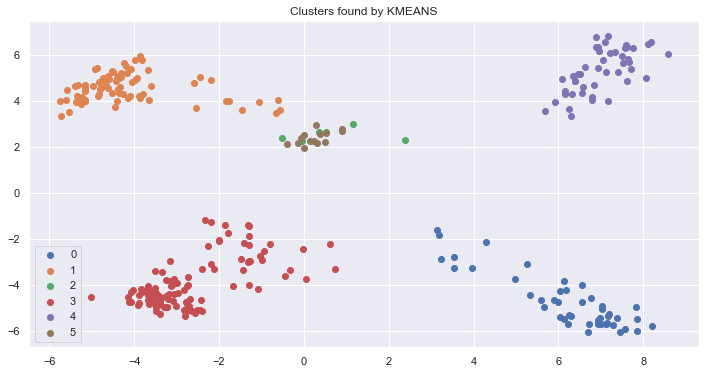

In [40]:
kmeans = SparkKmeans(featuresCol = 'features', k=ind)
model_k = kmeans.fit(cluster_final_data)
predictions  = model_k.transform(cluster_final_data).select('prediction').collect()
labels = [p.prediction for p in predictions ]
plot_clusters(pca_df, labels, "KMEANS")

### Spark Clustering - GMM

with K=2
with silhouette=0.10146679472655819
with K=3
with silhouette=0.32145017272458604
with K=4
with silhouette=0.3156090227724592
with K=5
with silhouette=0.16309178874030228
with K=6
with silhouette=0.1503173180232295
with K=7
with silhouette=0.1271714639292572
with K=8
with silhouette=0.03814626370021831
with K=9
with silhouette=0.04579192758411788
with K=10
with silhouette=0.08576274944169845
with K=11
with silhouette=0.13630480046574744
with K=12
with silhouette=0.09873276670532964
with K=13
with silhouette=0.09178373908100573
with K=14
with silhouette=0.04393624655579751
with K=15
with silhouette=-0.032087836665338564
with K=16
with silhouette=-0.02481975227047865
with K=17
with silhouette=-0.06011474400772499
with K=18
with silhouette=0.1258844787589919
with K=19
with silhouette=0.03941956155140316
best_n_clusters:  3
best_silhouette=0.32145017272458604


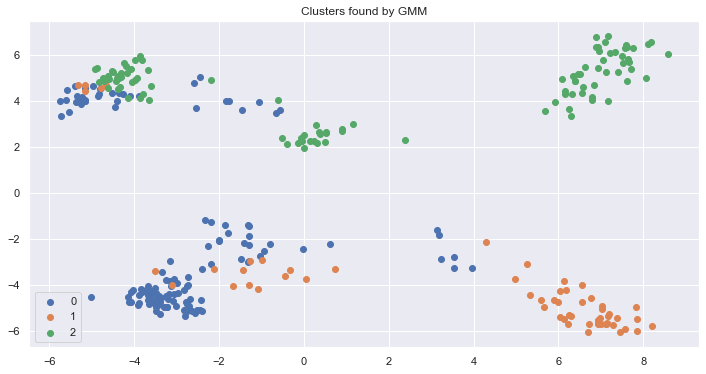

In [41]:
from pyspark.ml.clustering import GaussianMixture as GMM

sil = []

for k in range(2,20):
    gmm = GMM(seed=10).setK(k)
    model_k = gmm.fit(cluster_final_data)
    predictions = model_k.transform(cluster_final_data)
    silhouette = evaluator.evaluate(predictions)
    sil.append(silhouette)
    print("with K={}".format(k))
    print("with silhouette={}".format(silhouette))

ind = np.argmax(sil) + 2
print("best_n_clusters: ", ind)   
silhouette_max = np.amax(sil)
print("best_silhouette={}".format(silhouette_max))

# Trains Gaussian Mixture Model
gmm = GMM(seed=10).setK(ind)
model_k = gmm.fit(cluster_final_data)
predictions = model_k.transform(cluster_final_data).select('prediction').collect()
labels = [p.prediction for p in predictions ]
plot_clusters(pca_df, labels, "GMM")

## Car prices classification

#### Importing the Libraries

In [59]:
import requests
from bs4 import BeautifulSoup
import typing
import urllib
from time import sleep
from random import uniform
import random
import locale

**1. Collect DataSet**

In [60]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
x = opener.open('https://www.yad2.co.il/vehicles/private-cars?page=2')

In [61]:
headers = {
    'User-Agent': 'PostmanRuntime/7.26.8',
    'Accept': '*/*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Content-Type': 'application/x-www-form-urlencoded'
}
url = 'https://www.yad2.co.il/vehicles/private-cars?page=2'
jsonResponse = requests.post(url, headers= headers)

In [62]:
class Not200StatusCode(Exception):
    pass


class Parser:
    """
    Basic yad2.co.il parser, data parsing (apartment rentals) for the specified parameters
    Makes request to the site, parses the data, saves data to a list
    """
    base_url = 'https://www.yad2.co.il/vehicles/private-cars'
    manufacturer_url = '?manufacturer='
    model_url = '&model='
    group_color = '&group_color='
    pages_url = '&page={page_number}'
    year = '&year='

    def __init__(self, keywords, is_paginate=True, url=True):
        self.classification = keywords[1]
        self.keywords = keywords
        self.is_paginate = is_paginate
        self.url = url
        self.data = []

    def _make_url(self, keywords: list) -> str:
        """
        Generates a url based on parsing parameters.
        :param keywords: numbers of rooms, price, floor
        :return: url ready for parsing
        """
        # Adds url's with keywords to the base url
        self.url = self.base_url + self.manufacturer_url + str(keywords[0]) \
                   + self.model_url + str(keywords[1]) \
                   + self.group_color + str(keywords[2]) \
                   + self.year + str(keywords[3]) + '&priceOnly=1'
        return self.url

    def _pagination(self, page_number, pages_url):
        """
        Generates the url of the next page and sends a request to the site.
        :param page_number:
        :return: content html
        """
        url = self._make_url(keywords=self.keywords)
        url_pagination = url + pages_url.format(page_number=page_number)
        headers = {
            'Host': 'www.yad2.co.il',
            'Connection': 'keep-alive',
            'Pragma': 'no-cache',
            'Cache-Control': 'no-cache',
            'Upgrade-Insecure-Requests': '1',
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
            'Sec-Fetch-Site': 'none',
            'Sec-Fetch-Mode': 'navigate',
            'Sec-Fetch-User': '?1',
            'Sec-Fetch-Dest': 'document',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'en-US,en;q=0.9',
            'Cookie': 'recommendations-searched-vehicles=true; __uzma=c7cadb83-d6ce-4987-aa67-3c469736ca18; __uzmb=1612516098; __uzme=8743; abTestKey=41; _ga=GA1.3.371937583.1612516101; leadSaleRentFree=57; use_elastic_search=1; __ssds=3; __ssuzjsr3=a9be0cd8e; __gads=ID=48d4ec304510c4bf:T=1612516102:S=ALNI_MZSXiVO5ZMKNss0JZwHi9rENuabGg; _fbp=fb.2.1612516103733.821674275; _hjTLDTest=1; _hjid=1d400ae0-6bd4-41bb-adce-a6031b2330ed; bc.visitor_token=6742332496341942272; __uzmaj3=0679bf7e-912b-47fc-8545-73cdc585fcda; __uzmbj3=1612519564; canary=never; _gid=GA1.3.1121440698.1613126801; server_env=production; y2_cohort_2020=17; y2018-2-cohort=69; _hjIncludedInSessionSample=1; __uzmcj3=674293464901; __uzmdj3=1613153118; __uzmd=1613153120; __uzmc=2457380595843; favorites_userid=bjc320620000'
        }
        
        http_proxies = [
                "http://58.242.145.227:8080",
                "http://101.66.253.22:8080",
                "http://209.66.193.186:8080",
                "http://101.26.38.162:80",
                "http://123.7.88.171:3128",
                "http://50.207.44.18:3128",
                "http://117.169.14.81:8080",
                "http://177.133.140.243:3128",
                "http://122.4.244.121:80",
                "http://199.115.114.38:80",
            ]

        http_proxy = random.choice(http_proxies)

        proxy_dict = {
            "http": http_proxy
        }
        sleep(uniform(5, 8))

        response = requests.get(url_pagination, headers = headers, proxies=proxy_dict)
        
        sleep(uniform(5, 8))

        return response.content

    def _pars_block(self, blocks) -> typing.List[dict]:
        """
        Splits the page content into blocks
        Generates a dictionary for each data block and saves them to a list.
        :param blocks: the content of the page
        :return: list of data
        """
        sleep(uniform(5, 8))
        data = []
        counter = 0
        for block in blocks:
            print(block['item-id'])

            headers = {
               'Host': 'www.yad2.co.il',
                'Connection': 'keep-alive',
                'Pragma': 'no-cache',
                'Cache-Control': 'no-cache',
                'Accept': 'application/json, text/plain, /',
                'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36',
                'Sec-Fetch-Site': 'same-origin',
                'Sec-Fetch-Mode': 'cors',
                'Sec-Fetch-Dest': 'empt',
                'Referer': 'https://www.yad2.co.il/vehicles/private-cars?manufacturer=22&model=1645&year=2014-2020&group_color=3,9,2,6,4,7,5,10,8,11,1&engineval=1000-3000',
                'Accept-Encoding': 'gzip, deflate, br',
                'Accept-Language': 'en-US,en;q=0.9',
                'Cookie': '__uzma=c7cadb83-d6ce-4987-aa67-3c469736ca18; __uzmb=1612516098; __uzme=8743; _ga=GA1.3.371937583.1612516101; leadSaleRentFree=57; use_elastic_search=1; __ssds=3; __ssuzjsr3=a9be0cd8e; __gads=ID=48d4ec304510c4bf:T=1612516102:S=ALNI_MZSXiVO5ZMKNss0JZwHi9rENuabGg; _fbp=fb.2.1612516103733.821674275; _hjTLDTest=1; _hjid=1d400ae0-6bd4-41bb-adce-a6031b2330ed; bc.visitor_token=6742332496341942272; __uzmaj3=0679bf7e-912b-47fc-8545-73cdc585fcda; __uzmbj3=1612519564; y2018-2-cohort=69; abTestKey=28; canary=never; _gid=GA1.3.1788963780.1614791460; server_env=production; y2_cohort_2020=91; recommendations-searched-vehicles=true; _hjIncludedInSessionSample=1; __uzmcj3=576307040876; __uzmdj3=1614795626; __uzmd=1614796072; __uzmc=69713150481216; favorites_userid=bjc320620000'
            }
                    
            image_url = block.find('img', class_='feedImage')
            car_name = block.find('span', class_='title')
            adress_block = block.find('div', class_='rows')
            middle_col = block.find('div', class_='middle_col')
            left_col = block.find('div', class_='left_col')
            ghost_price = left_col.find('div', class_='ghost_price')
            year = middle_col.find('div', class_='data')
            allData = middle_col.find_all('div', class_='data')

            for i, d in enumerate(allData): 
                if i == 0:
                    year = d.get_text()
                elif i == 1:
                    yad = d.get_text()
                elif i == 2:
                    volume = d.get_text()
                    
            color = str(self.keywords[2])
                
            #to do according to what returns
            d = {
                'id': counter,
                'img_url': image_url['src'],
                'car_name': adress_block.get_text(),
                'car_name2': car_name.get_text(),
                'classification': self.classification,
                'item_id': block['item-id'],
                'color': color,
                'year': year,
                'price': ghost_price.get_text(),
                'yad': yad,
                'volume': volume
            }
            
            print(d)
            
            print("car type: " , d["car_name2"])
            counter = counter + 1

            data.append(d)
        return data

    def parse_content(self, content: bytes, page_number=2) -> typing.List[dict]:
        """
        Recursive method.
        Gets content (blocks), parser it and saves the information to a list.
        Checks for pagination, parses the following pages.
        :param page_number:
        :param content: html
        :return: list of data
        """
        sleep(uniform(8, 15))

        soup = BeautifulSoup(content, 'html')
        
        #print(soup)
        
        blocks = soup.find_all('div', class_='feed_item feed_item-v4 accordion desktop')
        
        print("blocks:" , len(blocks))
        
        data = self._pars_block(blocks)
        self.data.extend(data)
        print('INFO: already parsed {} blocks'.format(len(self.data)))
    

        #print(data)
        
        sleep(uniform(8, 15))

        # find the button 'next' that is not active in the pagination
        paginated_block = soup.find('div', class_='pagination clickable')
        
        if paginated_block == None:
            button_next = True
        else:
            button_next = paginated_block.find('button', class_='page-num current-page-num')
            print('Next button: ', button_next)  # None

        # if pagination is enabled and button next is active
        if self.is_paginate and not button_next:
            sleep(uniform(8, 15))
            print('INFO: Try to paginate page number ', page_number)
            # get the content of the next page
            content = self._pagination(page_number, pages_url=self.pages_url)

            self.parse_content(content, page_number + 1)

        return self.data

    def send_request(self, url: str) -> bytes:
        """
        The method generates and sends a request to the site.
        Calls the sleep method to avoid being banned.
        :param url: url with search parameters
        :return: html content
        """
        sleep(uniform(3, 8))

        print('INFO: url is ', url)

        headers = {
            'Host': 'www.yad2.co.il',
            'Connection': 'keep-alive',
            'Pragma': 'no-cache',
            'Cache-Control': 'no-cache',
            'Upgrade-Insecure-Requests': '1',
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
            'Sec-Fetch-Site': 'none',
            'Sec-Fetch-Mode': 'navigate',
            'Sec-Fetch-User': '?1',
            'Sec-Fetch-Dest': 'document',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'en-US,en;q=0.9',
            'Cookie': 'recommendations-searched-vehicles=true; __uzma=c7cadb83-d6ce-4987-aa67-3c469736ca18; __uzmb=1612516098; __uzme=8743; abTestKey=41; _ga=GA1.3.371937583.1612516101; leadSaleRentFree=57; use_elastic_search=1; __ssds=3; __ssuzjsr3=a9be0cd8e; __gads=ID=48d4ec304510c4bf:T=1612516102:S=ALNI_MZSXiVO5ZMKNss0JZwHi9rENuabGg; _fbp=fb.2.1612516103733.821674275; _hjTLDTest=1; _hjid=1d400ae0-6bd4-41bb-adce-a6031b2330ed; bc.visitor_token=6742332496341942272; __uzmaj3=0679bf7e-912b-47fc-8545-73cdc585fcda; __uzmbj3=1612519564; canary=never; _gid=GA1.3.1121440698.1613126801; server_env=production; y2_cohort_2020=17; y2018-2-cohort=69; _hjIncludedInSessionSample=1; __uzmcj3=674293464901; __uzmdj3=1613153118; __uzmd=1613153120; __uzmc=2457380595843; favorites_userid=bjc320620000'
        }
        
        http_proxies = [
                "http://58.242.145.227:8080",
                "http://101.66.253.22:8080",
                "http://209.66.193.186:8080",
                "http://101.26.38.162:80",
                "http://123.7.88.171:3128",
                "http://50.207.44.18:3128",
                "http://117.169.14.81:8080",
                "http://177.133.140.243:3128",
                "http://122.4.244.121:80",
                "http://199.115.114.38:80",
            ]

        http_proxy = random.choice(http_proxies)

        proxy_dict = {
            "http": http_proxy
        }
        
        sleep(uniform(3, 8))

        response = requests.get(url, headers= headers,  proxies=proxy_dict)

        sleep(uniform(3, 8))

        if not response.status_code == 200:
            raise Not200StatusCode('Status code is: ', response.status_code)

        print('INFO: Status code is 200')
        # print(response.content)

        return response.content

    def start(self, keywords: list):
        self.keywords = keywords
        self.classification = keywords[1]
        self.data = []
        """
        Calls methods of the class.
        :param keywords: numbers of rooms, price, floor
        :return:
        """
        url = self._make_url(keywords)
        html_content = self.send_request(url)

        #print(html_content)  # Если забанили, показывает капчу

        data = self.parse_content(html_content)
        print('LEN DATA: ', len(data))

        return data

In [63]:
p = Parser([22, 1645, 10, '2014-2020'], True) # Mazda 3

In [64]:
def get_cars(filters):
    cars = []
    for filt in filters:
        cars.append(p.start(filt))
    return cars

In [65]:
cars = get_cars([[22, 1645, '10', '2004-2021']]) # Mazda 3
cars2 = get_cars([[22, 1645, '10', '2004-2021']]) # Mazda 3
print(cars2)
len(cars2[0])

INFO: url is  https://www.yad2.co.il/vehicles/private-cars?manufacturer=22&model=1645&group_color=10&year=2004-2021&priceOnly=1
INFO: Status code is 200
blocks: 18
ecj8gcrr
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202103/04/1_1/o/y2_1_02872_20210304080317.jpeg?l=7&c=3&w=195&h=117', 'car_name': '\n                        מאזדה 3\n                      Sport סדאן אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'ecj8gcrr', 'color': '10', 'year': '2017 שנה', 'price': '\n                    86,000 ₪\n                ', 'yad': '3 יד', 'volume': '1,998 סמ"ק'}
car type:  
                        מאזדה 3
                    
9hioqqfy
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/17/1_1/o/y2_1_01561_20210217110206.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Sport Comfort הצ'בק אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\

Next button:  None
INFO: Try to paginate page number  2
blocks: 18
f3i3nqxl
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/26/1_1/o/y2_2_04795_20210226220214.jpeg?l=7&c=3&w=195&h=117', 'car_name': '\n                        מאזדה 3\n                      Spirit הצ\'בק אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'f3i3nqxl', 'color': '10', 'year': '2016 שנה', 'price': '\n                    73,000 ₪\n                ', 'yad': '2 יד', 'volume': '1,998 סמ"ק'}
car type:  
                        מאזדה 3
                    
kubgkh1v
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202103/03/1_1/o/y2_1_07701_20210303210349.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'kubgkh1v', 'color': '10', 'year': '2012 שנ

Next button:  None
INFO: Try to paginate page number  3
blocks: 18
8jrid7o1
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202103/06/1_1/o/y2_2_01440_20210306200307.jpeg?l=7&c=3&w=195&h=117', 'car_name': '\n                        מאזדה 3\n                      Premium הצ\'בק אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': '8jrid7o1', 'color': '10', 'year': '2018 שנה', 'price': '\n                    96,000 ₪\n                ', 'yad': '2 יד', 'volume': '1,998 סמ"ק'}
car type:  
                        מאזדה 3
                    
zepfedou
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202103/02/1_1/o/y2_1_08387_20210302190326.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'zepfedou', 'color': '10', 'year': '2006 ש

Next button:  None
INFO: Try to paginate page number  4
blocks: 18
85jxxnhr
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202103/04/1_1/o/y2_8_08069_20210304200342.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Comfort סדאן אוט' 1.5 (120 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': '85jxxnhr', 'color': '10', 'year': '2016 שנה', 'price': '\n                    58,000 ₪\n                ', 'yad': '2 יד', 'volume': '1,496 סמ"ק'}
car type:  
                        מאזדה 3
                    
3i1c4j67
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202103/08/1_1/o/y2_1_01599_20210308110317.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.5 (120 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': '3i1c4j67', 'color': '10', 'year': '2016 שנה

Next button:  None
INFO: Try to paginate page number  5
blocks: 33
ysczmcgt
{'id': 0, 'img_url': '//assets.yad2.co.il/yad2site/y2assets/images/pages/feed/feed_car_placeholder_small.png', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'ysczmcgt', 'color': '10', 'year': '2008 שנה', 'price': '\n                    10,500 ₪\n                ', 'yad': '5 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
t7wkbsv9
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/26/1_1/o/y2_1_01954_20210226190256.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.5 (120 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 't7wkbsv9', 'color': '10', 'year': '2015 שנה', 'pric

Next button:  None
INFO: Try to paginate page number  6
blocks: 36
sytup32f
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202103/01/1_1/o/y2_1_03116_20210301070309.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Comfort סדאן אוט' 1.5 (120 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'sytup32f', 'color': '10', 'year': '2017 שנה', 'price': '\n                    74,000 ₪\n                ', 'yad': '1 יד', 'volume': '1,496 סמ"ק'}
car type:  
                        מאזדה 3
                    
viamwt5f
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/04/1_1/o/y2_1_07123_20210204220237.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'viamwt5f', 'color': '10', 'year': '2012 שנה

Next button:  None
INFO: Try to paginate page number  7
blocks: 36
zgxeq30k
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/17/1_1/o/y2_1_03200_20210217090229.jpeg?l=7&c=3&w=195&h=117', 'car_name': '\n                        מאזדה 3\n                      Sport הצ\'בק אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'zgxeq30k', 'color': '10', 'year': '2018 שנה', 'price': '\n                    88,000 ₪\n                ', 'yad': '2 יד', 'volume': '1,998 סמ"ק'}
car type:  
                        מאזדה 3
                    
qpdwytto
{'id': 1, 'img_url': '//assets.yad2.co.il/yad2site/y2assets/images/pages/feed/feed_car_placeholder_small.png', 'car_name': '\n                        מאזדה 3\n                      Spirit הצ\'בק אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'qpdwytto', 'color': '10', 'year': '2016 שנה', 'p

Next button:  None
INFO: Try to paginate page number  8
blocks: 11
jo0tjsot
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/04/1_1/o/y2_2_02527_20210204110206.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'jo0tjsot', 'color': '10', 'year': '2010 שנה', 'price': '\n                    22,000 ₪\n                ', 'yad': '3 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
gpzqtq3o
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/04/1_1/o/y2_1_08627_20210204100255.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'gpzqtq3o', 'color': '10', 'year': '2010 שנה'

Next button:  None
INFO: Try to paginate page number  2
blocks: 18
f3i3nqxl
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/26/1_1/o/y2_2_04795_20210226220214.jpeg?l=7&c=3&w=195&h=117', 'car_name': '\n                        מאזדה 3\n                      Spirit הצ\'בק אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'f3i3nqxl', 'color': '10', 'year': '2016 שנה', 'price': '\n                    73,000 ₪\n                ', 'yad': '2 יד', 'volume': '1,998 סמ"ק'}
car type:  
                        מאזדה 3
                    
kubgkh1v
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202103/03/1_1/o/y2_1_07701_20210303210349.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'kubgkh1v', 'color': '10', 'year': '2012 שנ

Next button:  None
INFO: Try to paginate page number  3
blocks: 18
8jrid7o1
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202103/06/1_1/o/y2_2_01440_20210306200307.jpeg?l=7&c=3&w=195&h=117', 'car_name': '\n                        מאזדה 3\n                      Premium הצ\'בק אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': '8jrid7o1', 'color': '10', 'year': '2018 שנה', 'price': '\n                    96,000 ₪\n                ', 'yad': '2 יד', 'volume': '1,998 סמ"ק'}
car type:  
                        מאזדה 3
                    
zepfedou
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202103/02/1_1/o/y2_1_08387_20210302190326.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'zepfedou', 'color': '10', 'year': '2006 ש

Next button:  None
INFO: Try to paginate page number  4
blocks: 18
85jxxnhr
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202103/04/1_1/o/y2_8_08069_20210304200342.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Comfort סדאן אוט' 1.5 (120 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': '85jxxnhr', 'color': '10', 'year': '2016 שנה', 'price': '\n                    58,000 ₪\n                ', 'yad': '2 יד', 'volume': '1,496 סמ"ק'}
car type:  
                        מאזדה 3
                    
3i1c4j67
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202103/08/1_1/o/y2_1_01599_20210308110317.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.5 (120 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': '3i1c4j67', 'color': '10', 'year': '2016 שנה

Next button:  None
INFO: Try to paginate page number  5
blocks: 33
ysczmcgt
{'id': 0, 'img_url': '//assets.yad2.co.il/yad2site/y2assets/images/pages/feed/feed_car_placeholder_small.png', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'ysczmcgt', 'color': '10', 'year': '2008 שנה', 'price': '\n                    10,500 ₪\n                ', 'yad': '5 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
t7wkbsv9
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/26/1_1/o/y2_1_01954_20210226190256.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.5 (120 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 't7wkbsv9', 'color': '10', 'year': '2015 שנה', 'pric

Next button:  None
INFO: Try to paginate page number  6
blocks: 36
sytup32f
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202103/01/1_1/o/y2_1_03116_20210301070309.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Comfort סדאן אוט' 1.5 (120 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'sytup32f', 'color': '10', 'year': '2017 שנה', 'price': '\n                    74,000 ₪\n                ', 'yad': '1 יד', 'volume': '1,496 סמ"ק'}
car type:  
                        מאזדה 3
                    
viamwt5f
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/04/1_1/o/y2_1_07123_20210204220237.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'viamwt5f', 'color': '10', 'year': '2012 שנה

Next button:  None
INFO: Try to paginate page number  7
blocks: 36
zgxeq30k
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/17/1_1/o/y2_1_03200_20210217090229.jpeg?l=7&c=3&w=195&h=117', 'car_name': '\n                        מאזדה 3\n                      Sport הצ\'בק אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'zgxeq30k', 'color': '10', 'year': '2018 שנה', 'price': '\n                    88,000 ₪\n                ', 'yad': '2 יד', 'volume': '1,998 סמ"ק'}
car type:  
                        מאזדה 3
                    
qpdwytto
{'id': 1, 'img_url': '//assets.yad2.co.il/yad2site/y2assets/images/pages/feed/feed_car_placeholder_small.png', 'car_name': '\n                        מאזדה 3\n                      Spirit הצ\'בק אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'qpdwytto', 'color': '10', 'year': '2016 שנה', 'p

Next button:  None
INFO: Try to paginate page number  8
blocks: 11
jo0tjsot
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/04/1_1/o/y2_2_02527_20210204110206.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'jo0tjsot', 'color': '10', 'year': '2010 שנה', 'price': '\n                    22,000 ₪\n                ', 'yad': '3 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
gpzqtq3o
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/04/1_1/o/y2_1_08627_20210204100255.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'gpzqtq3o', 'color': '10', 'year': '2010 שנה'

188

**2. Convert Data To Data Frame**

In [67]:
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
print(locale.atoi('1,000,000'))

counter = 0
d = {}
arr = []
for car in cars2[0]:
    counter = counter + 1
    #print("counter: ", counter)
    print(car['yad'].replace("יד", "").strip())
    arr.append([int(car['year'].replace("שנה", "").strip()),
                int(locale.atoi(car['price'].replace("₪", "").strip())),
                int(car['yad'].replace("יד", "").replace("+", "").strip()),
                int(locale.atoi(car['volume'].replace('סמ"ק', "")))])

df = pd.DataFrame(np.array(arr), columns=['year', 'price', 'yad', 'volume'])
print(df)

1000000
3
2
5
2
2
2
2
2
2
2
2
2
3
2
4
2
3
2
2
1
6
1
2
3
2
3
1
2
2
2
1
2
2
1
3
2
2
2
2
2
2
2
3
2
3
2
1
3
2
3
4
3
1
2
2
2
3
2
3
1
2
2
3
2
2
2
2
3
1
4
2
4
5
2
3
3
3
3
3
3
4
7
3
3
3
2
3
2
2
3
10+
3
2
1
3
3
1
2
3
2
1
2
4
2
2
1
6
2
2
2
3
7
3
4
2
2
2
3
3
1
3
1
4
3
3
3
2
3
4
3
2
2
9
3
4
3
1
2
3
2
3
2
1
3
2
3
2
2
2
2
2
5
5
4
1
3
3
2
3
1
3
4
1
3
2
2
2
3
1
2
4
2
3
3
3
2
3
3
2
4
3
4
2
2
2
2
2
3
     year  price  yad  volume
0    2017  86000    3    1998
1    2012  33000    2    1598
2    2010  26000    5    1598
3    2009  18000    2    1598
4    2016  79000    2    1998
..    ...    ...  ...     ...
183  2009  21000    2    1598
184  2010  18000    2    1598
185  2010  20000    2    1598
186  2015  75000    2    1998
187  2011  22900    3    1598

[188 rows x 4 columns]


**3. Visualisation**

Text(0.5, 1.0, 'volume')

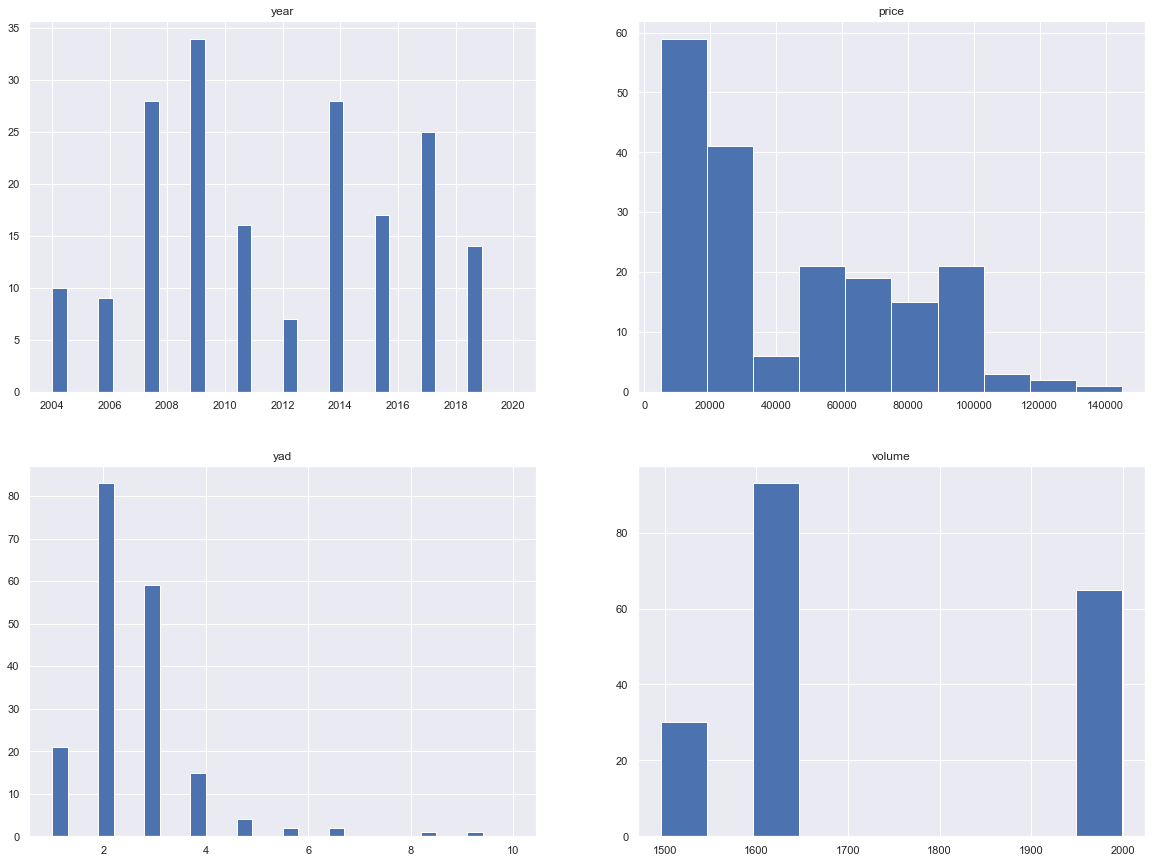

In [183]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))  

axs[0,0].hist(df.year , width=0.5)
axs[0,0].set_title("year")
axs[0,1].hist(df.price) 
axs[0,1].set_title("price")
axs[1,0].hist(df.yad , width=0.3, align ='mid')
axs[1,0].set_title("yad")
axs[1,1].hist(df.volume)
axs[1,1].set_title("volume")

Text(0.5, 1.0, 'volume vs price')

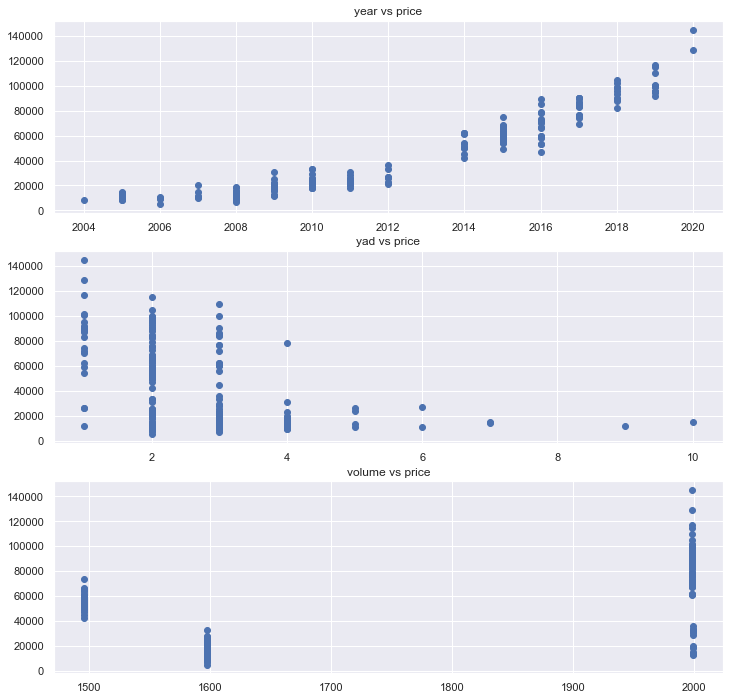

In [184]:
fig, axs = plt.subplots(3, figsize=(12,12)) 
axs[0].scatter(df.year, df.price)
axs[0].set_title("year vs price")
axs[1].scatter(df.yad, df.price)
axs[1].set_title("yad vs price")
axs[2].scatter(df.volume, df.price)
axs[2].set_title("volume vs price")

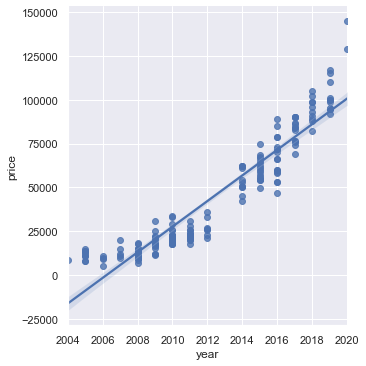

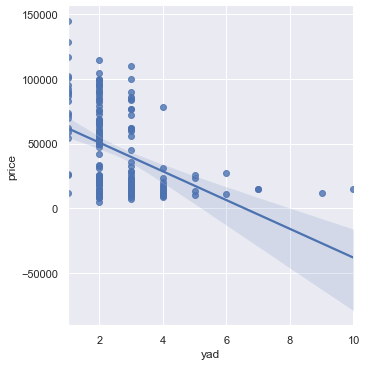

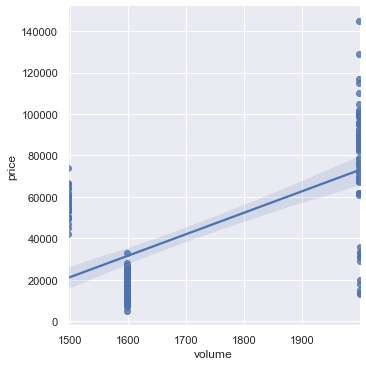

In [185]:
import seaborn as sns
sns.lmplot('year','price', data=df)
sns.lmplot('yad','price', data=df)
sns.lmplot('volume','price', data=df)

C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:306: 

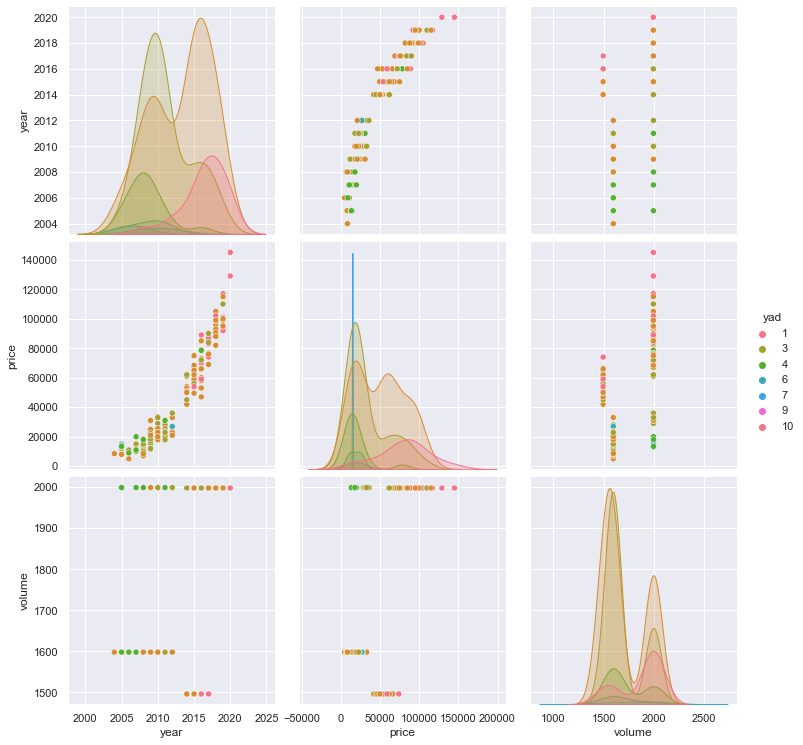

In [186]:
sns.pairplot(df,hue = 'yad',diag_kind = "kde",kind = "scatter",palette = "husl",height=3.5)
plt.show()

**4.Classification Algorithms**

In [ ]:
import json
import pickle

from sklearn.linear_model import LinearRegression #Linear Regression
from sklearn.linear_model import Lasso #Lasso Regression
from sklearn.tree import DecisionTreeRegressor #Decision Tree Regression
from sklearn.ensemble import RandomForestRegressor #Random Forest Regression
from sklearn.model_selection import train_test_split #Splitting the dataset into training and testing

In [70]:
X = pd.concat([df.drop(['price'],axis=1)], axis=1)
y = df['price']

In [72]:
X.head(5)

,year,yad,volume
0,2017,3,1998
1,2012,2,1598
2,2010,5,1598
3,2009,2,1598
4,2016,2,1998


In [73]:
y.head(5)

0    86000
1    33000
2    26000
3    18000
4    79000
Name: price, dtype: int32

### LinearRegression

In [124]:
lreg = LinearRegression()
lreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [125]:
lreg.coef_

array([6258.95178758, -877.66271975,   38.58903011])

In [126]:
lreg.intercept_

-12614565.2323702

In [128]:
coeff_df = pd.DataFrame(df.columns)
coeff_df.columns = ['Features']
coeff_df['Value'] = pd.Series(lreg.coef_)
coeff_df

,Features,Value
0,year,6258.951788
1,price,-877.662720
2,yad,38.589030
3,volume,NaN


**Train/Test**

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [143]:
X_train.shape

(150, 3)

In [144]:
y_train.shape

(150,)

In [145]:
X_test.shape 

(38, 3)

In [146]:
y_test.shape

(38,)

In [147]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [149]:
pred_test = lr.predict(X_test)
np.mean((y_test - pred_test)**2)

50139959.798408374

In [150]:
pred_train = lreg.predict(X_train)
np.mean((y_train - pred_train)**2)

71049468.80933118

In [154]:
pred_test

array([18817.04670951, 19680.84572935, -5959.78611546, 99046.77074539,
       13270.68776814, 39775.11863279, 84498.85678332, 97319.17270572,
       23499.60663105, 17953.24768968, 29909.76459225, 48059.49620739,
       31637.36263192,  5885.36457519, 12406.88874831, 31637.36263192,
        9815.49168881, 47195.69718755, 10679.29070864, 13270.68776814,
       72542.33988075, 92636.61278419, 30773.56361208, 31637.36263192,
       98182.97172556, 38911.31961295, 68153.76911083,   450.37184574,
       91772.81376435, 78088.69882212, 32501.16165175, 98182.97172556,
        4157.76653552, 31637.36263192, 11543.08972848,  -413.42717409,
       13270.68776814, 26091.00369055])

In [152]:
lr.score(X_test,y_test)

0.9497561797912276

In [161]:
from sklearn.metrics import mean_squared_error, r2_score
print('Mean squared error: %.2f' % mean_squared_error(y_test, pred_test))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, pred_test))

Mean squared error: 50139959.80
Coefficient of determination: 0.95


### Naive_Bayes

In [182]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
  
# making predictions on the testing set 
y_pred = gnb.predict(X_test) 

from sklearn import metrics 
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Gaussian Naive Bayes model accuracy(in %): 5.263157894736842
Mean squared error: 66910292.74
Coefficient of determination: 0.93


As you can see, we are getting low score from Linear Regression. Let's see if we can get better results from different regression models.

## Find best model using GridSearchCV

In [168]:
from sklearn.model_selection import ShuffleSplit #Random shuffling
from sklearn.model_selection import cross_val_score #Score cross validation
from sklearn.model_selection import GridSearchCV #Hyper parameter tuning
from warnings import simplefilter #Filtering warnings
from sklearn.metrics import r2_score
simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

ModuleNotFoundError: No module named 'xgboost'

In [163]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.95582987, 0.91890225, 0.94079017, 0.92528943, 0.91540796])

In [179]:
import xgboost as xgb
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'n_estimators': range(1,50,5)
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.931244,{'normalize': True}
1,lasso,0.931247,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.971517,"{'criterion': 'friedman_mse', 'splitter': 'ran..."
3,random_forest,0.970958,"{'criterion': 'mse', 'n_estimators': 6}"


### Predict price

In [ ]:
model = RandomForestRegressor(criterion='mse',n_estimators=46, scoring=r2_score)

In [ ]:
model.fit(X_train,y_train)

In [ ]:
model.score(X_test,y_test)

In [ ]:
def predict_price(yad,year,volume):
    x = []
    x[:3] = np.zeros(3,dtype='int32')
    x[0] = year
    x[1] = yad
    x[2] = volume
    
    
    result = model.predict([x])
    
    return float(format(model.predict([x])[0],'.3f'))

In [ ]:
predict_price('3', '2014', '2000')

In [ ]:
predict_price('1', '2020', '2000')

In [ ]:
predict_price('1', '2016', '2000')

### Predict price vs Yad2_price_list

In [ ]:
def find_price_yad2_price_list(year, subModelId):

    url_yad2_pricelist = "http://pricelist.yad2.co.il/cardetails_n.php?SubModelID=" + str(subModelId) + "&Year=" + str(year)

    print("url for downloading: ", url_yad2_pricelist)
    
    headers = {
        'Host': 'pricelist.yad2.co.il',
        'Connection': 'keep-alive',
        'Pragma': 'no-cache',
        'Cache-Control': 'no-cache',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'Referer': 'http://validate.perfdrive.com/',
        'Accept-Encoding': 'gzip, deflate',
        'Accept-Language': 'en-US,en;q=0.9',
        'Cookie': '_ga=GA1.3.371937583.1612516101; leadSaleRentFree=57; __ssds=3; __ssuzjsr3=a9be0cd8e; __gads=ID=48d4ec304510c4bf:T=1612516102:S=ALNI_MZSXiVO5ZMKNss0JZwHi9rENuabGg; _fbp=fb.2.1612516103733.821674275; _hjTLDTest=1; _hjid=1d400ae0-6bd4-41bb-adce-a6031b2330ed; __uzmaj3=0679bf7e-912b-47fc-8545-73cdc585fcda; __uzmbj3=1612519564; y2018-2-cohort=69; abTestKey=28; historyprimaryarea=hamerkaz_area_Multiple___hamerkaz_area_Multiple; historysecondaryarea=+___+; __uzma=5beca20f-8081-41a1-bdb9-87ad8d58dc6c; __uzmb=1614870802; __uzme=2239; y2session=ud6ldu0vvgsmsu9n8vvo9nhhj7; PricelistHash=24a9876f0a08adcd282ff833f96d2047; _ga=GA1.4.371937583.1612516101; use_elastic_search=1; _gid=GA1.3.766821828.1615230266; server_env=production; y2_cohort_2020=55; _gid=GA1.4.766821828.1615230266; __uzmcj3=617428593311; __uzmdj3=1615289879; favorites_userid=bjc320620000; _dc_gtm_UA-708051-1=1; __uzmc=748779778316; __uzmd=1615290866'
    }
        
    http_proxies = [
            "http://58.242.145.227:8080",
            "http://101.66.253.22:8080",
            "http://209.66.193.186:8080",
            "http://101.26.38.162:80",
            "http://123.7.88.171:3128",
            "http://50.207.44.18:3128",
            "http://117.169.14.81:8080",
            "http://177.133.140.243:3128",
            "http://122.4.244.121:80",
            "http://199.115.114.38:80",
        ]

    http_proxy = random.choice(http_proxies)

    proxy_dict = {
        "http": http_proxy
    }
    
    response = requests.get(url_yad2_pricelist, headers = headers)

    content = response.content

    #print(content)
    
    soup = BeautifulSoup(content, 'html')

    price_tag = soup.find('div', class_='priceTicket').get_text()
    
    return price_tag

    print(price_tag)

In [ ]:
predictedX = X_test,y_test
predict_price('1', '2016', '2000')
find_price_yad2_price_list(2016, 27049)

In [ ]:
print(X_test)
for x in X_test:
    print(x) 

In [ ]:
df1 = pd.DataFrame(X_test)
df2 = pd.DataFrame(y_test)

In [ ]:
print(df1.describe())

In [ ]:
print(df2.describe())

In [ ]:
from sklearn import metrics 
import numpy as np


list_true = []
list_pred = []


for first, second in zip(df2.iterrows(), df1.iterrows()):
    index, row = first
    index2, row2 = second
    
    real_result = row['price']
    predicted_result = predict_price(row2['yad'], row2['year'], row2['volume'])
    list_true.append(real_result)
    list_pred.append(predicted_result)
    print("true: ", real_result, "predicted: ", predicted_result)


**Calculating MSE, RMSE, ABE:**

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(list_true, list_pred)) 
print('Mean Squared Error:', metrics.mean_squared_error(list_true, list_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(list_true, list_pred)))